In [3]:
%load_ext tensorboard

%tensorboard --logdir '/media/data_cifs_lrs/projects/prj_fossils/users/jacob/tensorboard_log_dir'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8276), started 0:01:19 ago. (Use '!kill 8276' to kill it.)

In [1]:
!ls '/media/data_cifs_lrs/projects/prj_fossils/users/jacob/tensorboard_log_dir'

train  validation


In [1]:
from hydra.experimental import compose, initialize
import hydra
from copy import copy
from omegaconf import OmegaConf
from pyleaves.train.paleoai_train import build_model
from box import Box, BoxList
import os
from datetime import datetime
from itertools import product

logs = BoxList([])

seed = 78

import random
import numpy as np
np.random.seed(seed)
random.seed(seed)

from pyleaves.utils import ensure_dir_exists

/media/data/conda/jacob/envs/pyleaves2/lib/python3.7/site-packages/scikitplot/plotters.py:37: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  DeprecationWarning)


In [4]:
# hparam_keys = ['lr', 'l2']
# hparams = [(1e-4,5e-5,1e-5), (1e-5,4e-5,4e-4,1e-3,5e-3)]

# experiment_start_time = datetime.now().ctime()

# log_dir = '/media/data_cifs_lrs/projects/prj_fossils/users/jacob/hparam_sweeps_sept_2020'
# ensure_dir_exists(log_dir)

# list_of_hparam_trials = np.array(list(product(*hparams)))
# num_trials = len(list_of_hparam_trials)
# new_order = random.sample(range(num_trials), num_trials)

# for i, hp in enumerate(list_of_hparam_trials[new_order]):
#     logs.append(Box({'trial':i,
#                     **{k:float(v) for k,v in zip(hparam_keys,hp)}}))

    
    
# with open(log_path, 'w') as f:
#     OmegaConf.save(Box(logs=logs), f=f)
#     f.writelines(logs.to_yaml())

# OmegaConf.save(logs, f=f)

In [5]:
from pyleaves.pipelines.pipeline_1 import *

def main(overrides: list, hp):

    with initialize(config_path="configs"):
        config = compose(config_name="config", overrides=overrides)
        print(config.pretty())

    
    from pyleaves.utils import set_tf_config
    gpu_num = set_tf_config(gpu_num=config.gpu_num, num_gpus=1)
    import tensorflow as tf
    from tensorflow.keras import backend as K
    K.clear_session()
    preprocess_input(tf.zeros([4, 224, 224, 3]));

    # config.dataset.fold_dir = '/home/jacob/projects/paleoai_data/paleoai_data/v0_2/data/staged_data/PNAS_family_100/ksplit_2'
    config = initialize_experiment(config, restore_last=config.restore_last, restore_tfrecords=True)
    kfold_loader = KFoldLoader(root_dir=config.dataset.fold_dir)
    if config.fold_id is None:
        config.fold_id = 0
    fold = kfold_loader.folds[config.fold_id]

    fold.train_data

    config = flatten_dict(config, exceptions=['debugging'])
    data_config = create_dataset_config(**config)

    # config=cfg
    data, split_datasets, encoder = create_dataset(data_fold=fold,
                                                  cfg=data_config)

    if config['steps_per_epoch'] is None:
        config['steps_per_epoch'] = split_datasets['train'].num_samples//data_config['batch_size']

    if (config['validation_steps'] is None) and (split_datasets['val'] is not None):
        config['validation_steps'] = split_datasets['val'].num_samples//data_config['batch_size']

    train_data, val_data, test_data = data['train'], data['val'], data['test']
    data_config.num_classes=split_datasets['train'].num_classes


    print('Dataset config: \n',data_config.pretty())

    model_config = create_model_config(**OmegaConf.merge(config,data_config))
    model = build_model(model_config)
    print('Model config: \n',model_config.pretty())
    model.summary()
    callbacks = get_callbacks(config, model_config, model, fold.fold_id, train_data=train_data, val_data=val_data, encoder=encoder)

    neptune.init(project_qualified_name=config.neptune_project_name)
    config.dataset = data_config
    config.model = model_config
    params=OmegaConf.to_container(config)
    print(config.pretty())
    with neptune.create_experiment(name='-'.join([config.experiment_name, str(config.dataset_name),str(config.input_shape)]), params=params):

        history = model.fit(train_data,
                            epochs=model_config.num_epochs,
                            callbacks=callbacks,
                            validation_data=val_data,
                            validation_freq=1,
                            shuffle=True,
                            steps_per_epoch=model_config.steps_per_epoch,
                            validation_steps=model_config.validation_steps,
                            verbose=1)
        
    hp[hp.trial]['history'] = history
#     hp[hp.trial]['max_train_acc'] = history.history
    

In [2]:
overrides_template = ['dataset@dataset=PNAS_family_100']#,
#                      'restore_last=False',
#                      'dataset.val_split=0.1',
#                      '''run_description="'Initial PNAS_family_100'" ''',
#                      'model.regularization.l2={:.2e}',
#                      'model.lr={:.2e}',
#                      'model.head_layers=[512,256]',
#                      'buffer_size=512',
#                      "tags=['reference','PNAS_family_100']", 
#                      'use_tfrecords=False',
#                      'callbacks.early_stopping_patience=10']

from pprint import pprint
with initialize(config_path="configs"):
    config = compose(config_name="simplified_config", overrides=overrides_template)
    pprint(dict(config)['run_dirs']['log_dir'])

('/media/data/jacob/simplified_baselines/PNAS_family_100_resnet_50_v2_[512, '
 '512]/None/log_dir')


In [3]:
from pyleaves.utils.experiment_utils import initialize_experiment


initialize_experiment(config, restore_last=True, restore_tfrecords=False, verbose=True)

Cleaning up tfrecord files located at:
 /media/data/jacob/experimental_data/tfrecords/PNAS_family_100
Using existing directory: /media/data/jacob/simplified_baselines
Creating new directory: /media/data/jacob/simplified_baselines/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-18_16-09-04
Creating new directory: /media/data/jacob/simplified_baselines/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-18_16-09-04/log_dir
Creating new directory: /media/data/jacob/simplified_baselines/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-18_16-09-04/model_dir
Creating new directory: /media/data/jacob/simplified_baselines/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-18_16-09-04/results_dir
Creating new directory: /media/data/jacob/experimental_data/tfrecords/PNAS_family_100
Using existing directory: /home/jacob/projects/paleoai_data/paleoai_data/v0_2/data/staged_data/PNAS_family_100/ksplit_2
Initializing experiment with the following configuration:
{'misc': {'experiment_start_time': '2020-09-18_

{'misc': {'experiment_start_time': '2020-09-18_16-09-04', 'neptune_project_name': 'jacobarose/simplified_baselines', 'neptune_experiment_dir': '/media/data/jacob/simplified_baselines', 'run_description': '', 'experiment_name': '${dataset.params.extract.dataset_name}_${model.params.model_name}_${dataset.params.training.target_size}', 'experiment_dir': '${misc.neptune_experiment_dir}/${misc.experiment_name}/${misc.experiment_start_time}', 'restore_last': True, 'seed': 45}, 'run_dirs': {'log_dir': '${misc.experiment_dir}/log_dir', 'model_dir': '${misc.experiment_dir}/model_dir', 'results_dir': '${misc.experiment_dir}/results_dir', 'saved_model_path': '${run_dirs.model_dir}/saved_model', 'checkpoints_path': '${run_dirs.model_dir}/checkpoints', 'tfrecord_dir': '/media/data/jacob/experimental_data/tfrecords/${dataset.params.extract.dataset_name}'}, 'orchestration': {'n_jobs': 1, 'num_gpus': 1, 'gpu_num': None, 'debug': False}, 'callbacks': {'train_confusion_matrix': True, 'eval_confusion_mat

In [4]:
%debug

> /media/data/conda/jacob/envs/pyleaves2/lib/python3.7/genericpath.py(19)exists()
     17     """Test whether a path exists.  Returns False for broken symbolic links"""
     18     try:
---> 19         os.stat(path)
     20     except OSError:
     21         return False



ipdb>  u


> /home/jacob/projects/pyleaves/pyleaves/utils/experiment_utils.py(67)recursively_instantiate_dirs()
     65         if dir_suffix in k:
     66             if verbose:
---> 67                 if os.path.exists(v):
     68                     print(f'Using existing directory: {v}')
     69                 else:



ipdb>  k


'run_dirs'


ipdb>  q


In [13]:
from omegaconf import DictConfig


def resolve_config_interpolations(config):
    
    
    pretty_config = {}
    for k,v in config.items():
        if isinstance(v,DictConfig):
            pretty_config[k] = resolve_config_interpolations(v)
        else:
            pretty_config[k] = v
    return pretty_config
            

In [14]:
pprint(resolve_config_interpolations(config))

{'callbacks': {'early_stopping_patience': 15,
               'eval_confusion_matrix': True,
               'log_epochs': [5, 10],
               'train_confusion_matrix': True},
 'dataset': {'params': {'extract': {'color_mode': 'grayscale',
                                    'dataset_name': 'PNAS_family_100',
                                    'description': 'PNAS dataset, limited to '
                                                   'families with >100 '
                                                   'images/class.',
                                    'exclude_classes': ['notcataloged', 'notcatalogued', 'II. IDs, families uncertain', 'Unidentified'],
                                    'fold_dir': '/home/jacob/projects/paleoai_data/paleoai_data/v0_2/data/staged_data/PNAS_family_100/ksplit_2',
                                    'fold_id': 0,
                                    'include_classes': [],
                                    'num_channels': 3,
                      

In [16]:
isinstance(config.run_dirs,(dict,DictConfig))

True

In [7]:
config.run_dirs.tfrecord_dir

'/media/data/jacob/experimental_data/tfrecords/{dataset.params.extract.dataset_name}'

In [6]:
log_path = os.path.join(log_dir, f'hparam_sweep_{hparam_keys}_num_trials={num_trials}_{experiment_start_time}')
ensure_dir_exists(log_path)
logs.to_csv(os.path.join(log_path, 'hparam_conf.csv'))


with open(os.path.join(log_path,'cmdline_overrides.txt'),'w') as f:
    f.writelines('\n'.join(overrides_template))
    

BEGINNING TRIAL 0 with hparams:
 l2: 0.001
lr: 1e-05
trial: 0

fold_id: null
batch_size: 16
buffer_size: 512
num_epochs: 150
frozen_layers: null
augmentations:
- flip: 1.0
steps_per_epoch: null
validation_steps: null
log_images: false
log_epochs:
- 5
- 10
train_confusion_matrix: true
eval_confusion_matrix: true
seed: 45
use_tfrecords: false
samples_per_shard: 300
neptune_project_name: jacobarose/sandbox
neptune_experiment_dir: /media/data/jacob/sandbox_logs
experiment_name: ???
experiment_dir: ???
experiment_start_time: null
restore_last: false
log_dir: null
model_dir: null
tfrecord_dir: null
results_dir: null
saved_model_path: null
checkpoints_path: null
n_jobs: 1
num_gpus: 1
gpu_num: null
run_description: '''Initial PNAS_family_100'''
debug: false
callbacks:
  early_stopping_patience: 10
debugging:
  overfit_one_batch: false
  log_model_input_stats: false
tags:
- reference
- PNAS_family_100
dataset:
  fold_dir: /home/jacob/projects/paleoai_data/paleoai_data/v0_2/data/staged_data/PNAS

  0%|          | 0/6 [00:00<?, ?it/s]

Model config: 
 model_name: resnet_50_v2
optimizer: Adam
loss: categorical_crossentropy
weights: imagenet
lr: 1.0e-05
lr_decay: 1.0
lr_momentum: null
lr_decay_epochs: 10
regularization:
  l1: null
METRICS:
- f1
- accuracy
head_layers:
- 512
- 256
batch_size: 16
buffer_size: 512
num_epochs: 150
frozen_layers: null
augmentations:
- flip: 1.0
num_classes: 19
target_size:
- 512
- 512
num_channels: 3
steps_per_epoch: 149
validation_steps: 16
model_dir: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-16_08-59-32/model
saved_model_path: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512,
  512]/2020-09-16_08-59-32/model/saved_model
results_dir: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-16_08-59-32/results
input_shape:
- 512
- 512
- 3
weights_filepath: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512,
  512]/2020-09-16_08-59-32/model/resnet_50_v2-model_weights.h5
config_filepath: /media/data/jacob

100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


Passed validation data of type <class 'tuple'>
isinstance(validation_data, tf.data.Dataset): False
Finished initializing NeptuneVisualizationCallback


fold_id: 0
batch_size: 16
buffer_size: 512
num_epochs: 150
frozen_layers: null
augmentations:
- flip: 1.0
steps_per_epoch: 149
validation_steps: 16
log_images: false
log_epochs:
- 5
- 10
train_confusion_matrix: true
eval_confusion_matrix: true
seed: 45
use_tfrecords: false
samples_per_shard: 300
neptune_project_name: jacobarose/sandbox
neptune_experiment_dir: /media/data/jacob/sandbox_logs
experiment_name: PNAS_family_100_resnet_50_v2_[512, 512]
experiment_dir: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512,
  512]/2020-09-16_08-59-32
experiment_start_time: 2020-09-16_08-59-32
restore_last: false
log_dir: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-16_08-59-32/log_dir
model_dir: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512, 512]/2020-09-16_08-59-32/model
tfrecord_dir: /media/data/jacob/experimental_data/tfrecords/PNAS_family_100
results_dir: /media/data/jacob/sandbox_logs/PNAS_family_100_resnet_50_v2_[512, 512]/20

/home/jacob/projects/pyleaves/pyleaves/utils/callback_utils.py:300: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 12))


149/149 [==============================] - 97s 654ms/step - loss: 0.5295 - weighted_f1: 0.8393 - accuracy: 0.8406 - categorical_accuracy: 0.8406 - val_loss: 2.2000 - val_weighted_f1: 0.3757 - val_accuracy: 0.3750 - val_categorical_accuracy: 0.3750
Epoch 21/150
148/149 [============================>.] - ETA: 0s - loss: 0.4838 - weighted_f1: 0.8630 - accuracy: 0.8644 - categorical_accuracy: 0.8644

/home/jacob/projects/pyleaves/pyleaves/utils/callback_utils.py:317: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 12))


149/149 [==============================] - 160s 1s/step - loss: 0.4829 - weighted_f1: 0.8635 - accuracy: 0.8649 - categorical_accuracy: 0.8649 - val_loss: 2.1653 - val_weighted_f1: 0.3670 - val_accuracy: 0.3672 - val_categorical_accuracy: 0.3672
Epoch 22/150
149/149 [==============================] - 182s 1s/step - loss: 0.4941 - weighted_f1: 0.8478 - accuracy: 0.8490 - categorical_accuracy: 0.8490 - val_loss: 2.3009 - val_weighted_f1: 0.3508 - val_accuracy: 0.3672 - val_categorical_accuracy: 0.3672
Epoch 23/150
149/149 [==============================] - 121s 809ms/step - loss: 0.4334 - weighted_f1: 0.8692 - accuracy: 0.8700 - categorical_accuracy: 0.8700 - val_loss: 2.2220 - val_weighted_f1: 0.3460 - val_accuracy: 0.3594 - val_categorical_accuracy: 0.3594
Epoch 24/150
149/149 [==============================] - 110s 741ms/step - loss: 0.4149 - weighted_f1: 0.8833 - accuracy: 0.8842 - categorical_accuracy: 0.8842 - val_loss: 2.3926 - val_weighted_f1: 0.3259 - val_accuracy: 0.3438 - val_

BoxKeyError: '0'

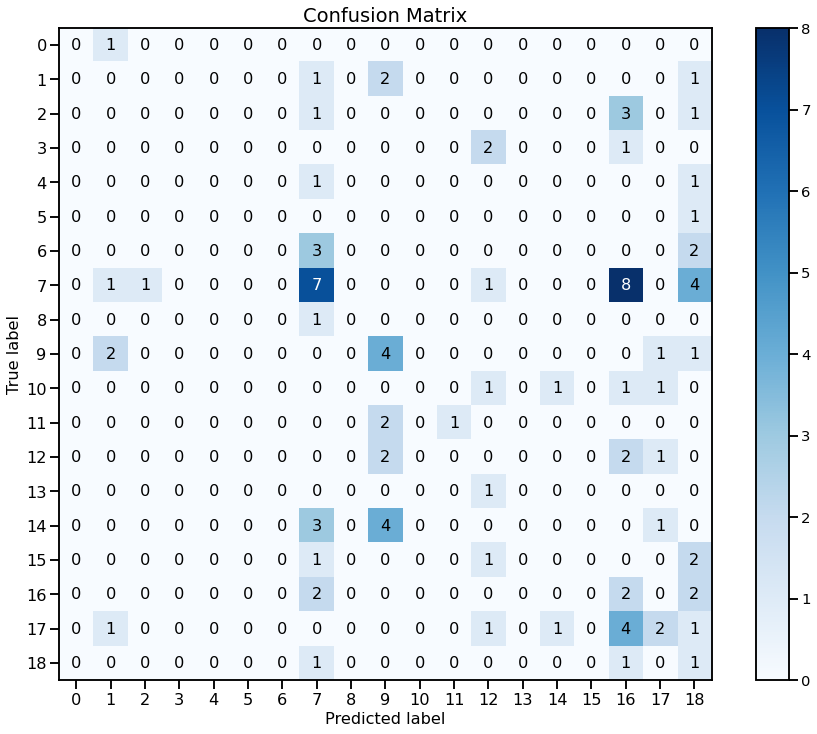

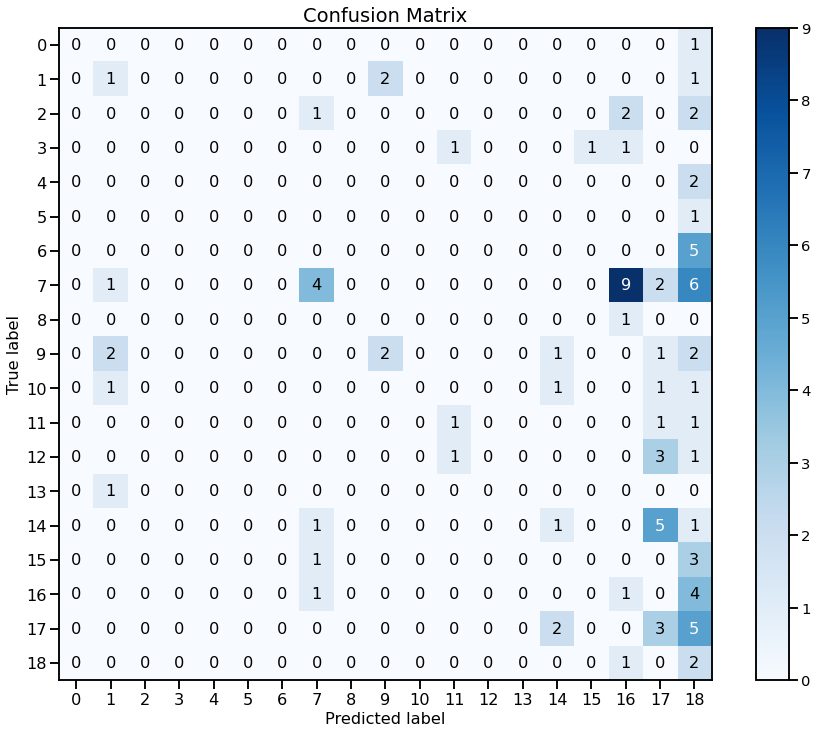

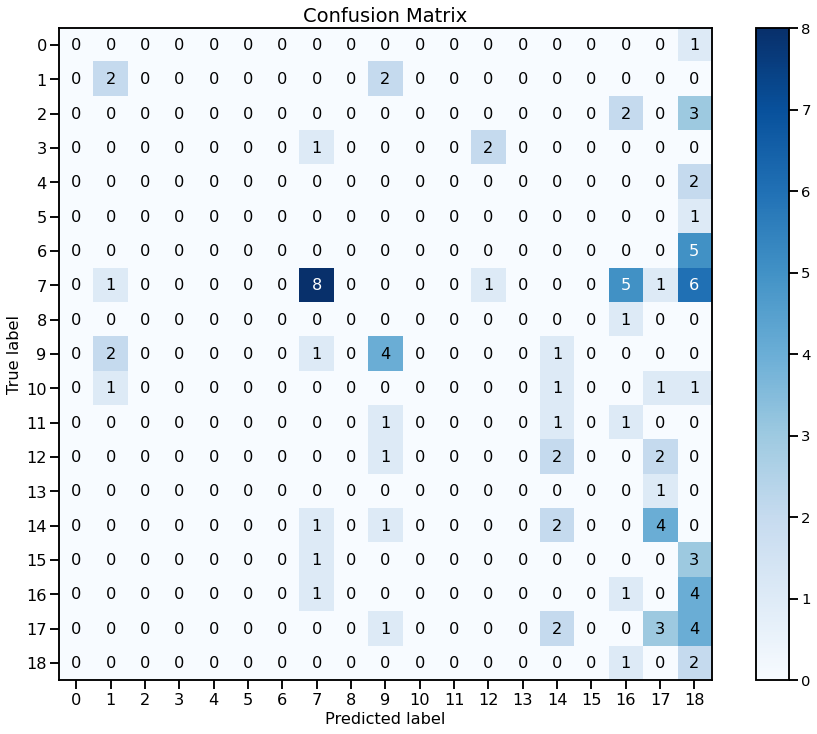

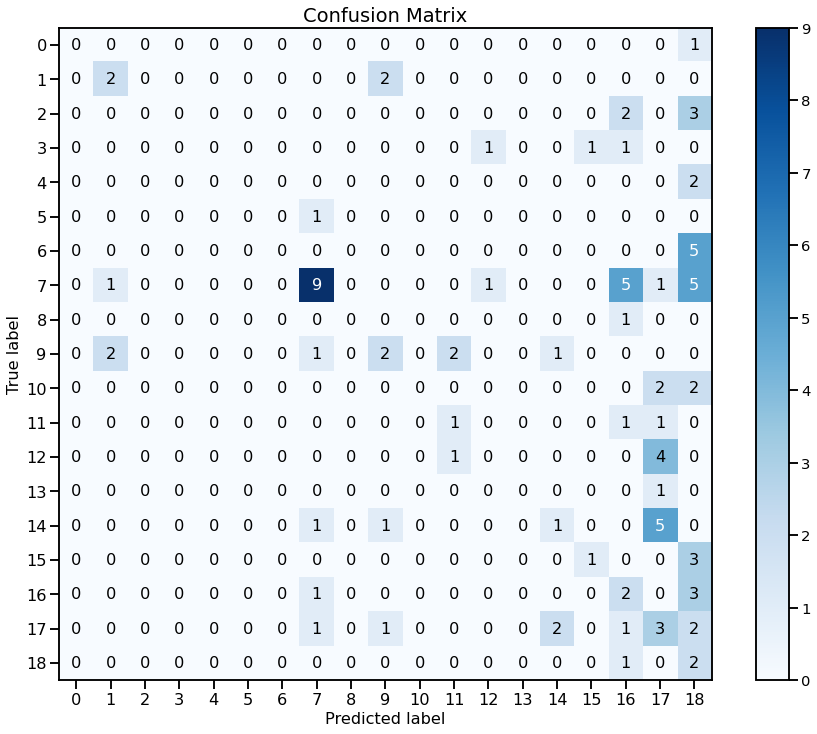

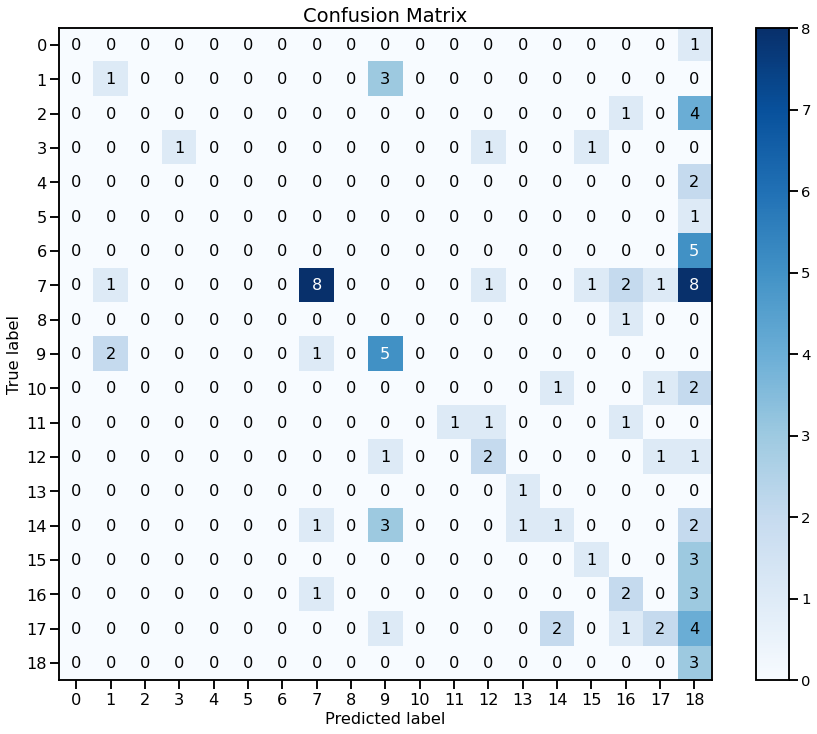

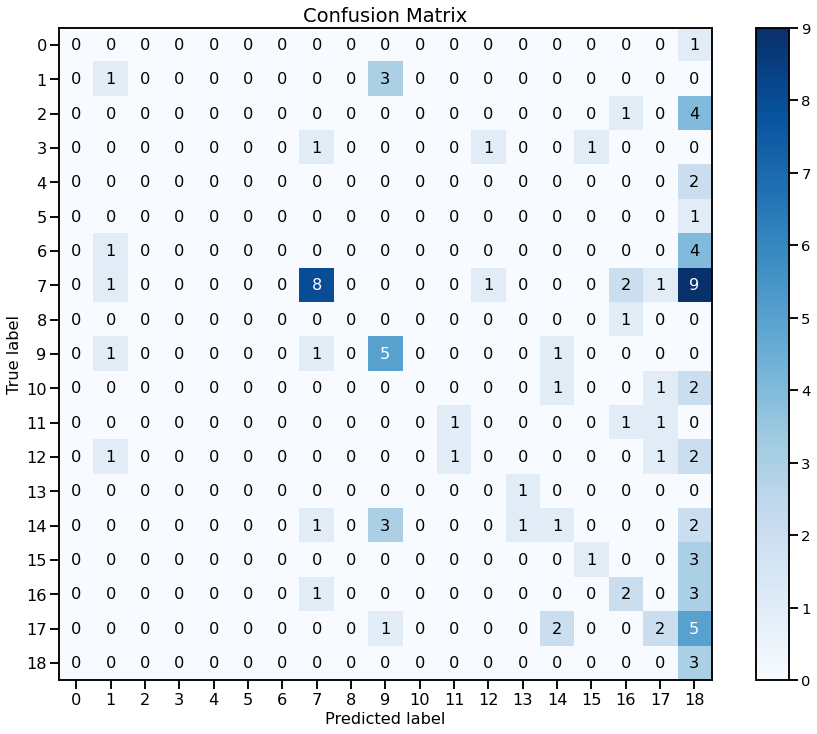

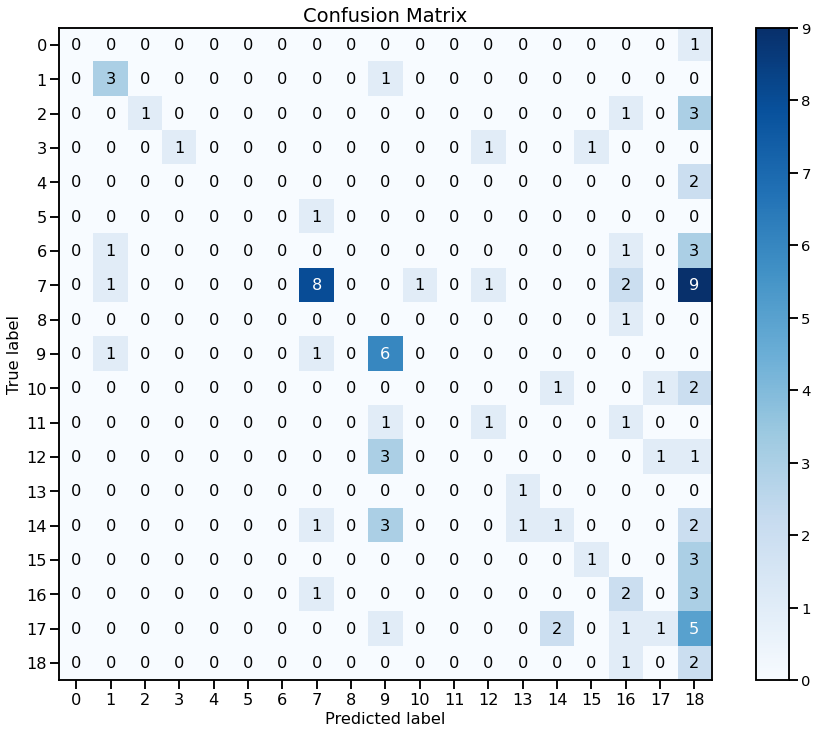

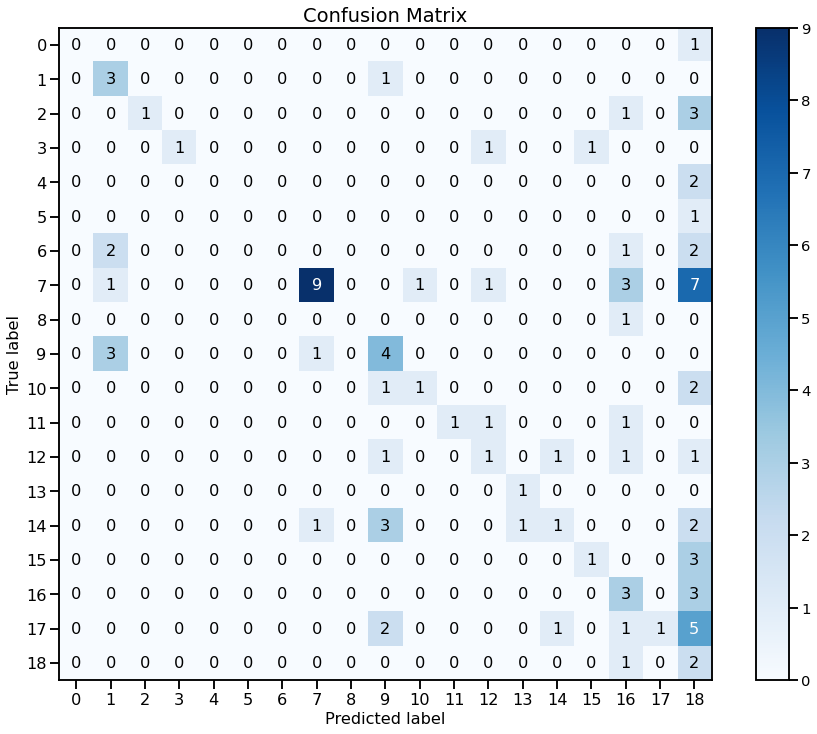

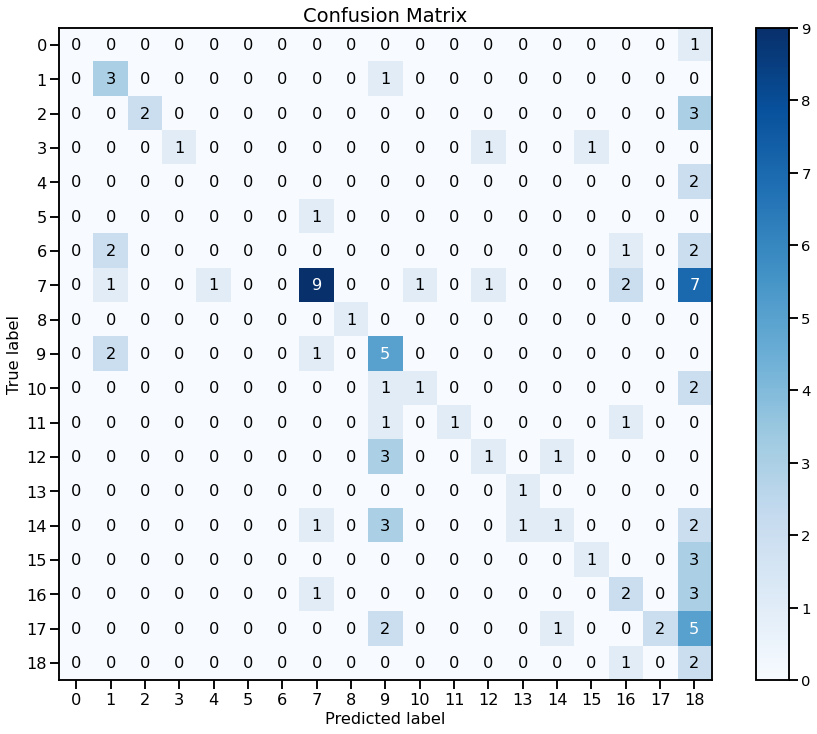

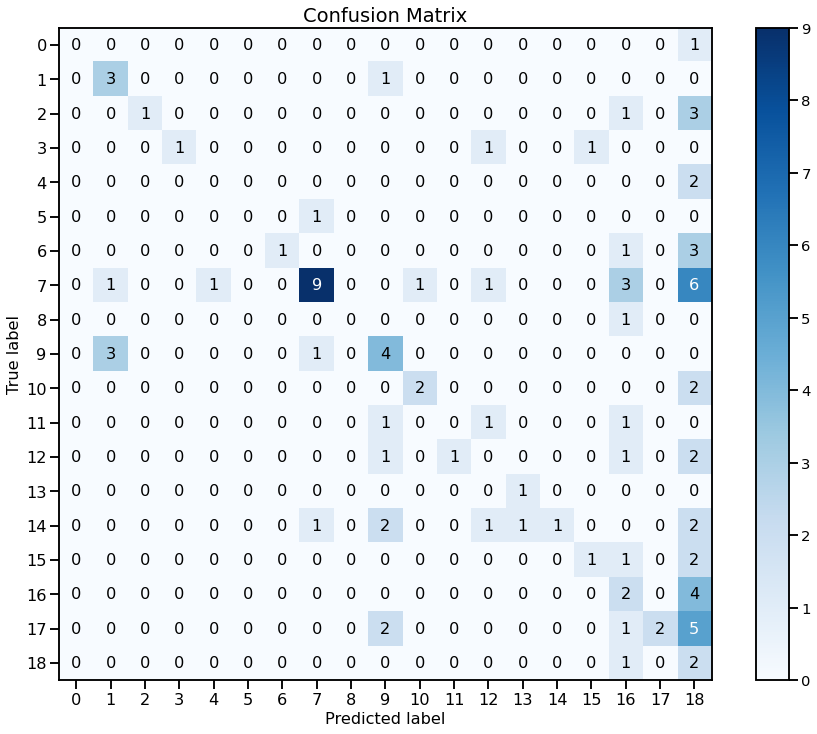

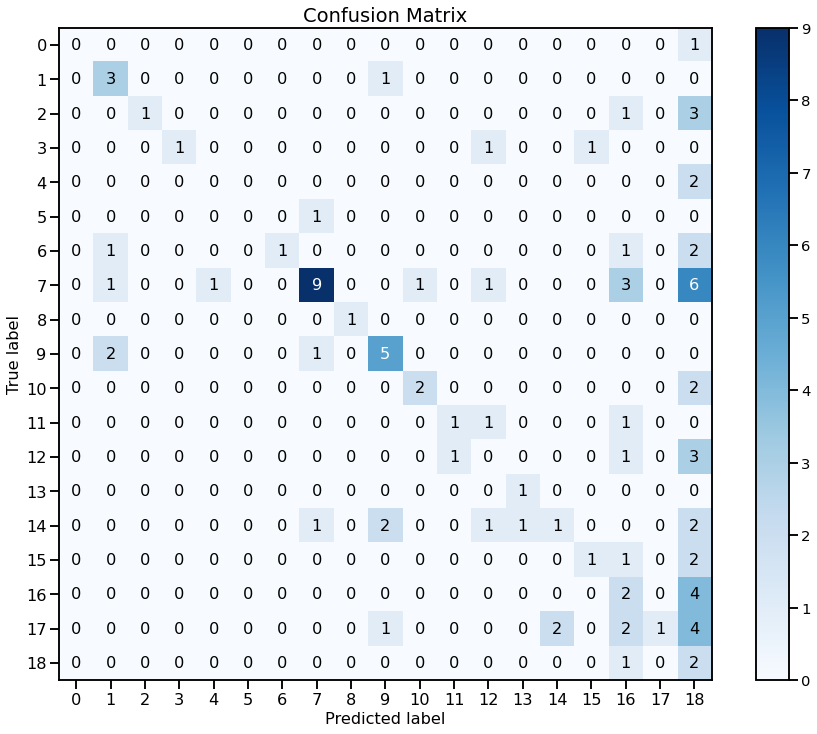

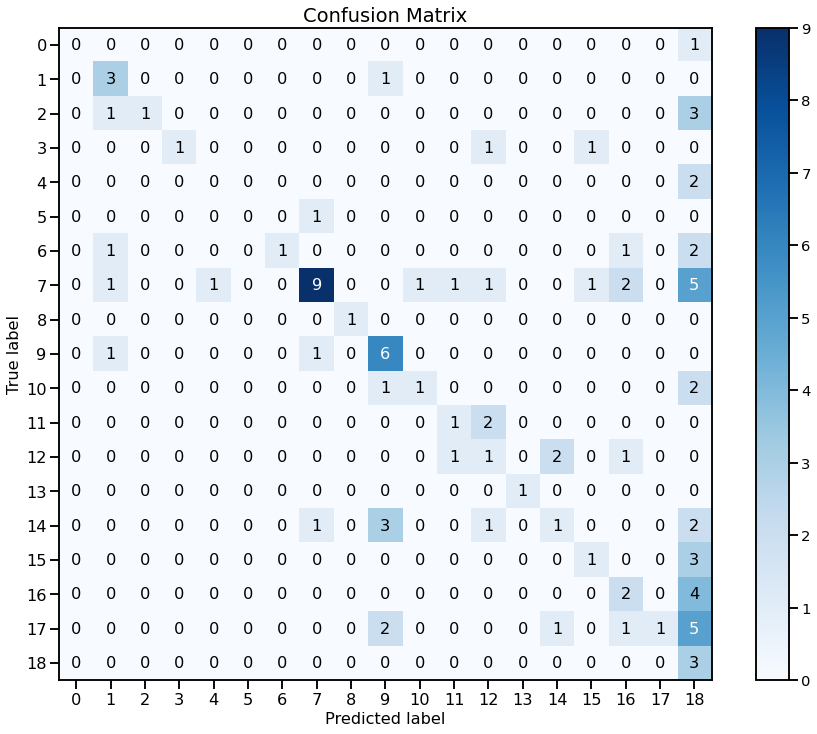

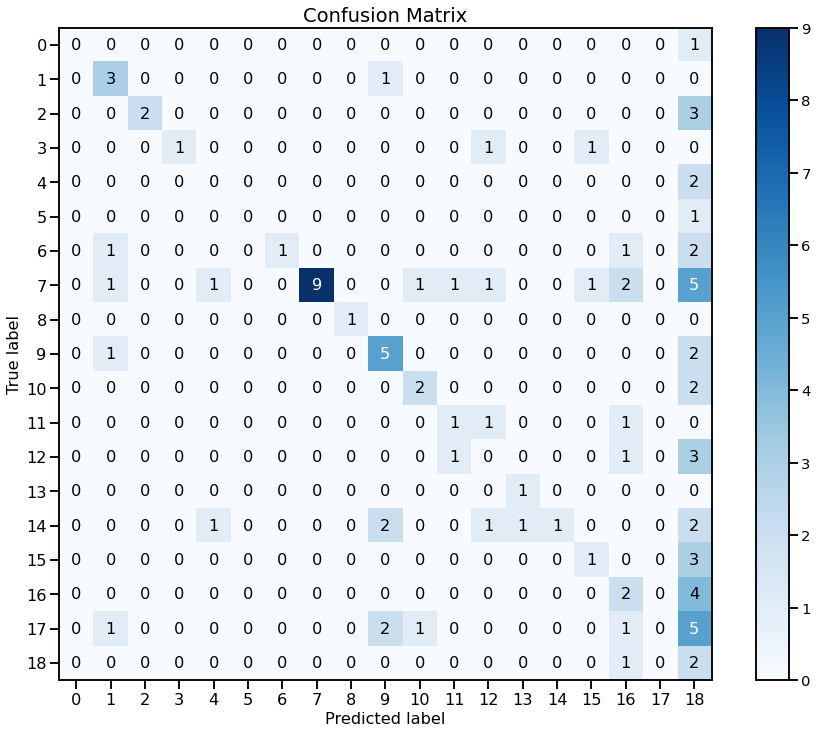

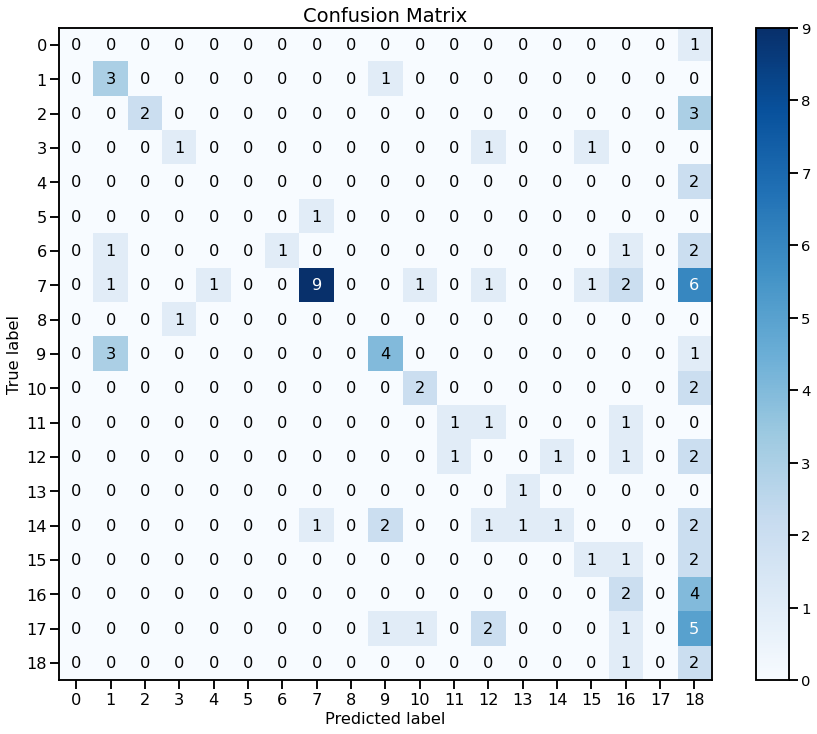

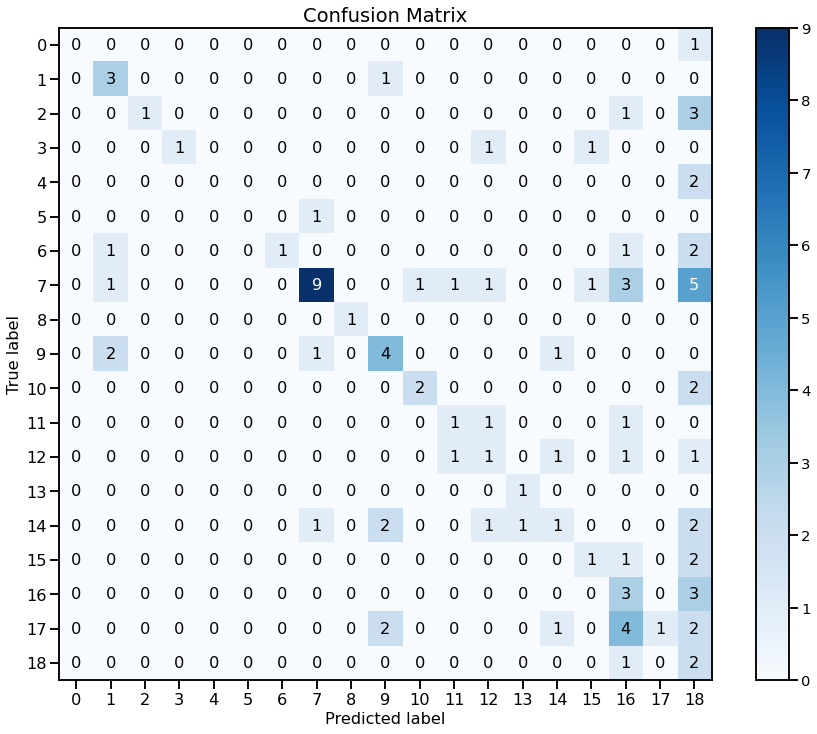

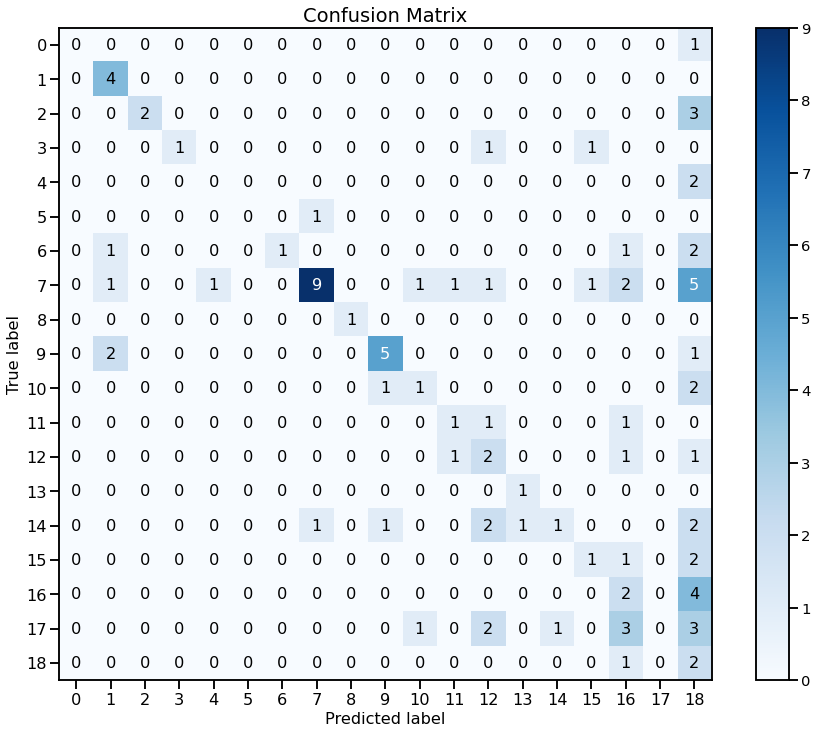

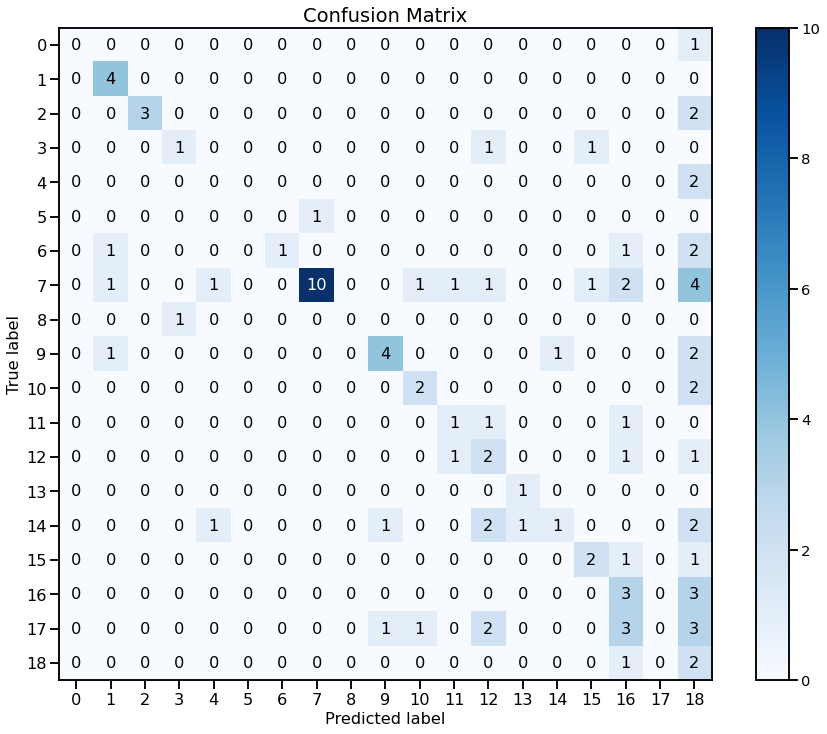

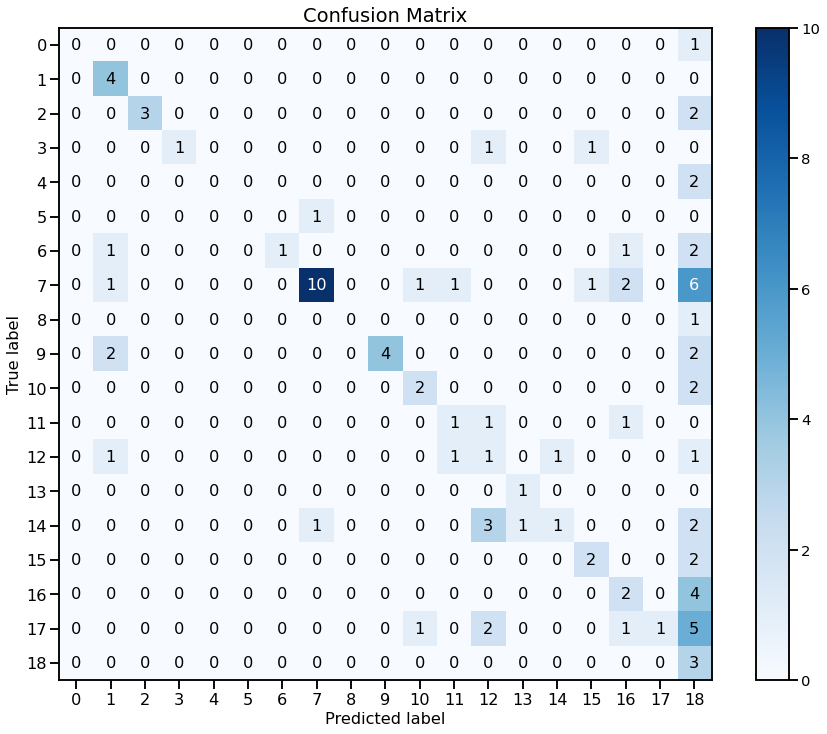

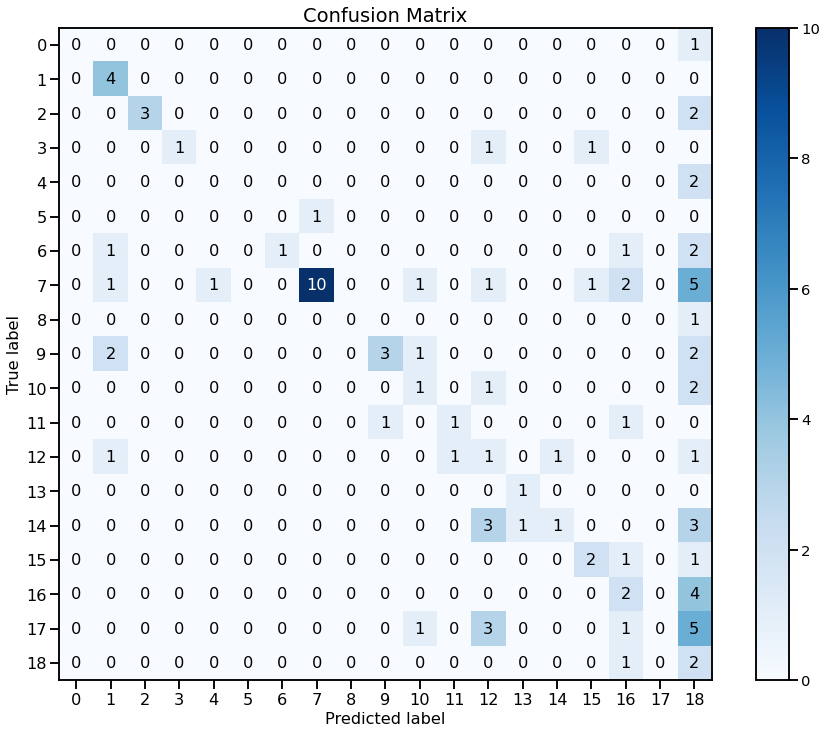

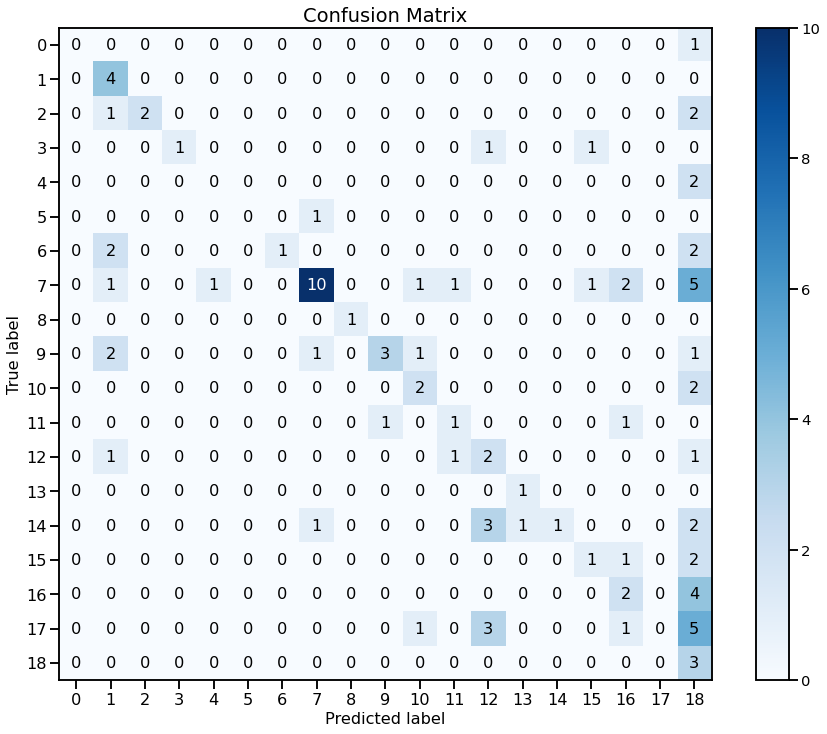

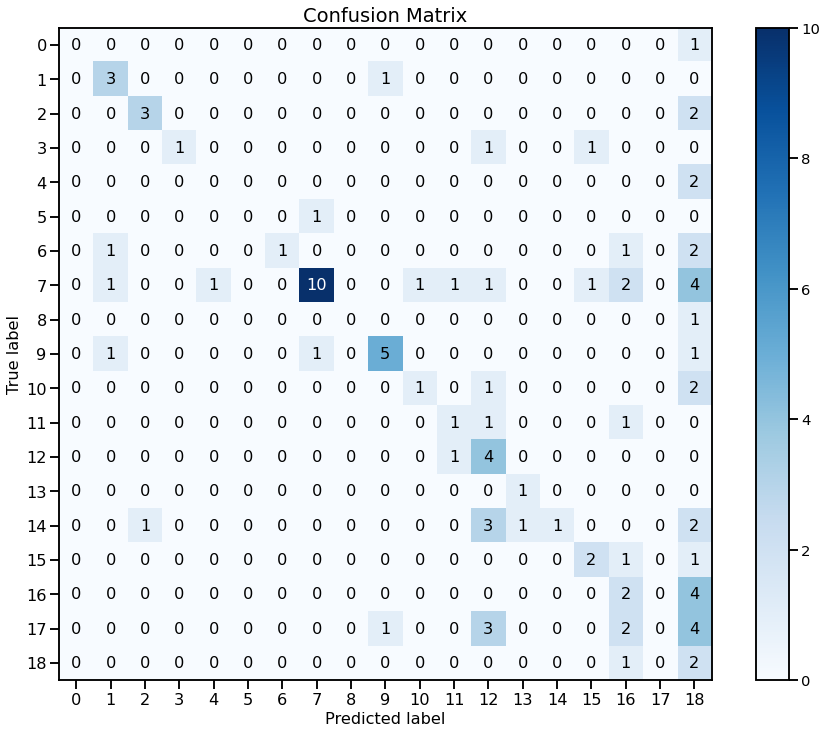

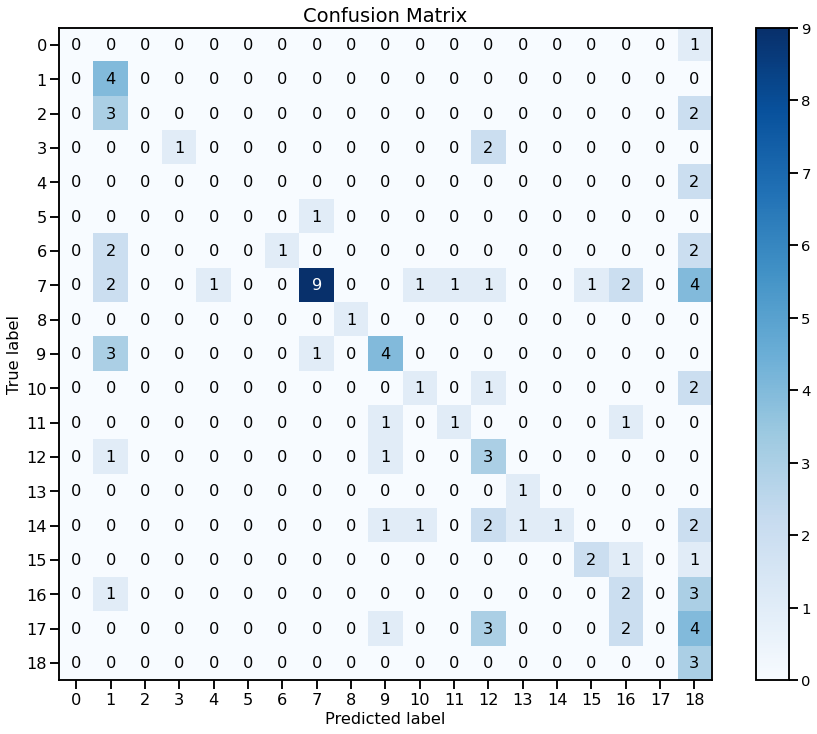

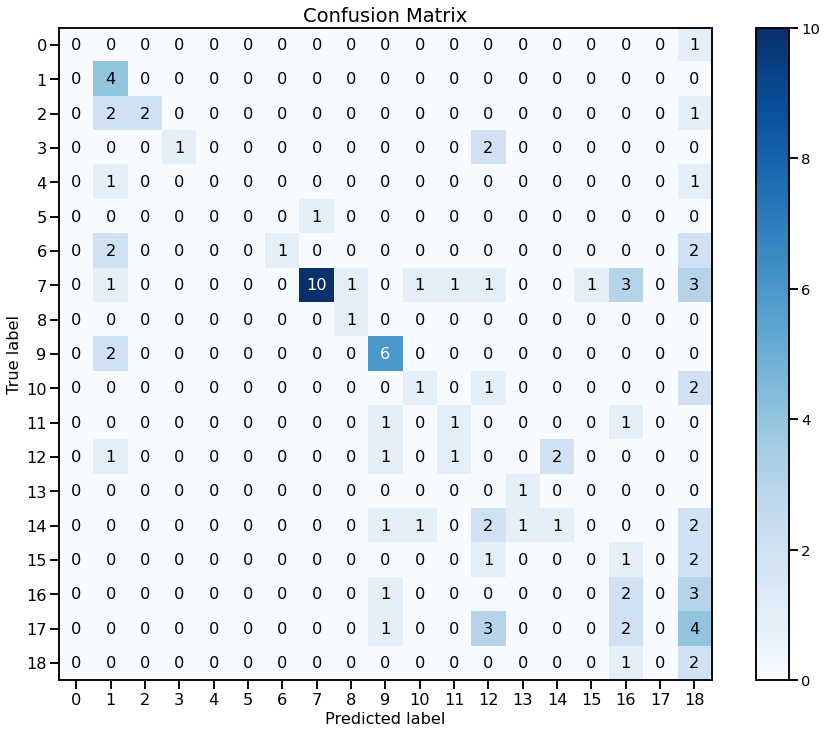

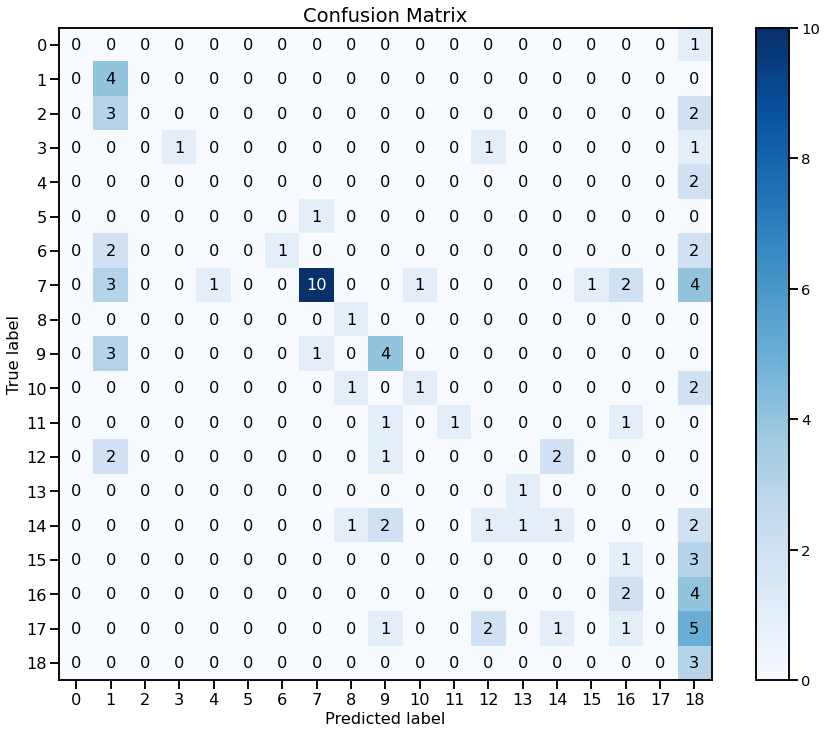

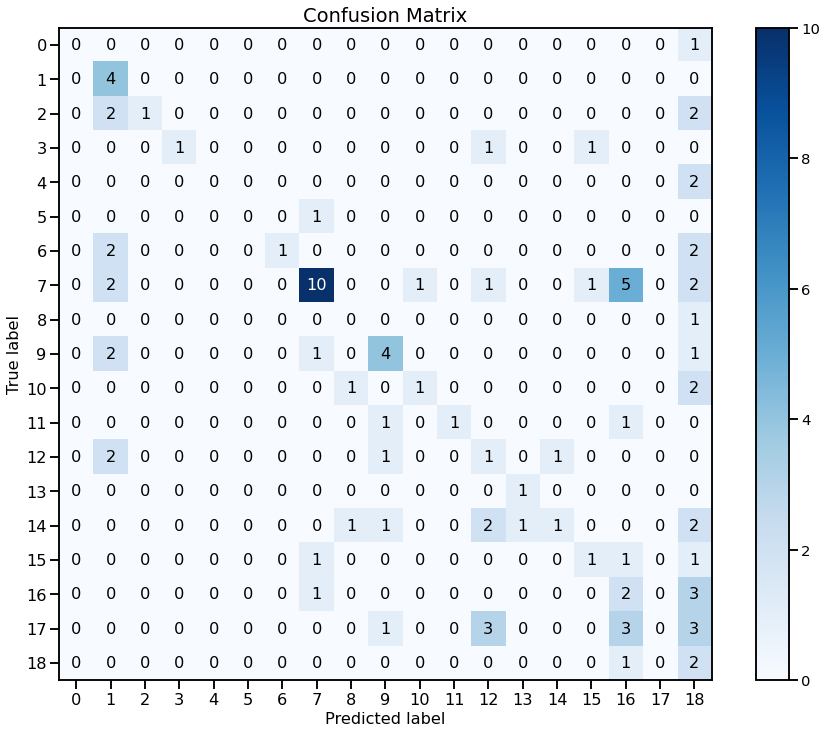

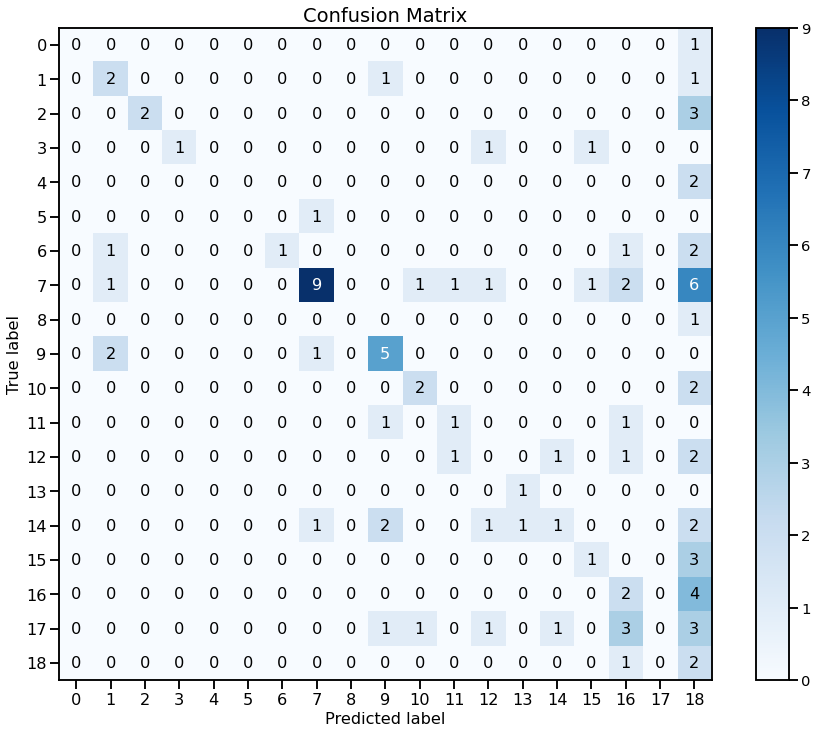

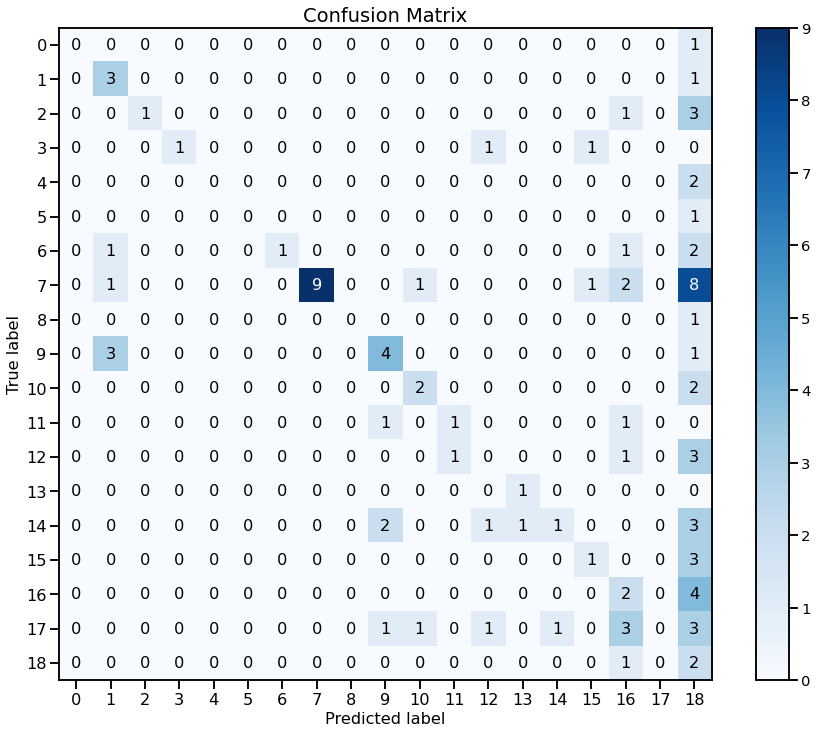

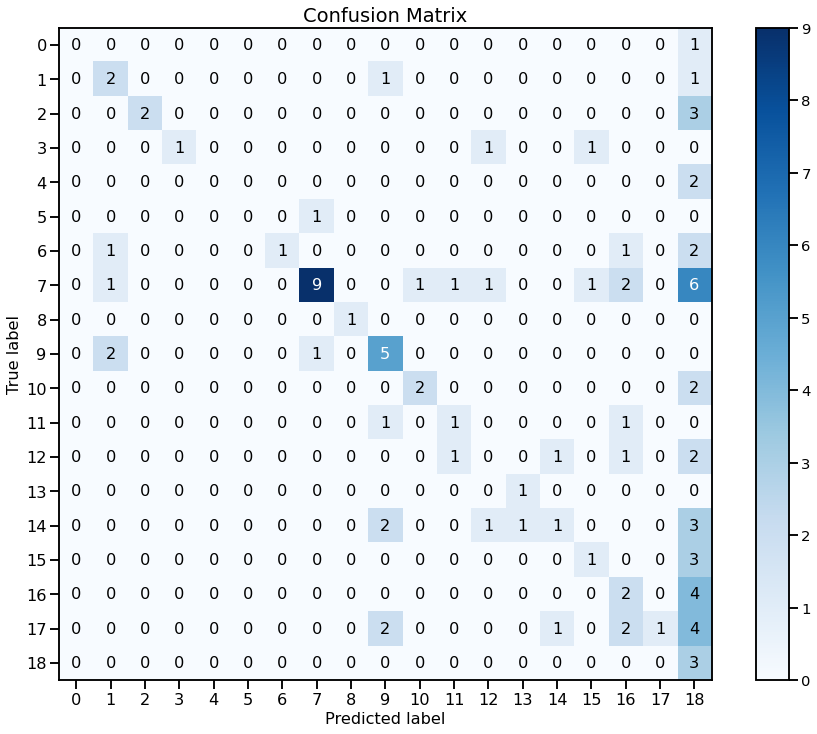

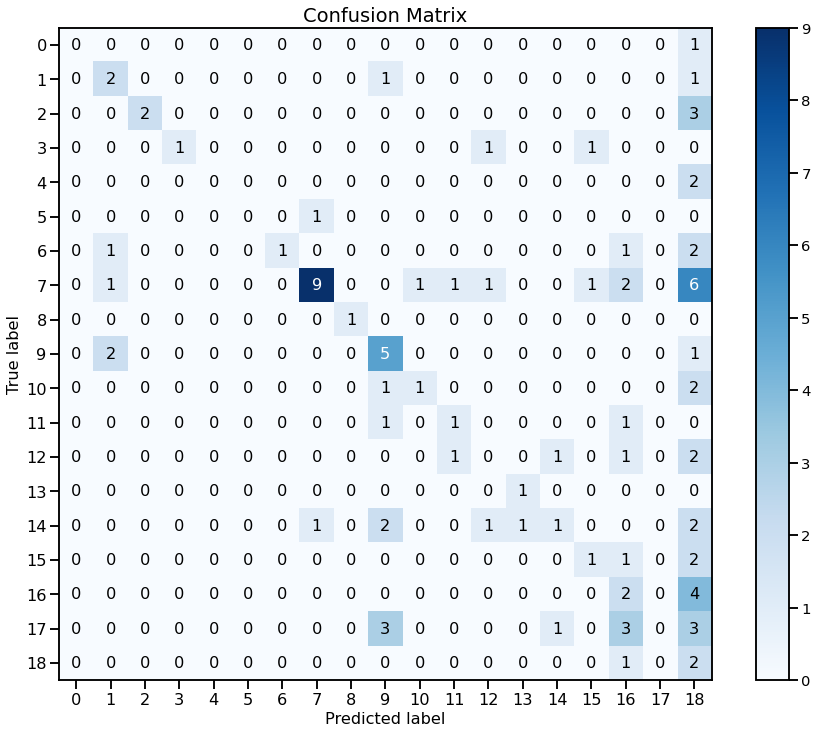

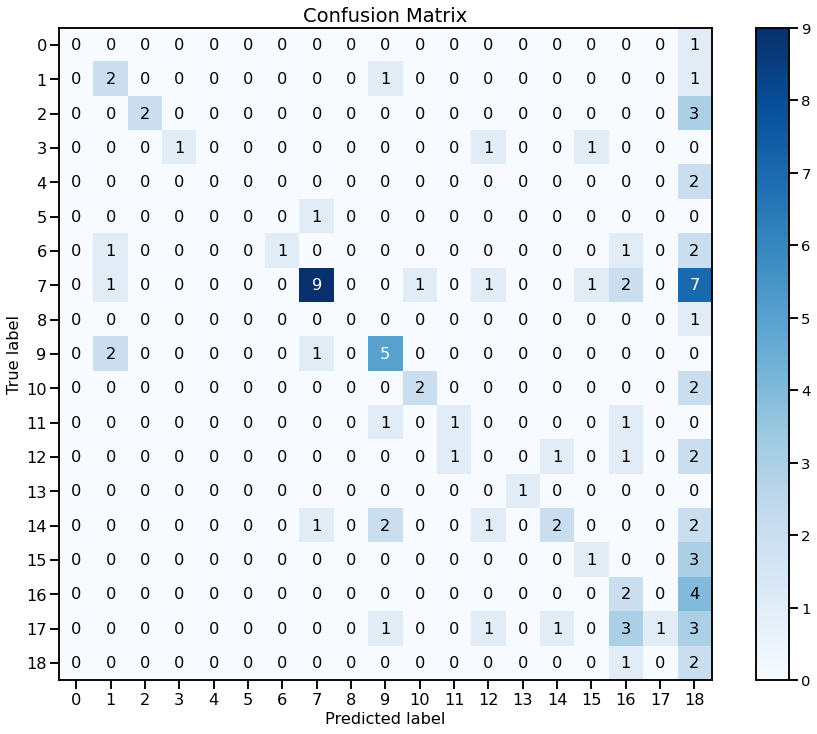

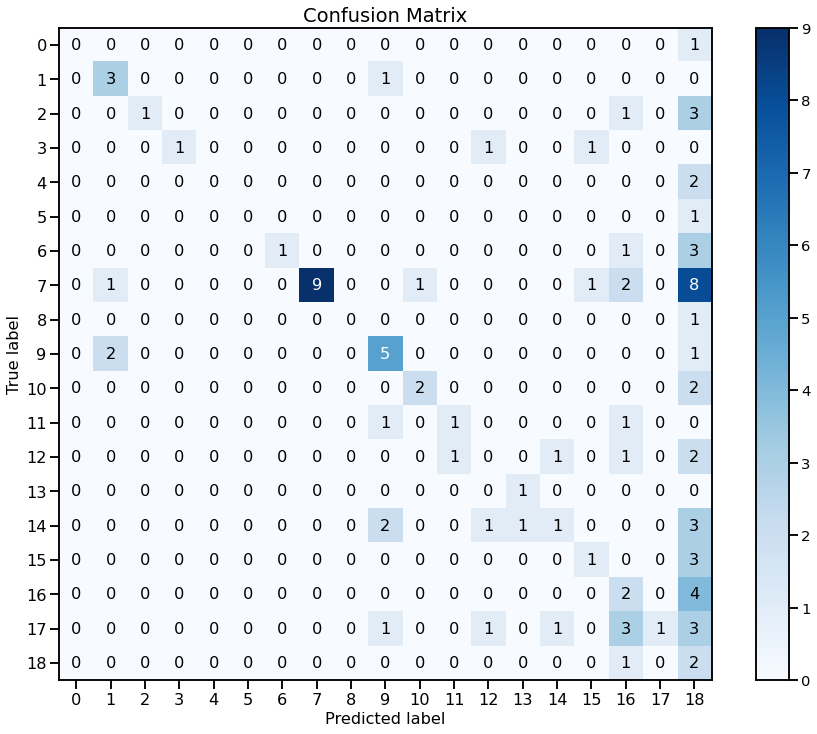

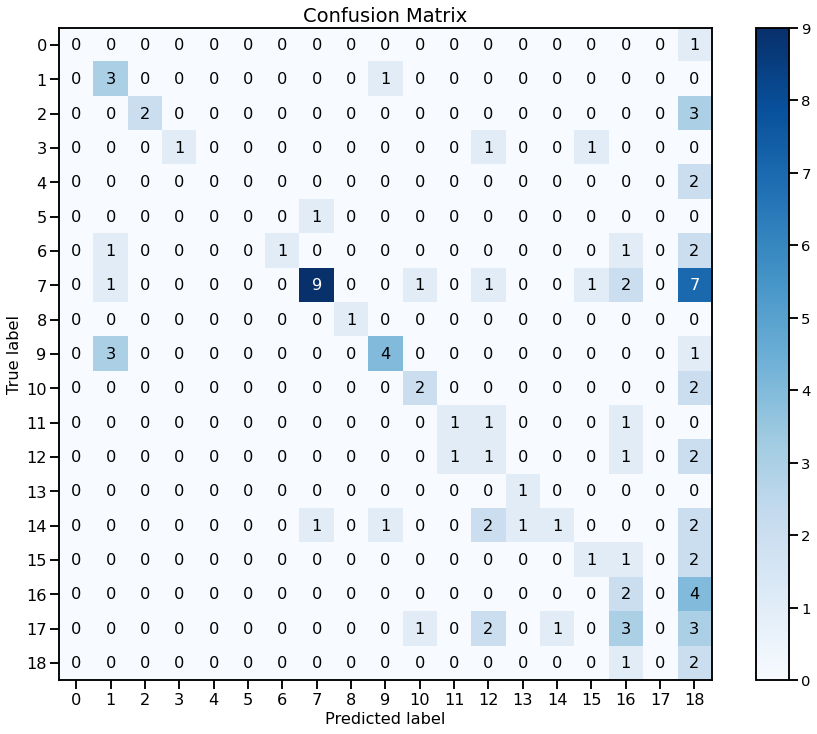

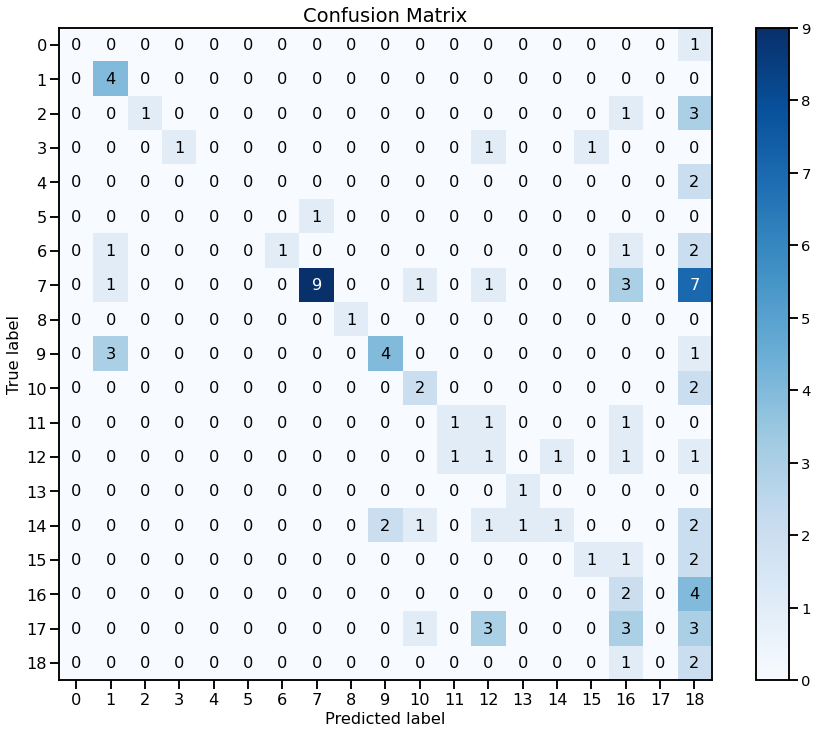

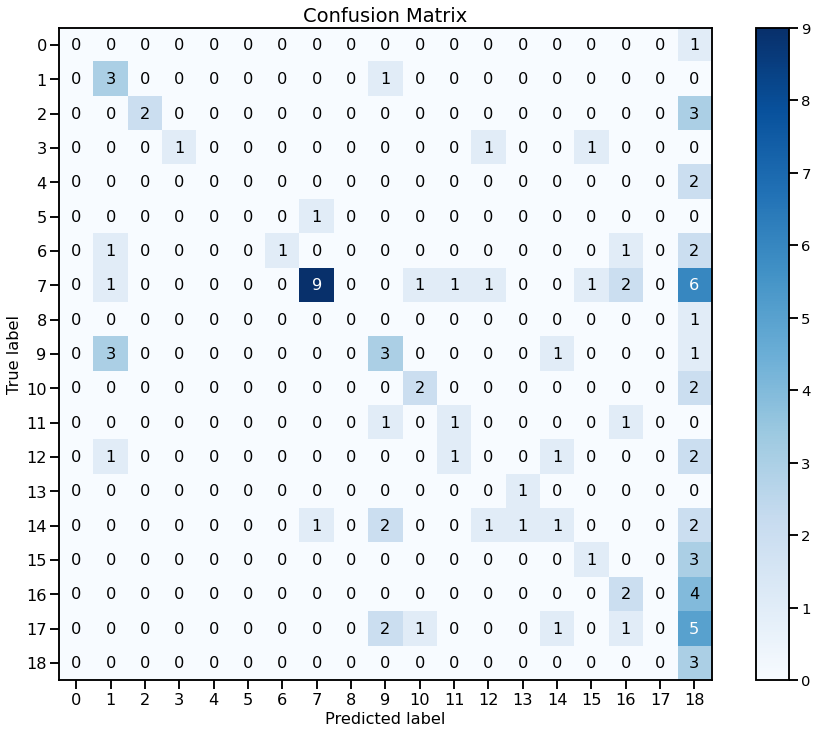

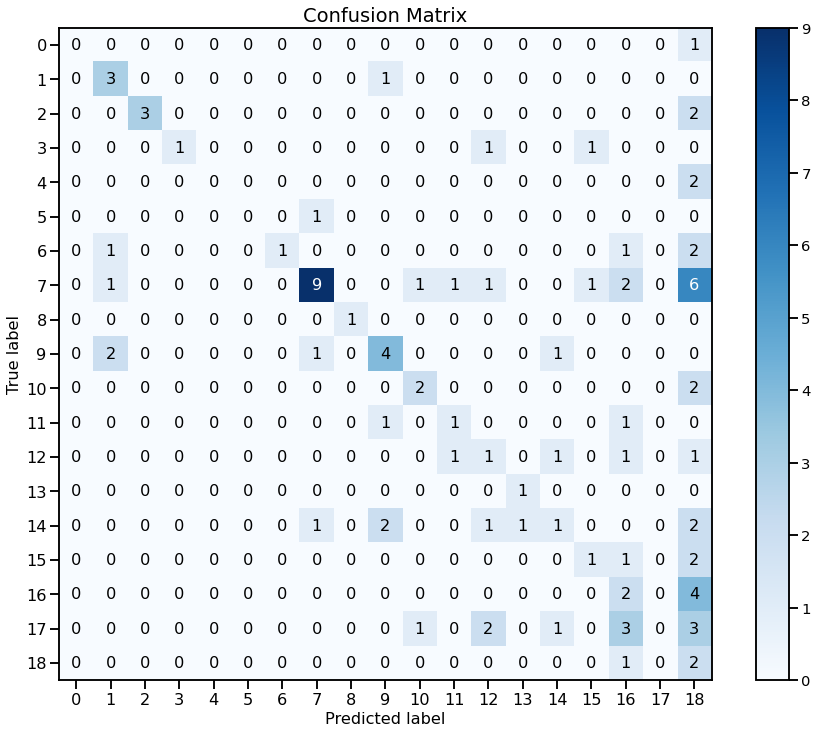

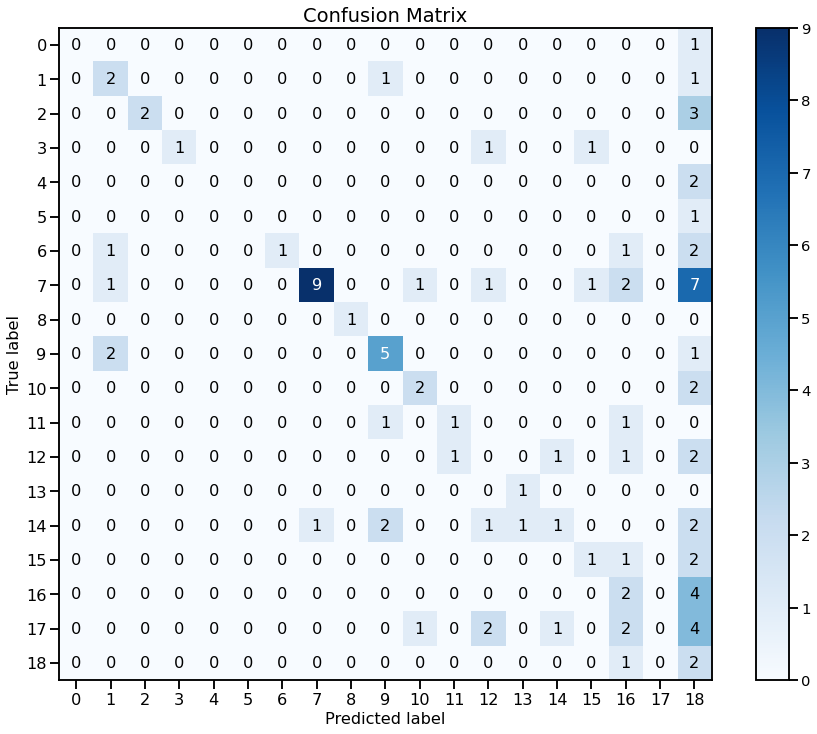

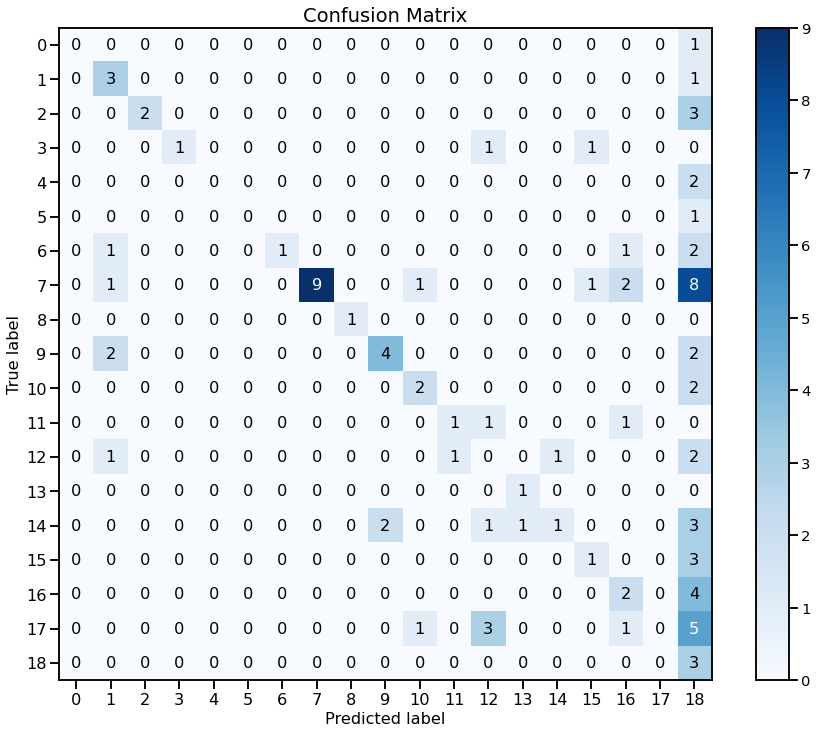

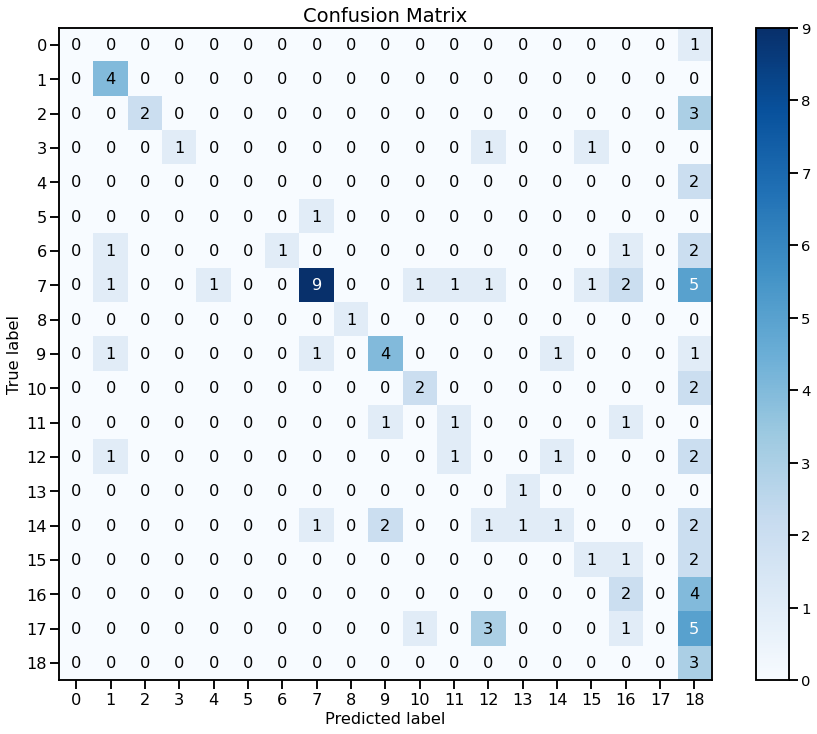

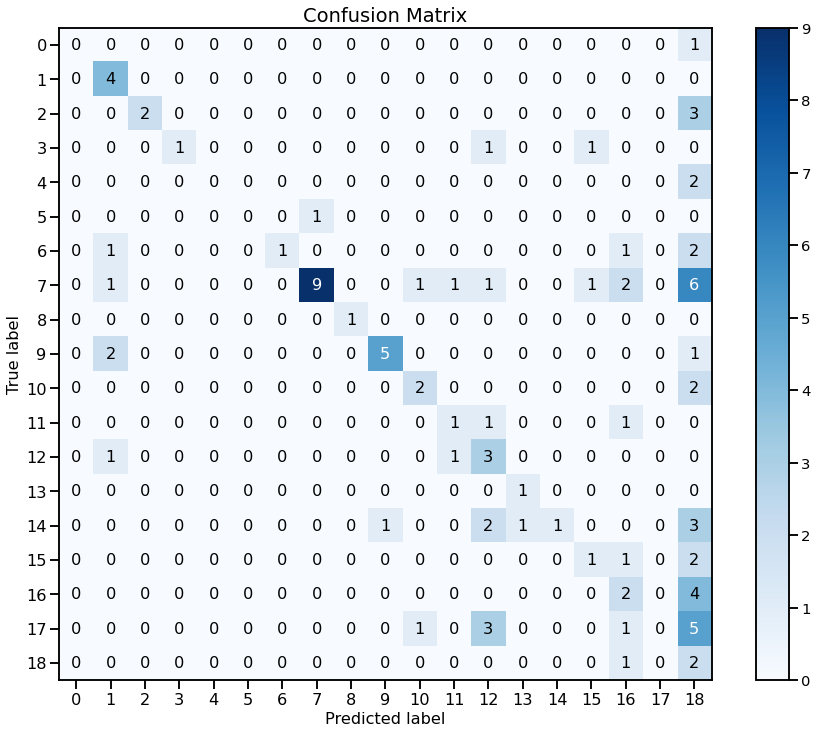

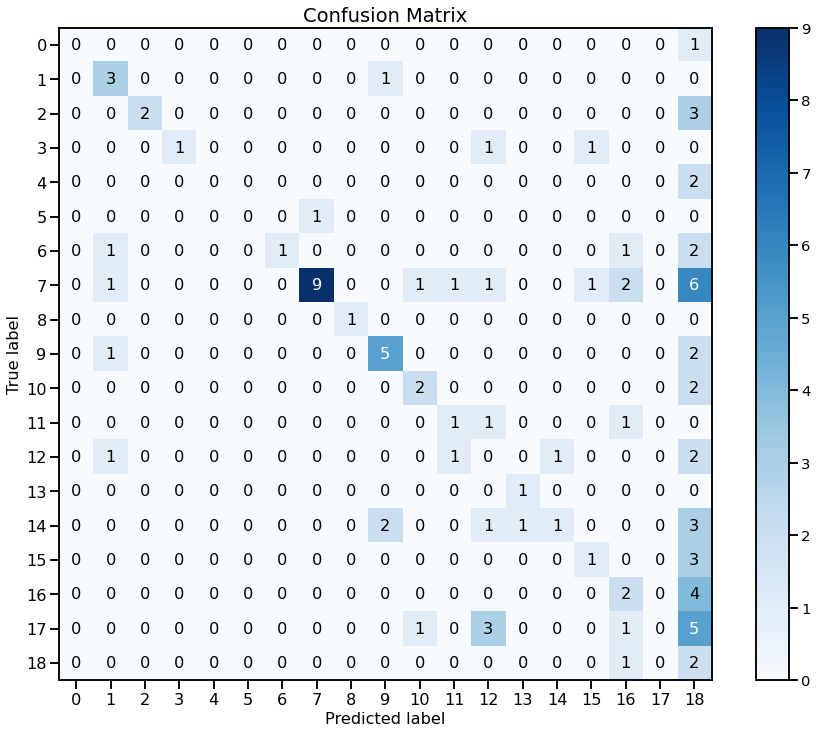

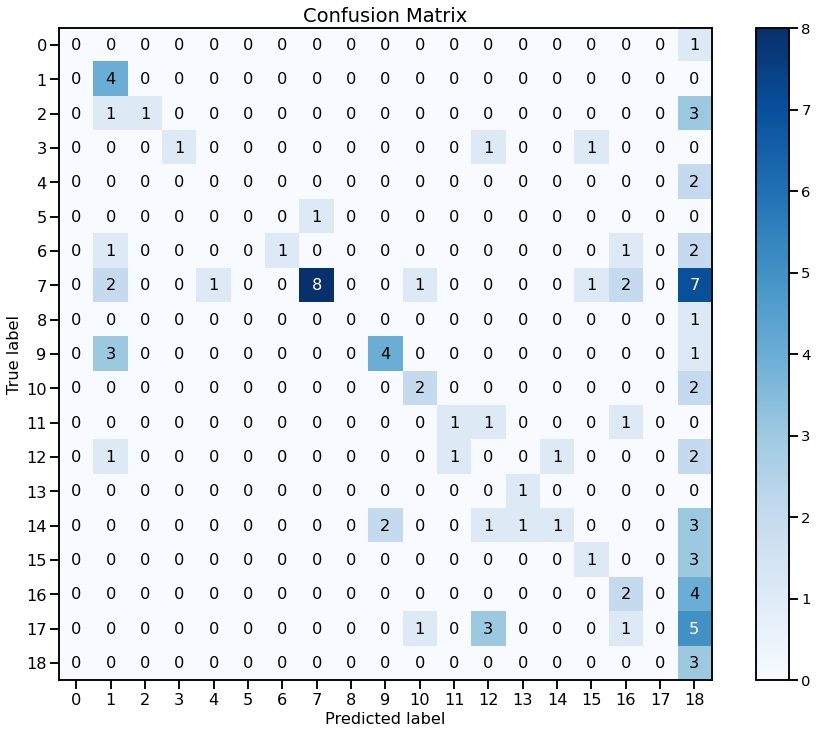

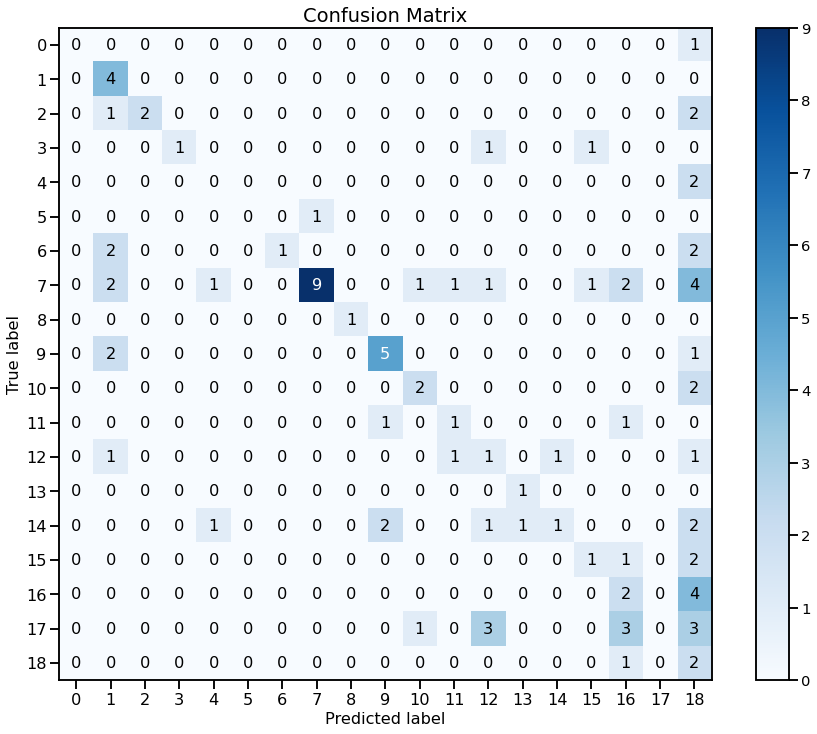

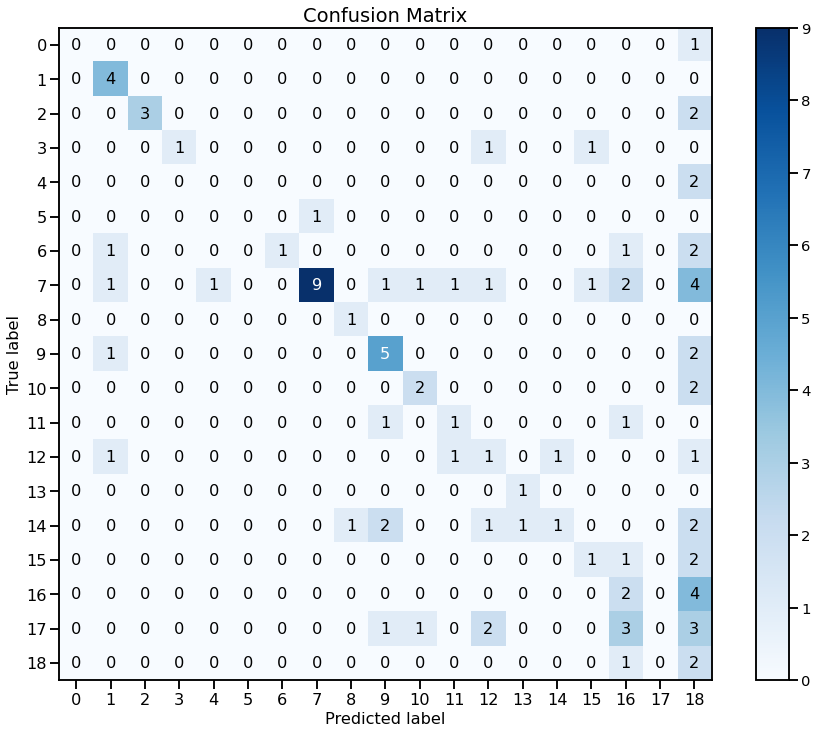

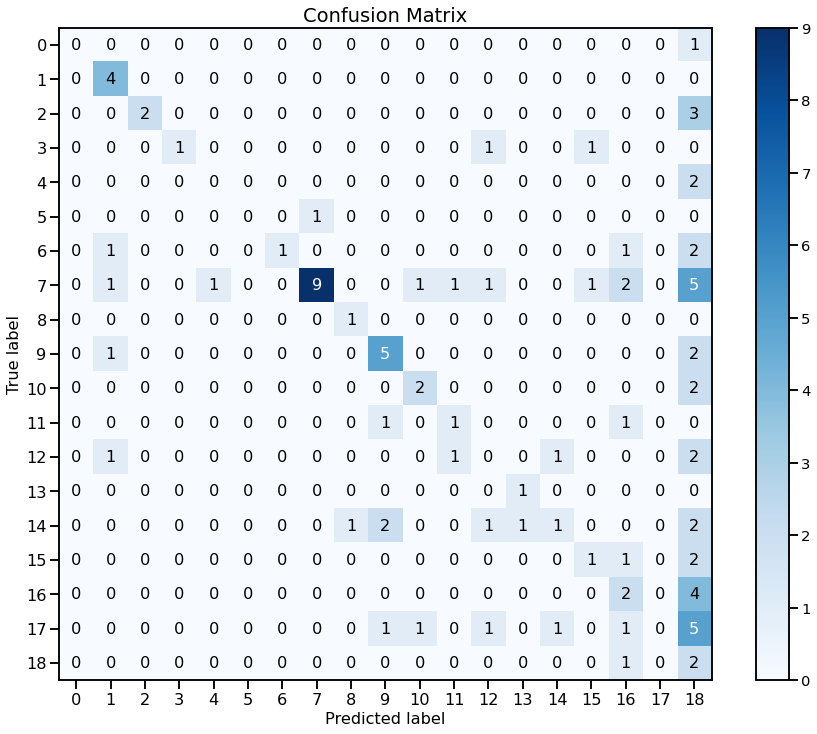

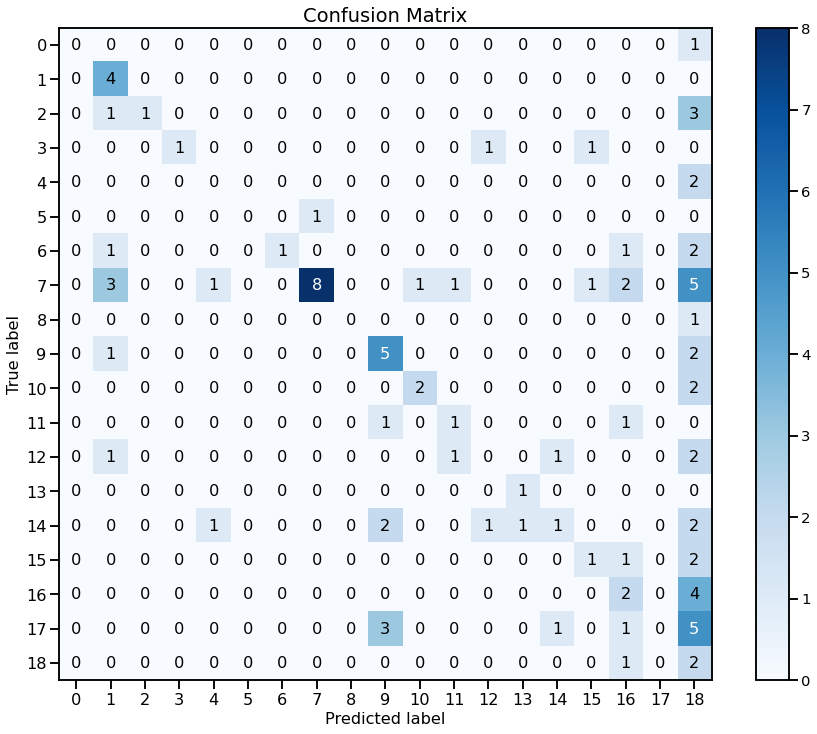

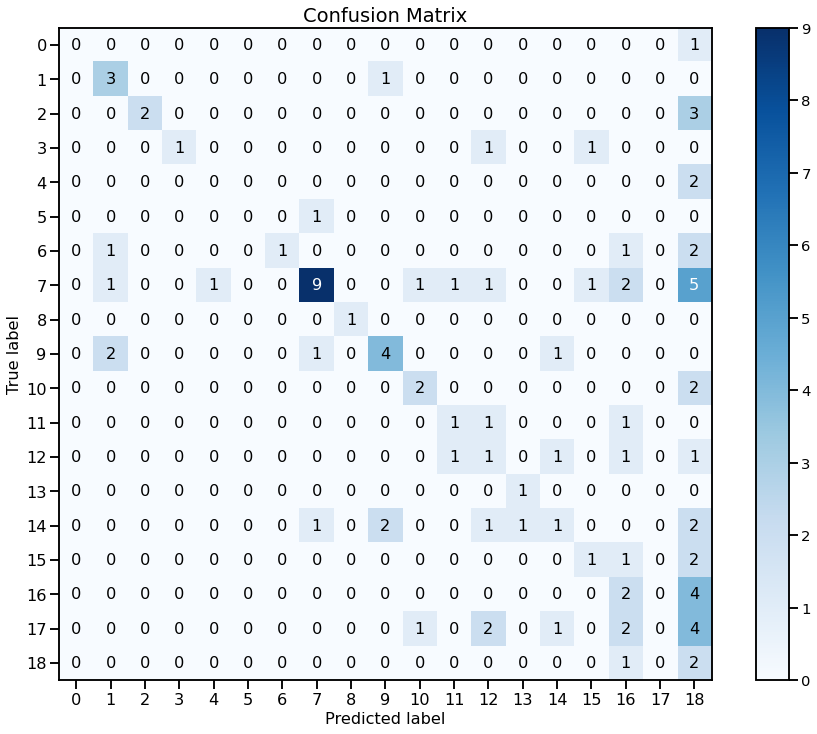

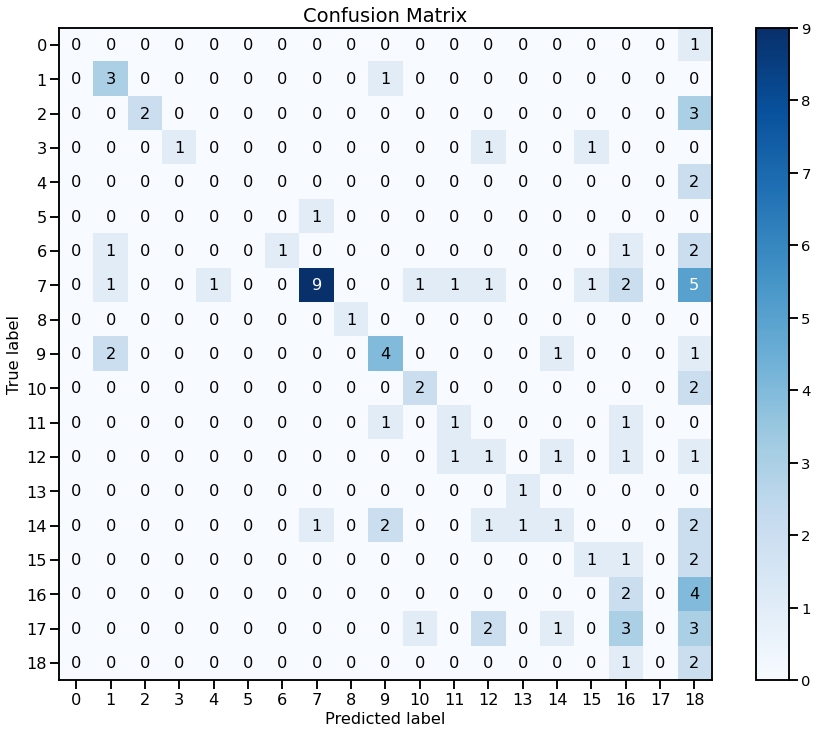

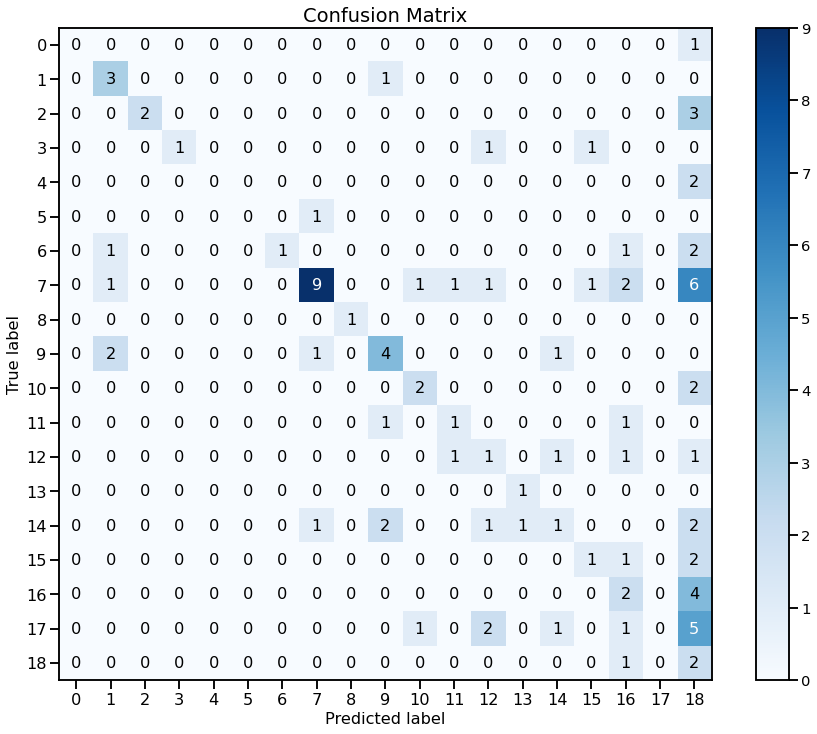

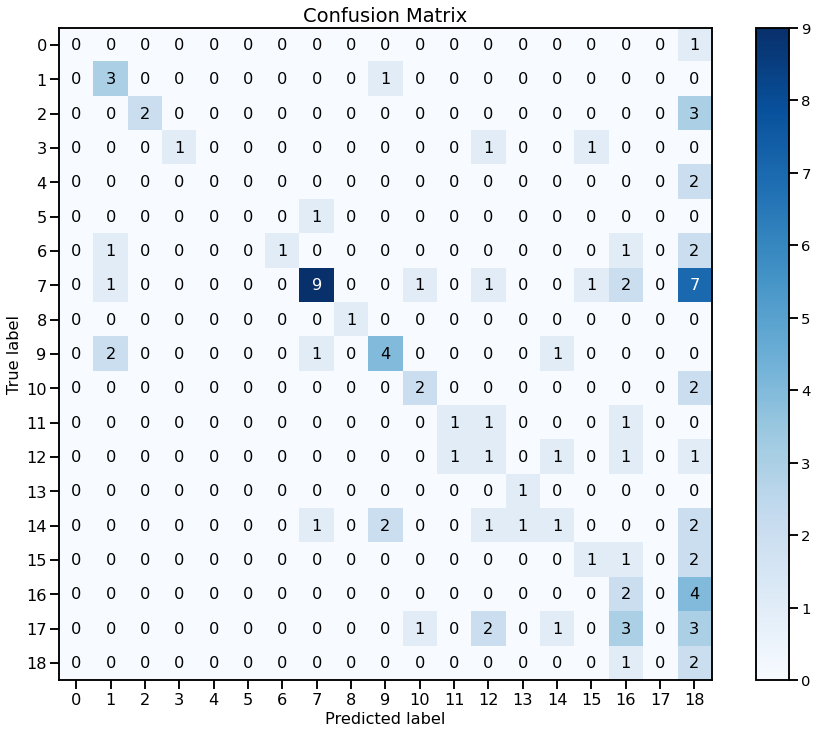

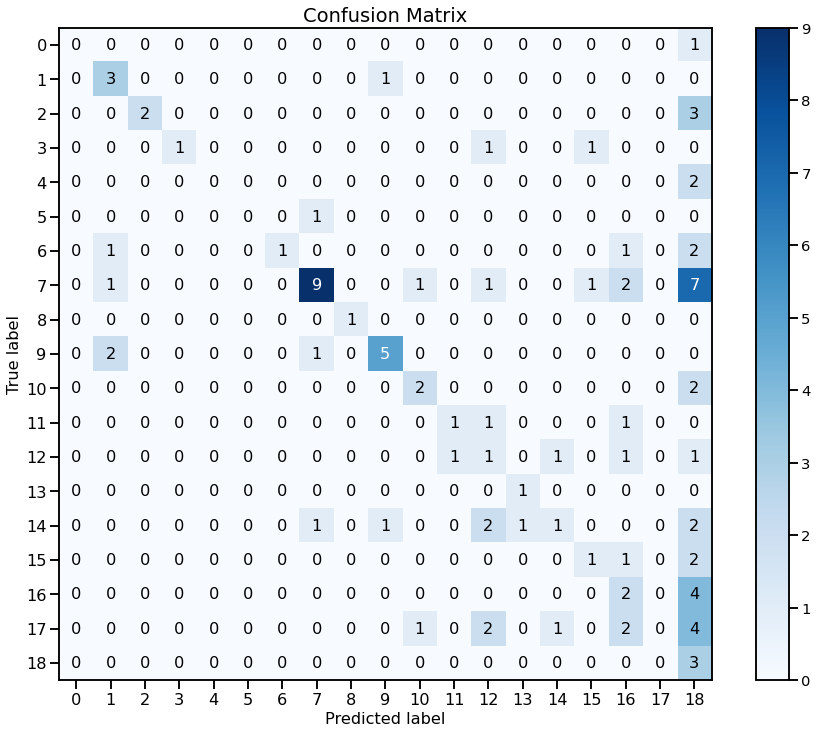

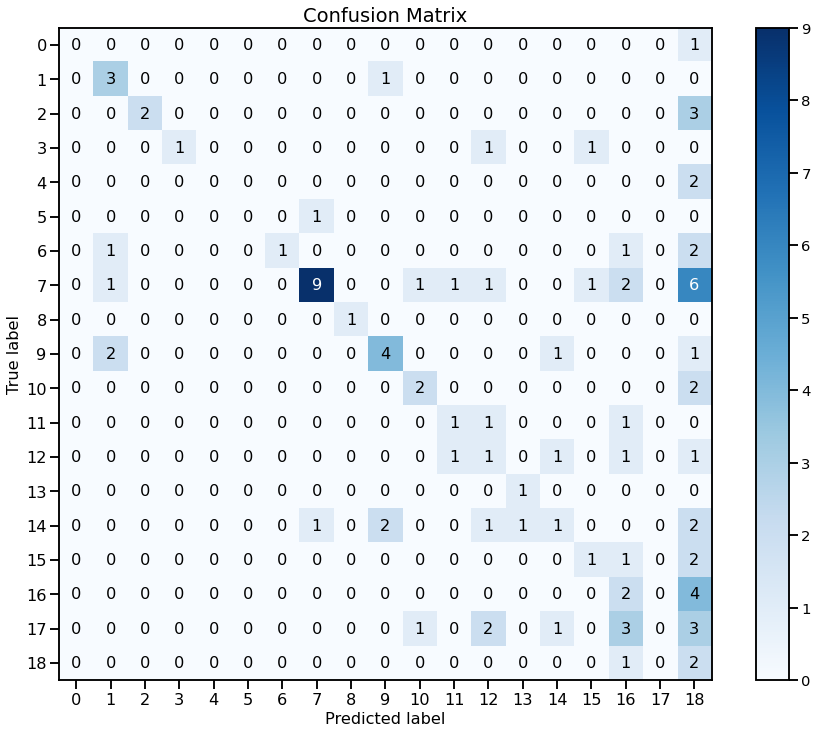

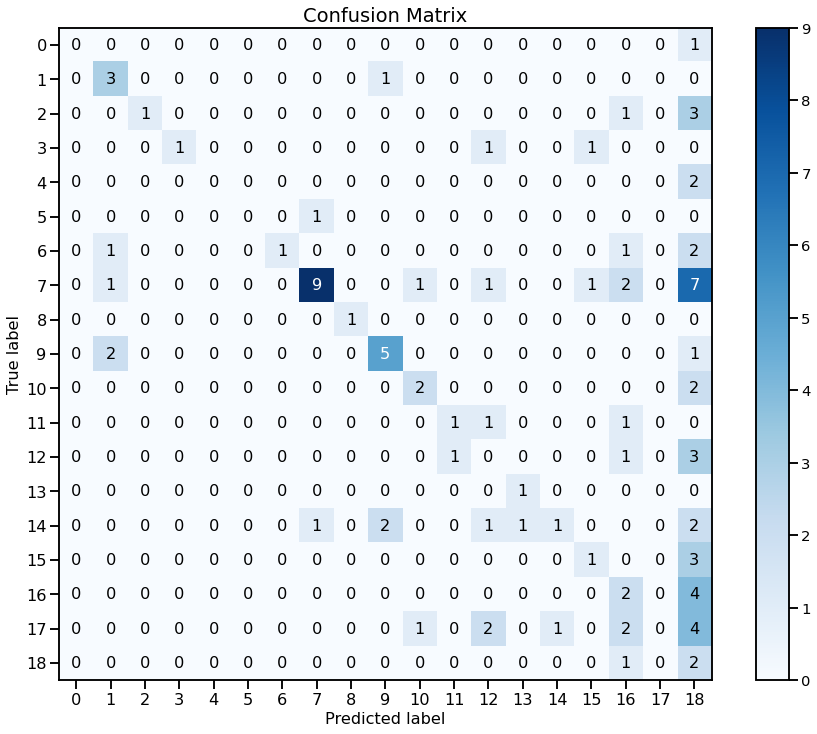

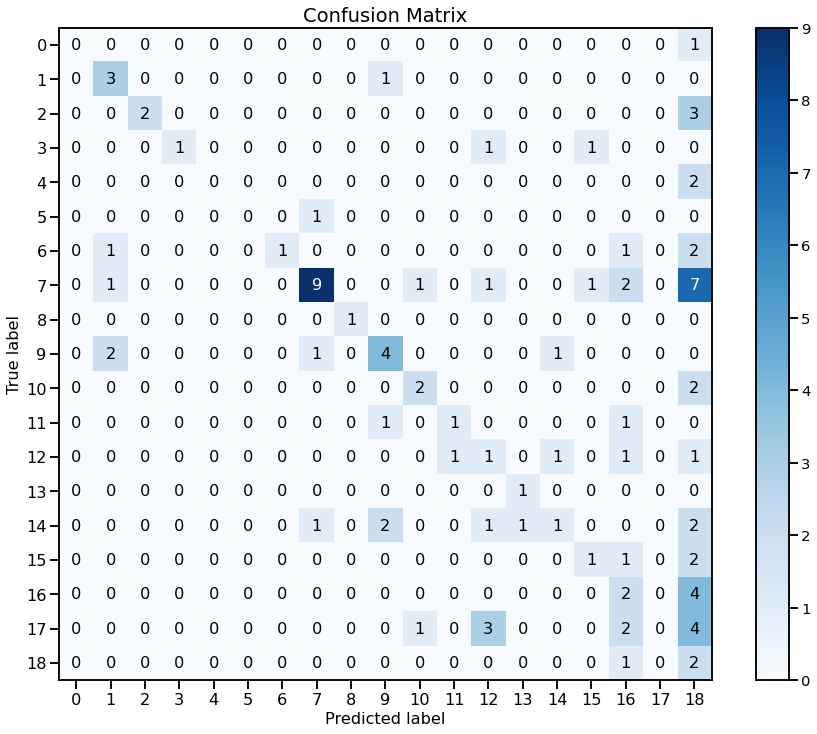

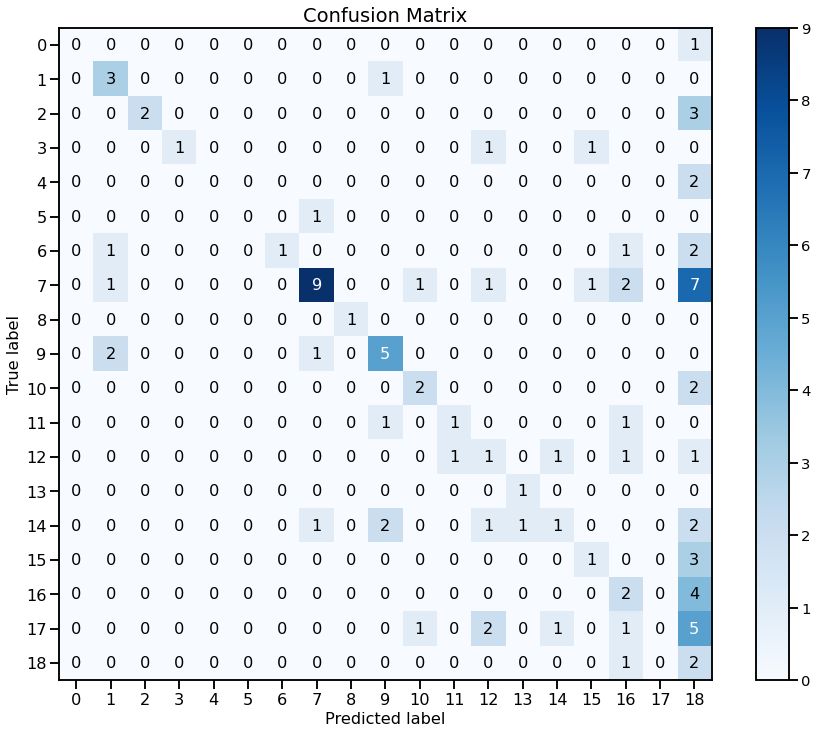

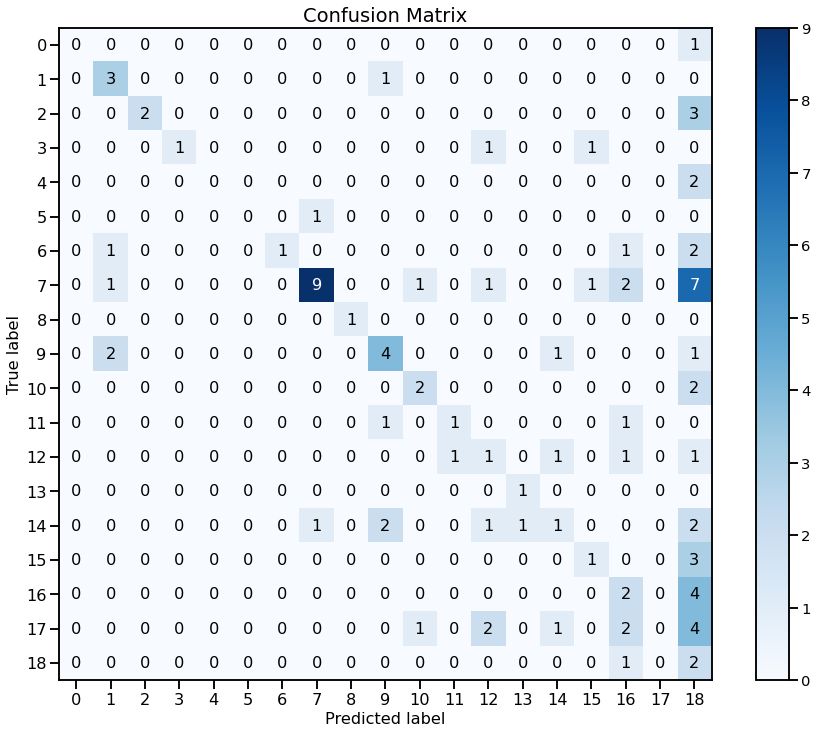

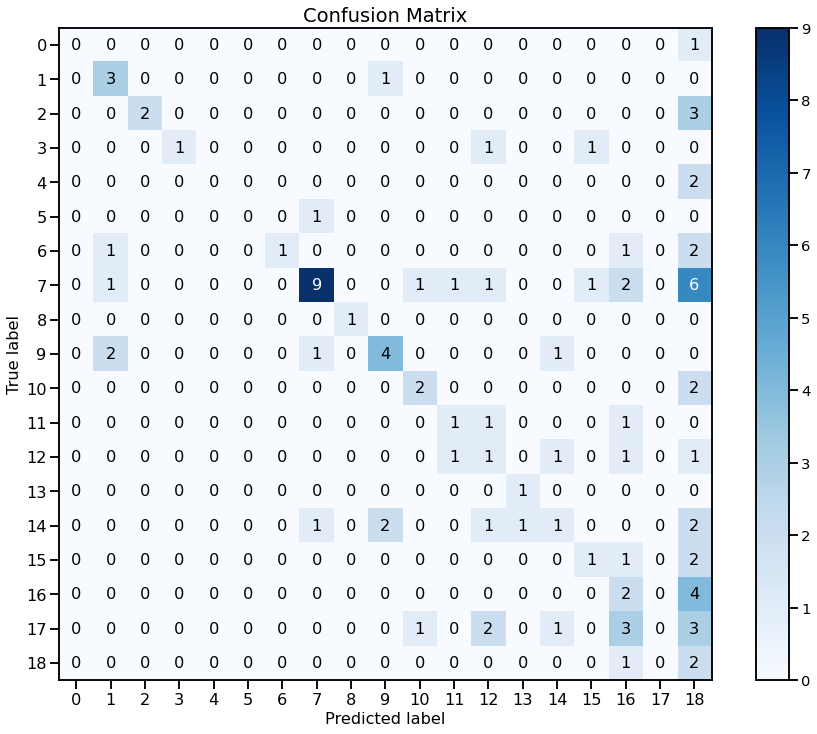

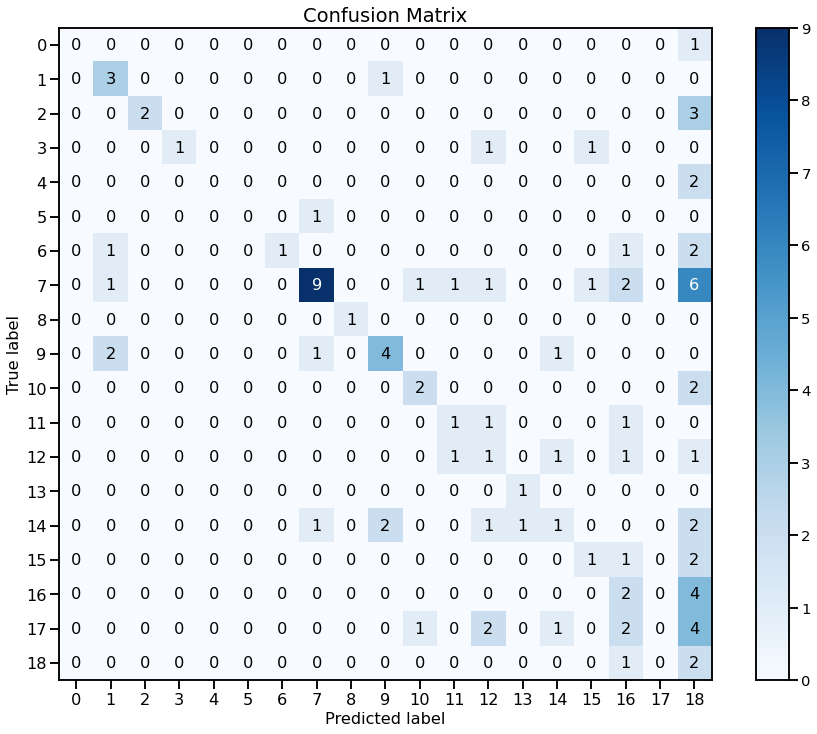

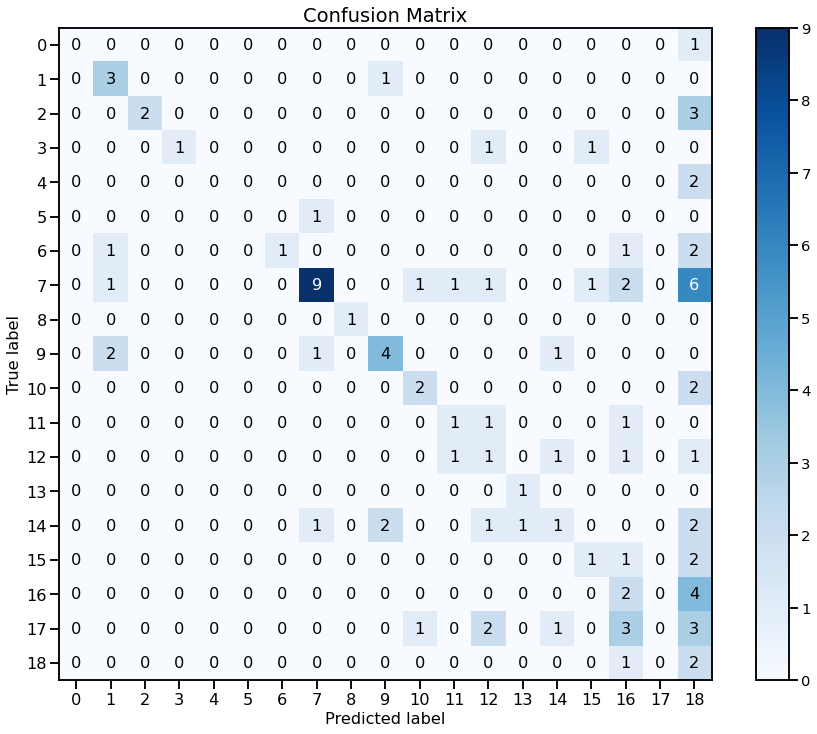

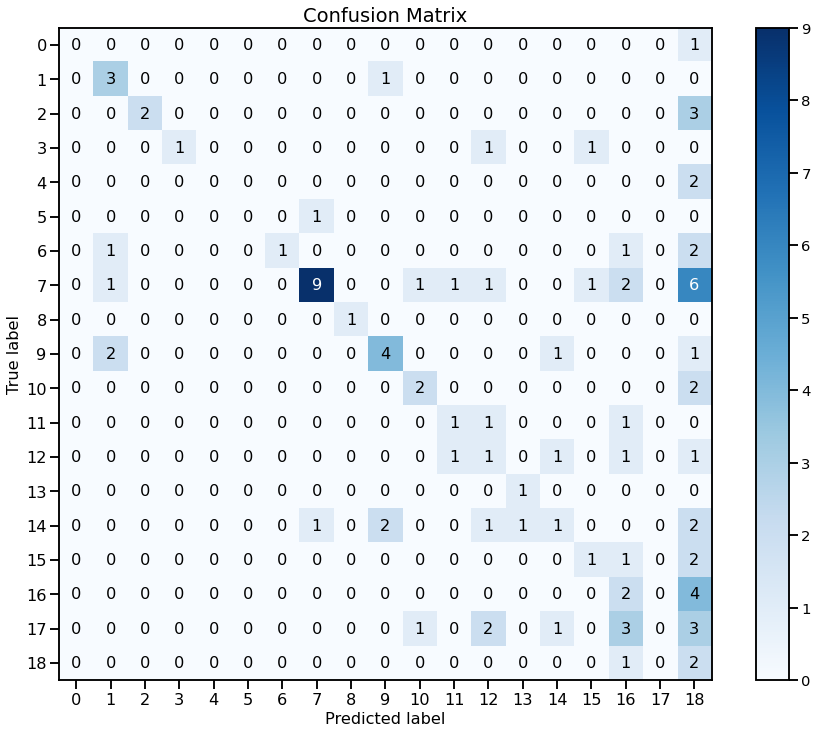

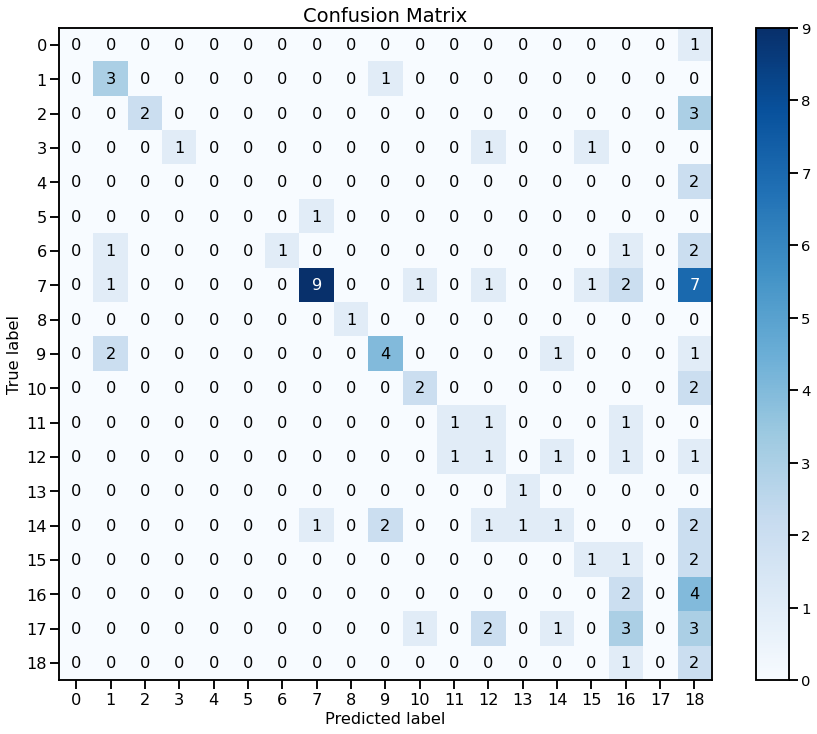

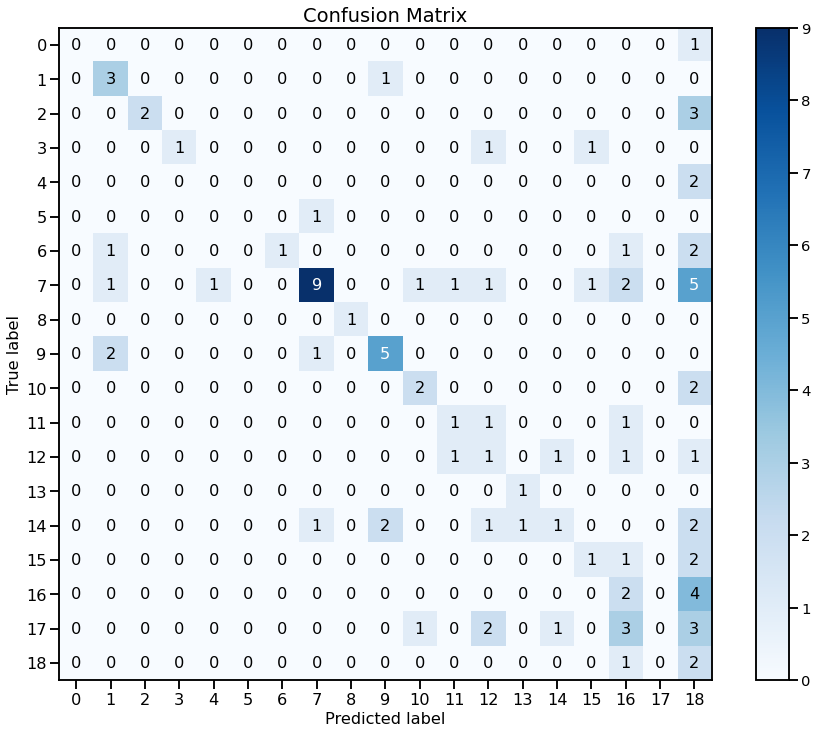

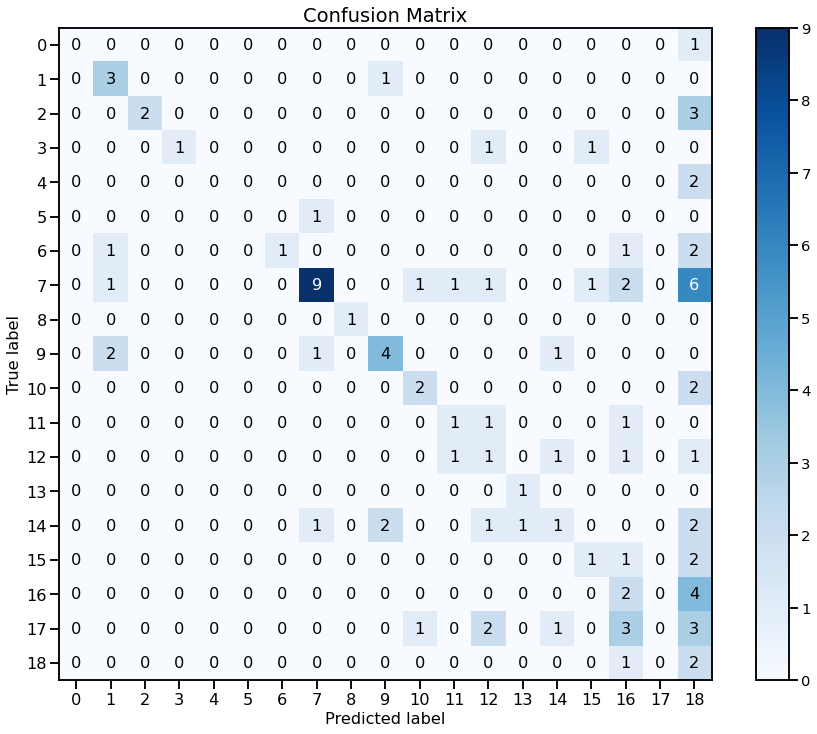

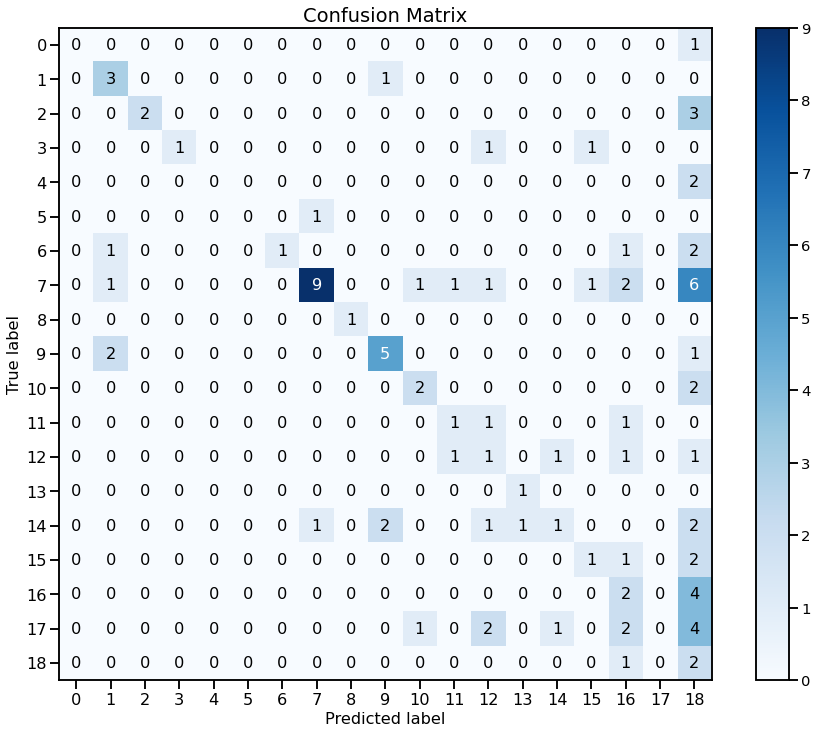

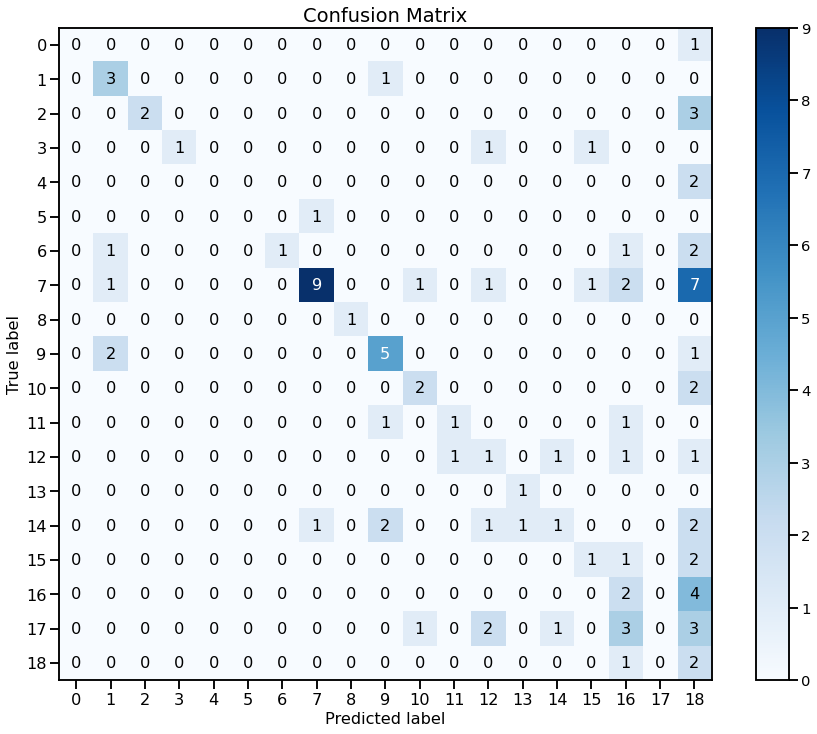

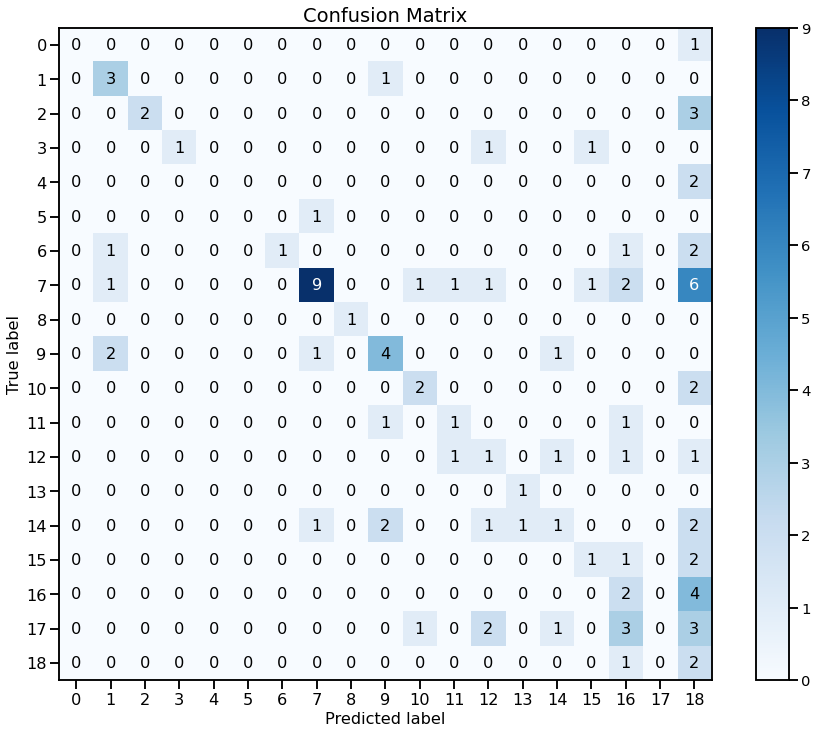

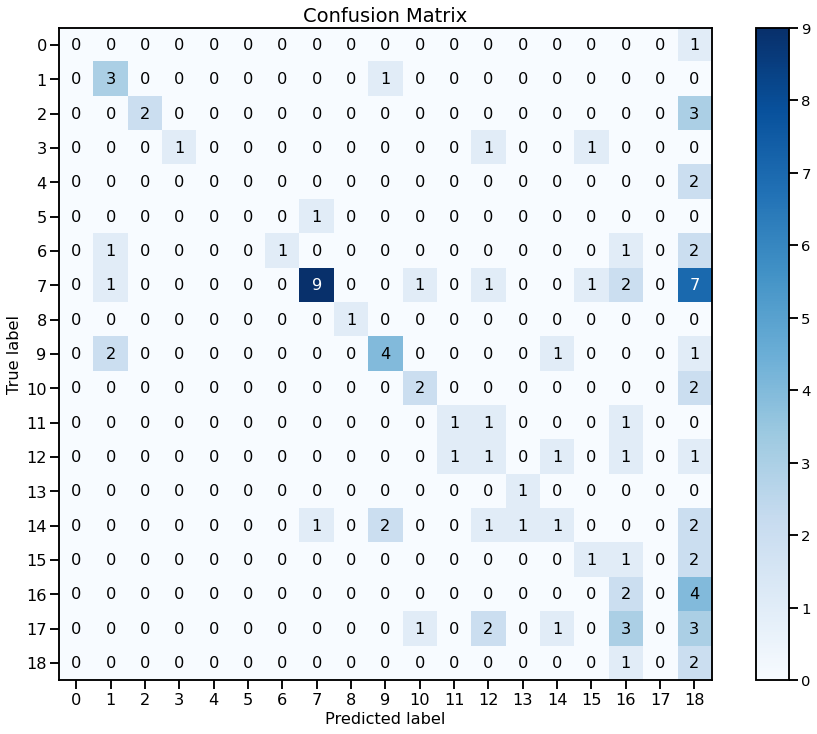

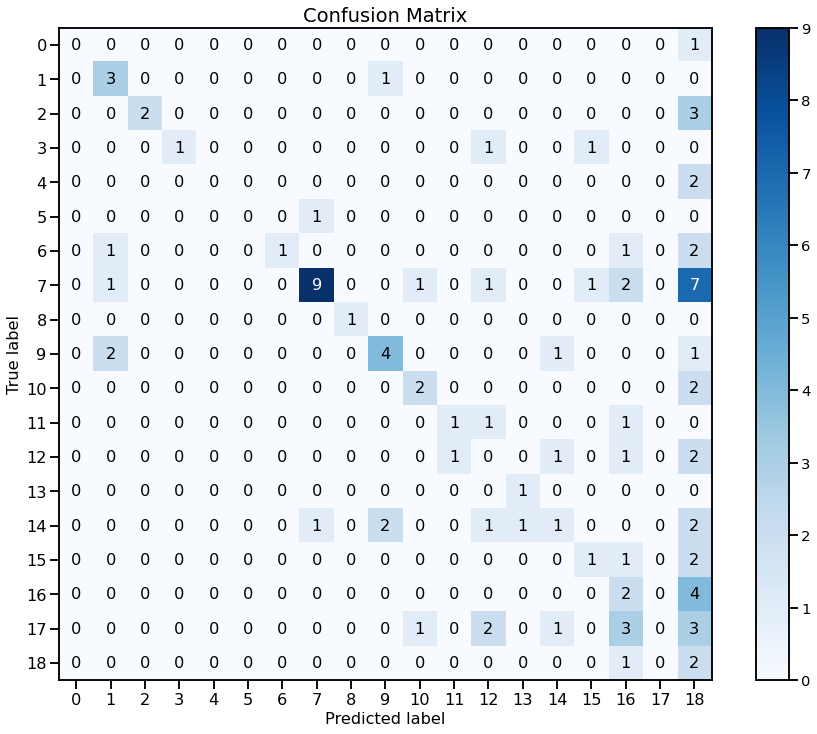

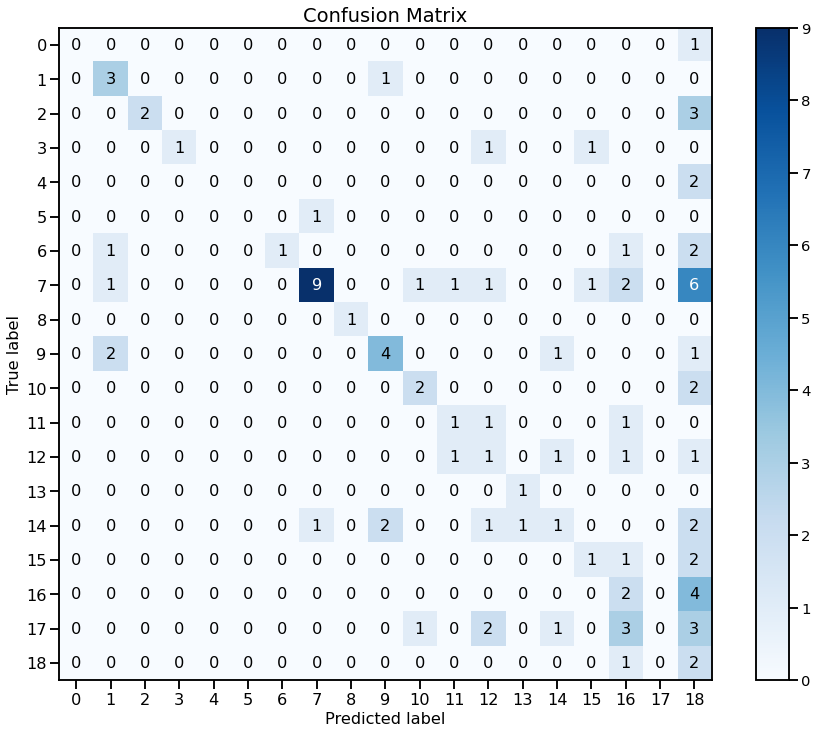

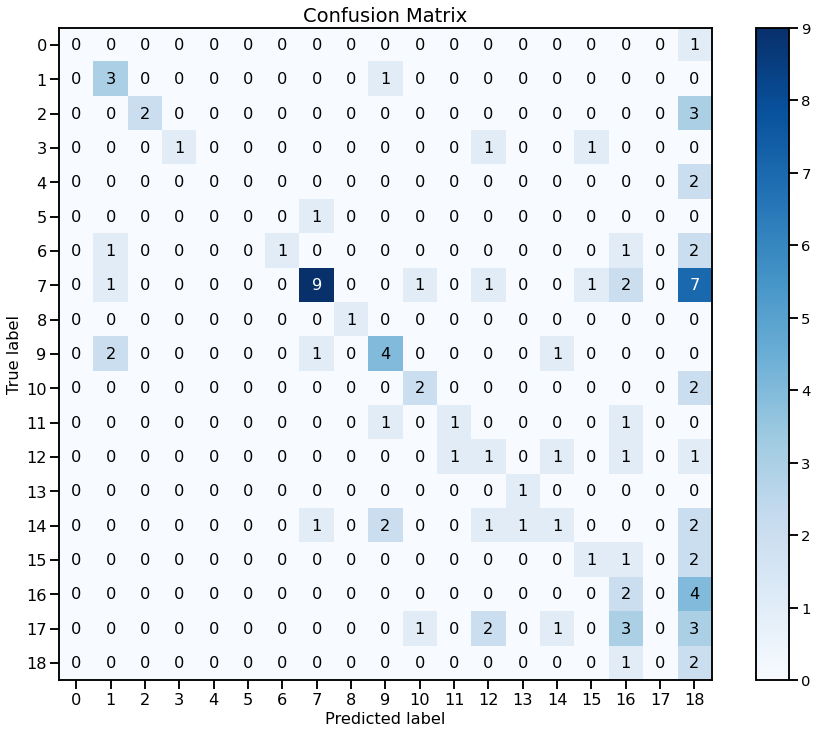

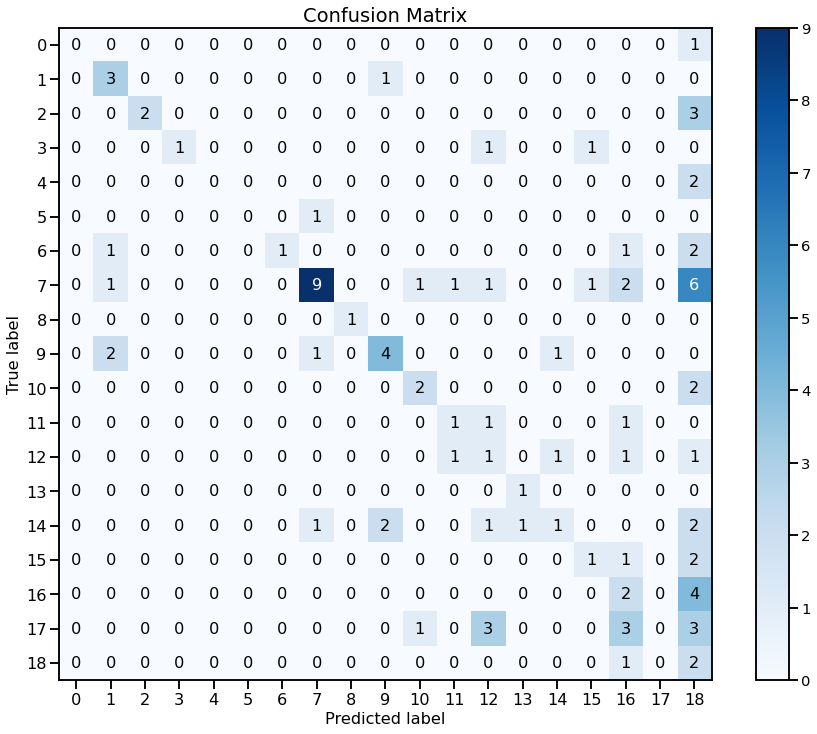

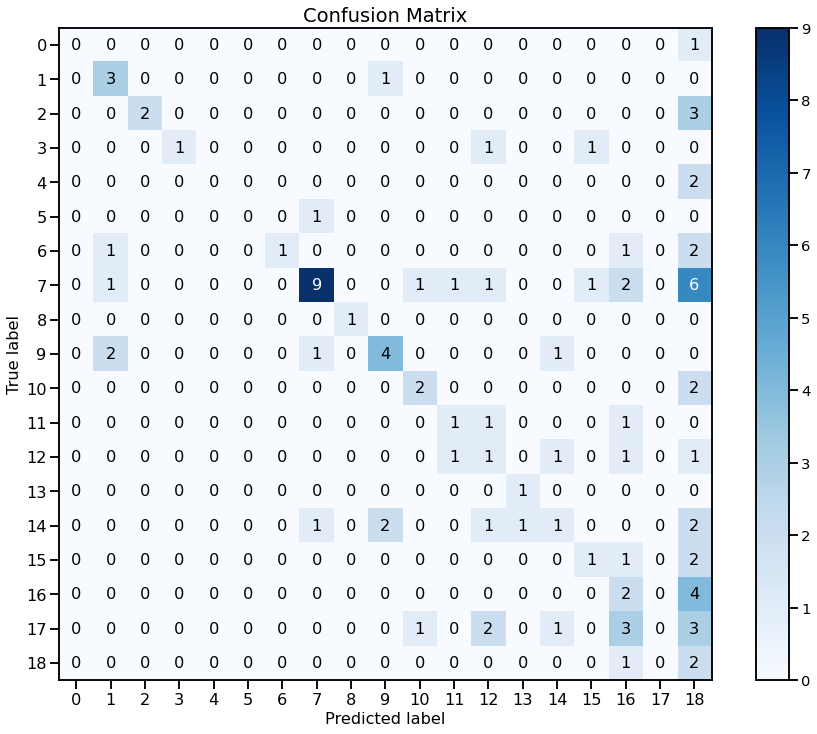

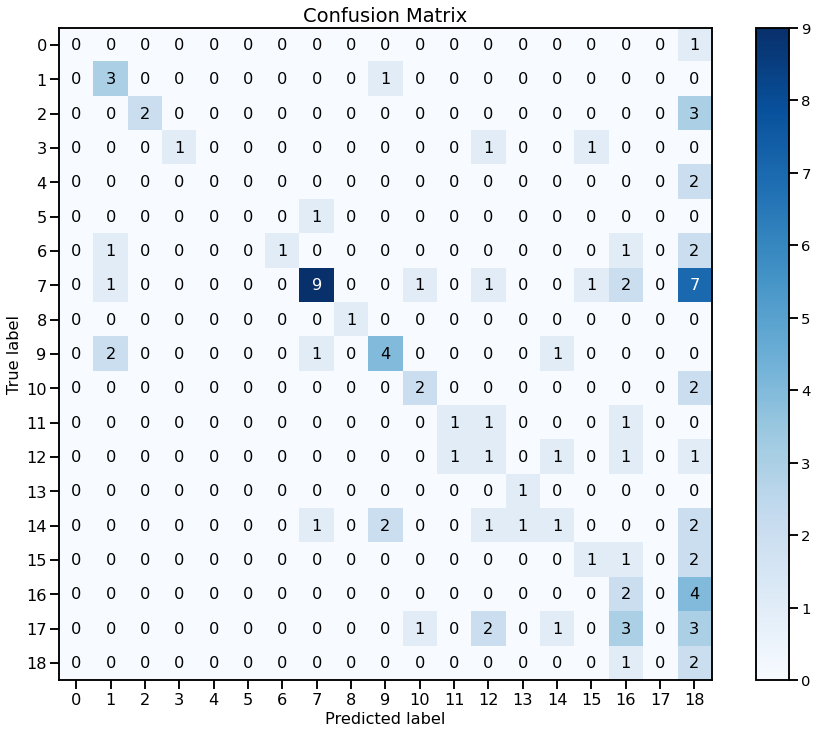

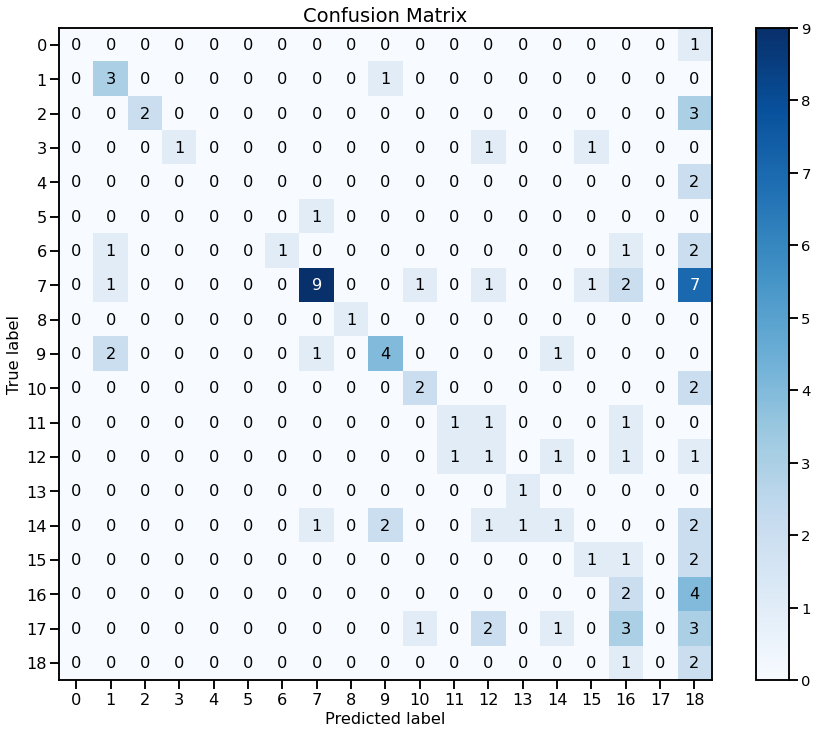

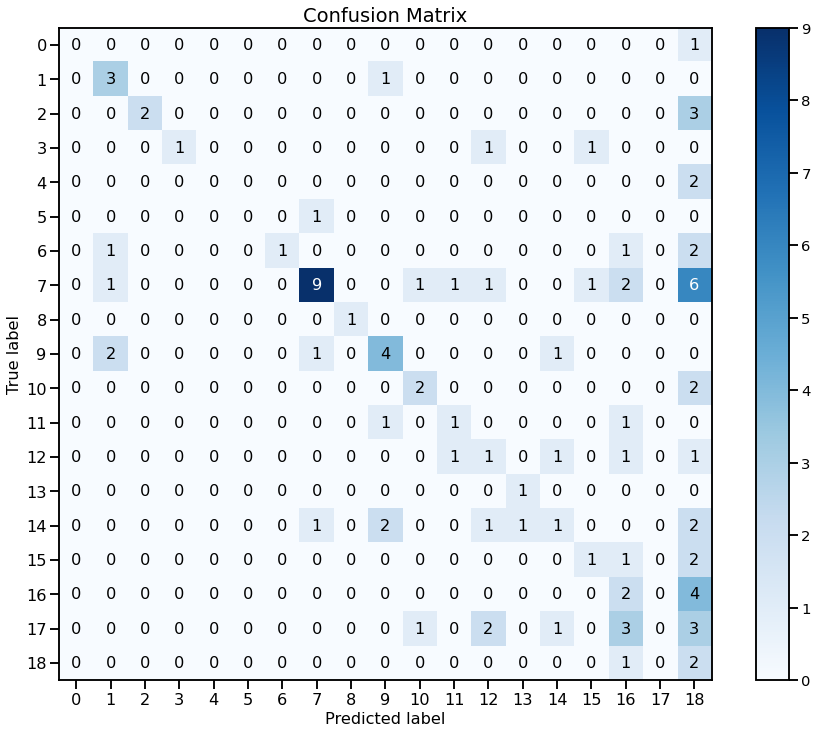

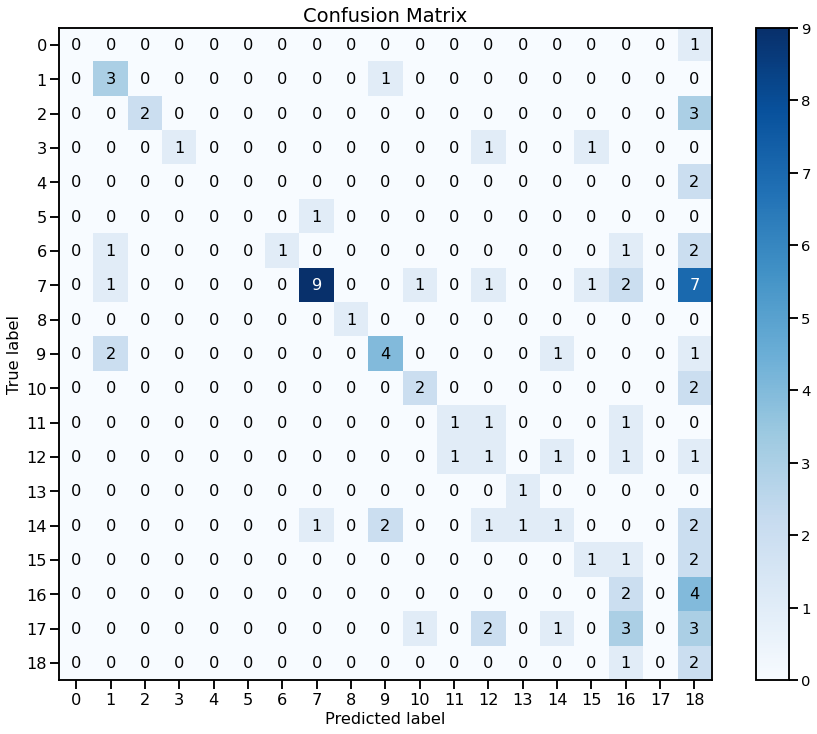

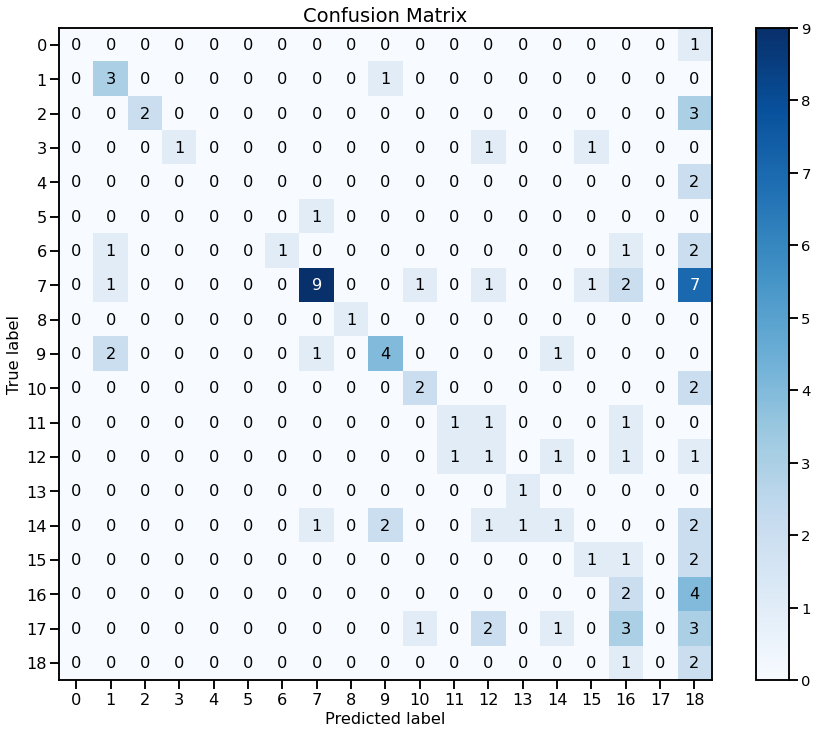

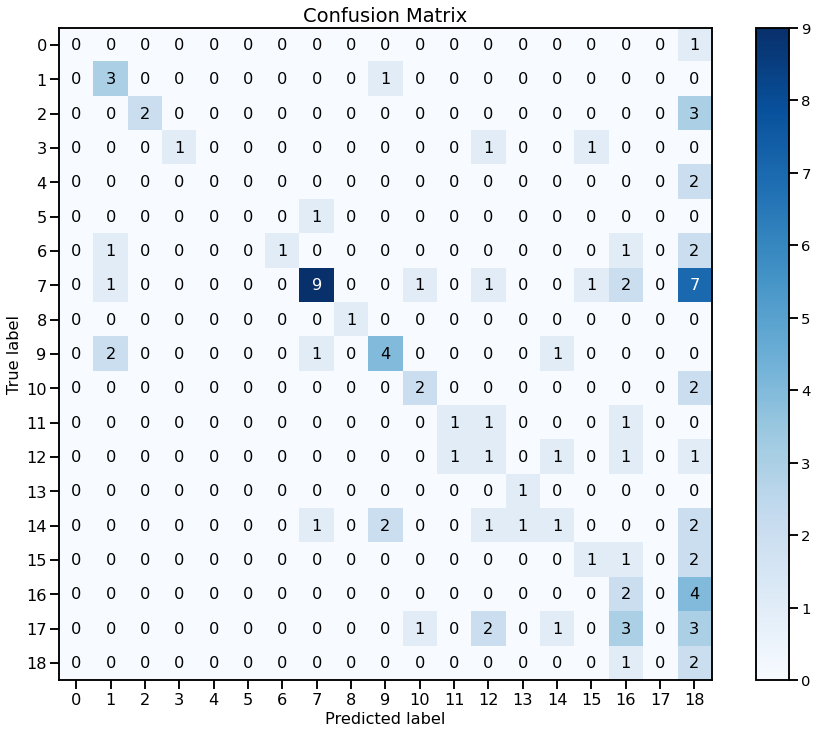

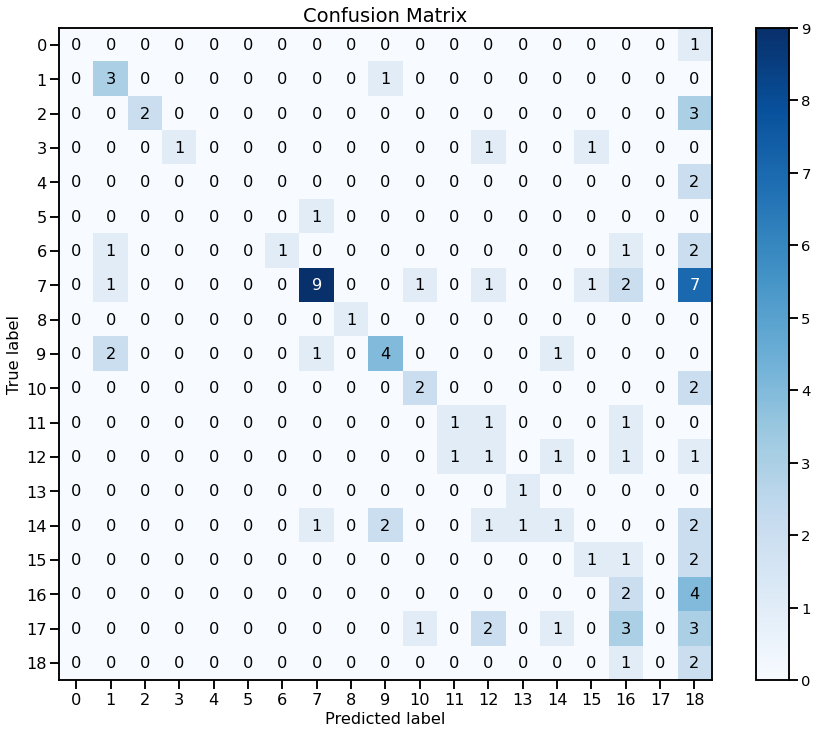

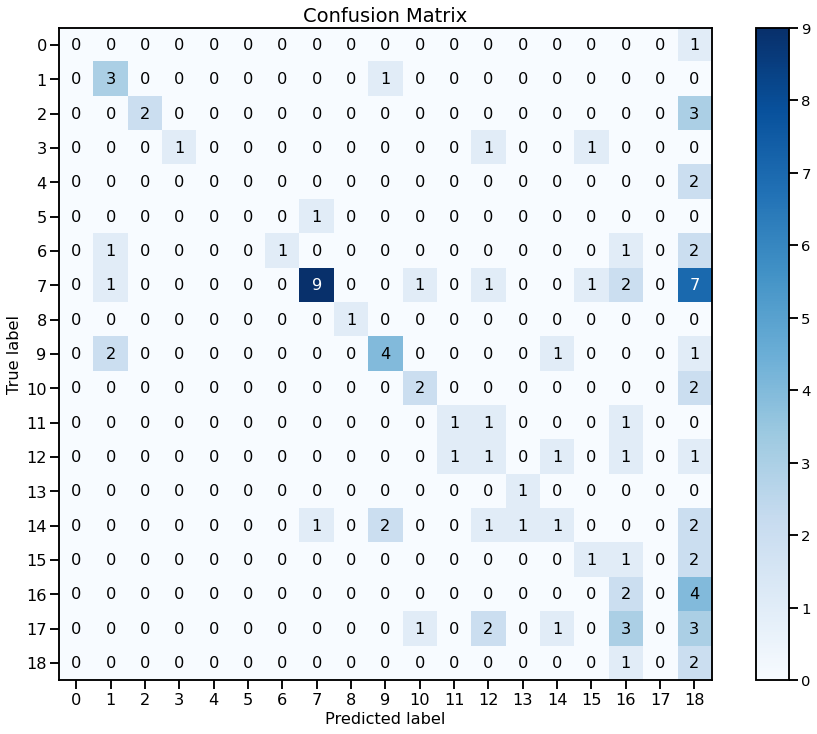

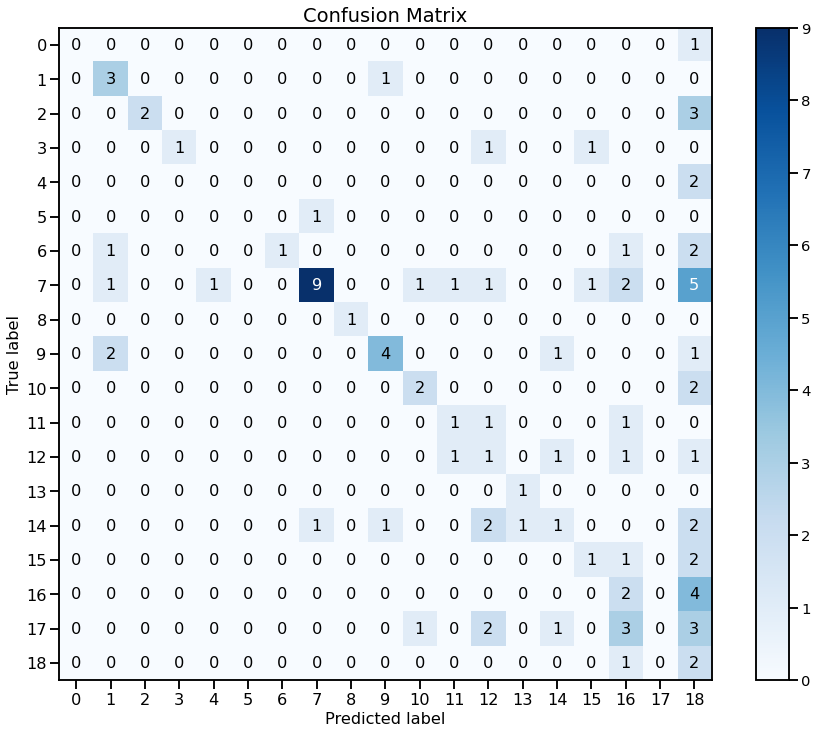

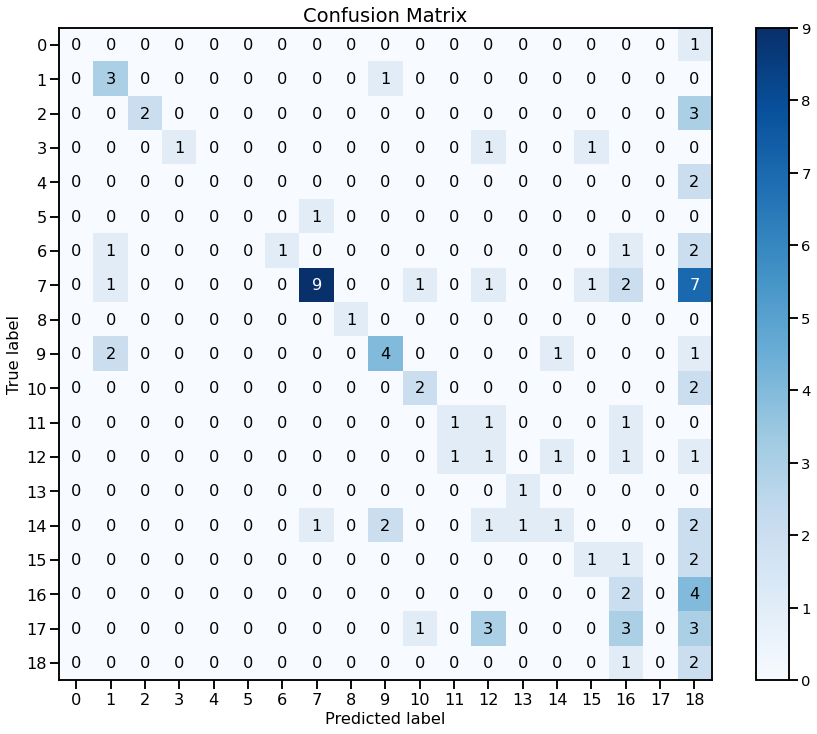

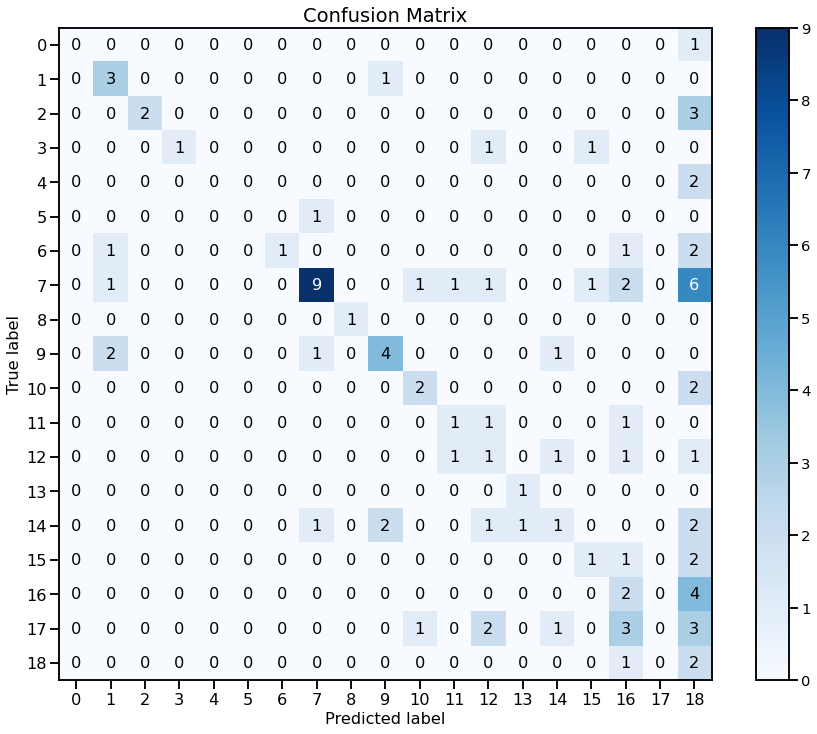

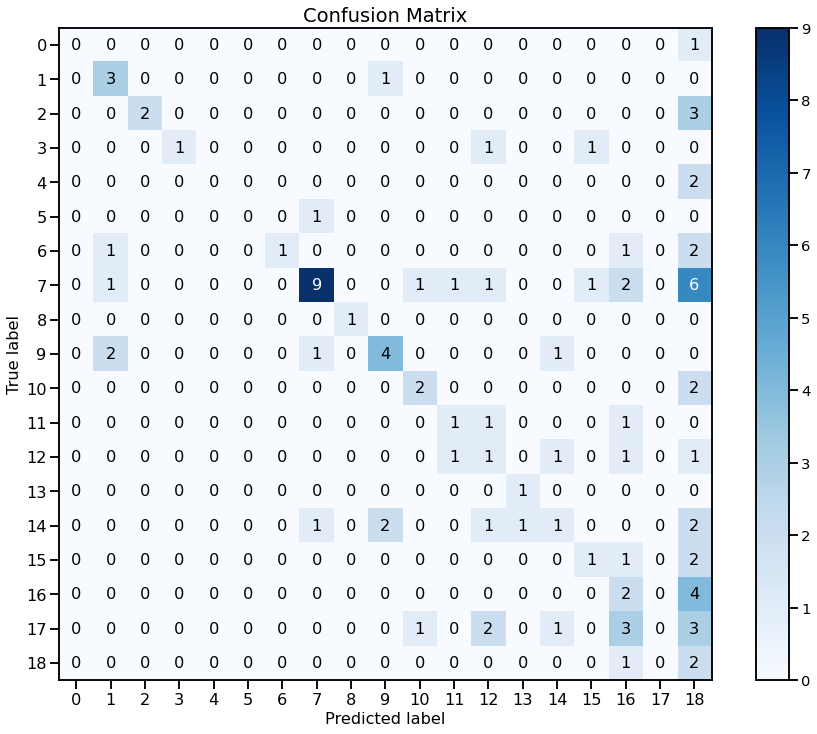

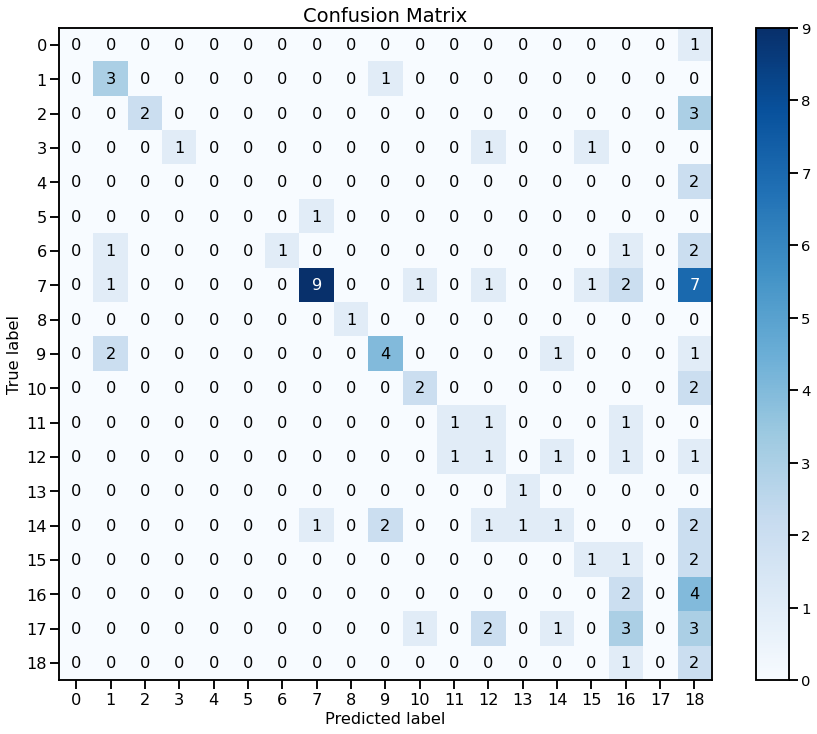

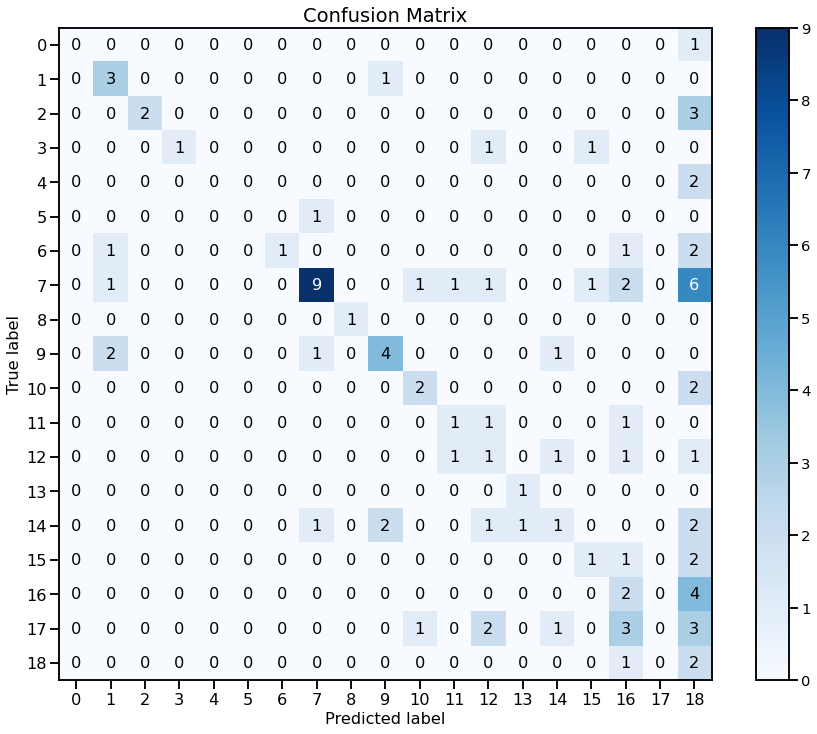

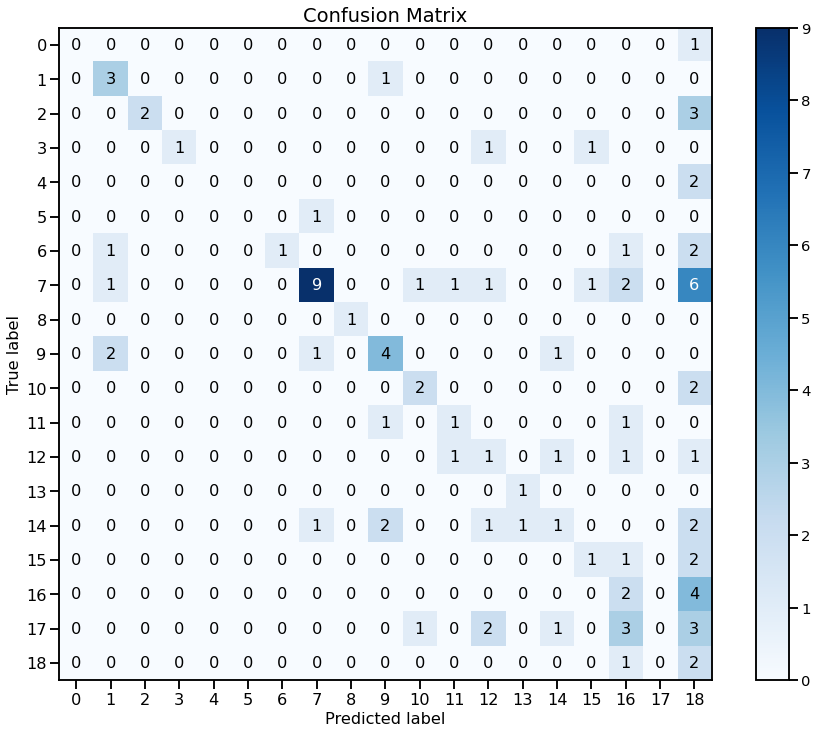

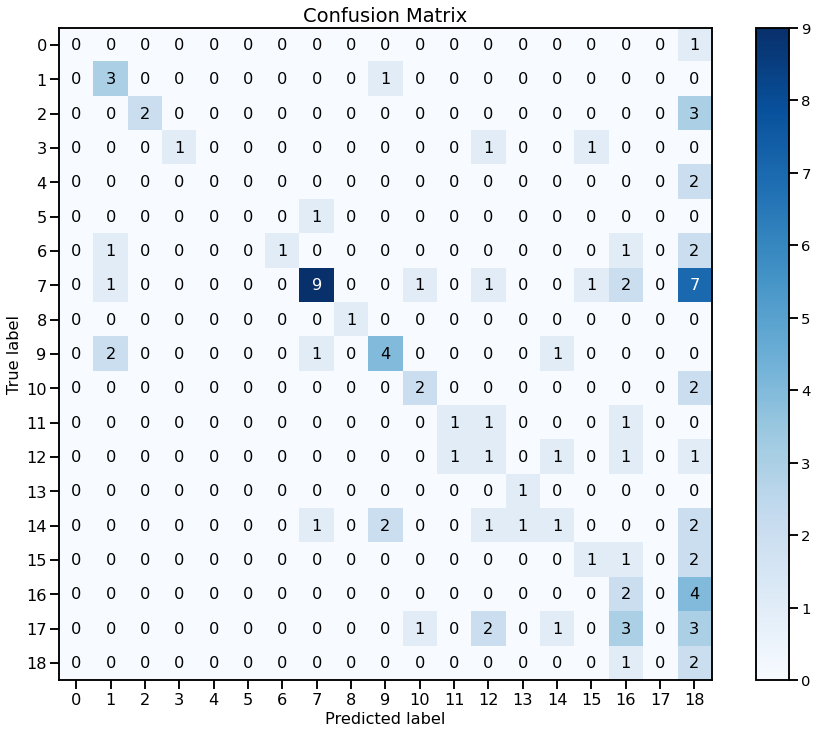

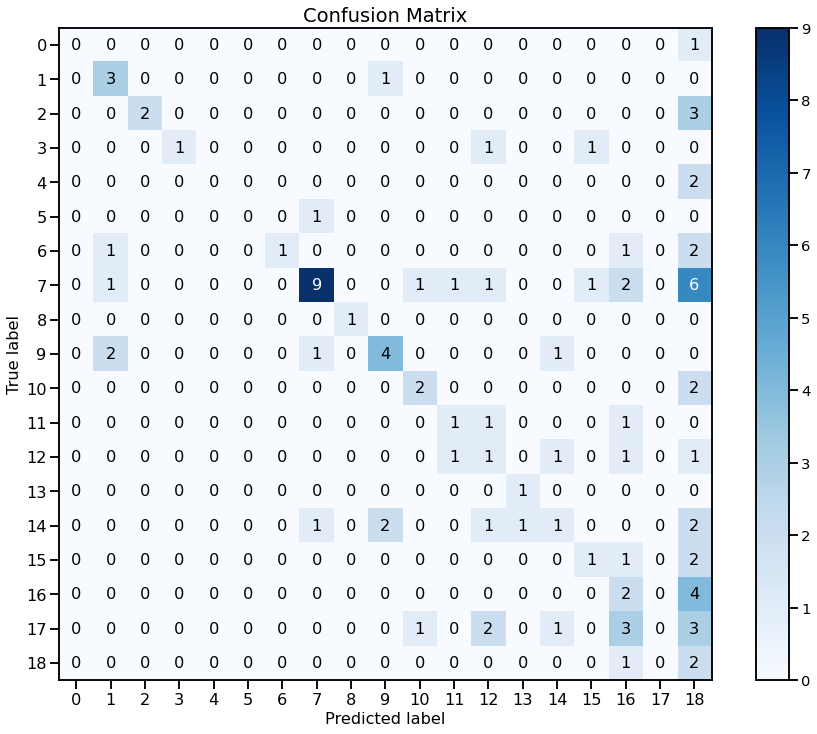

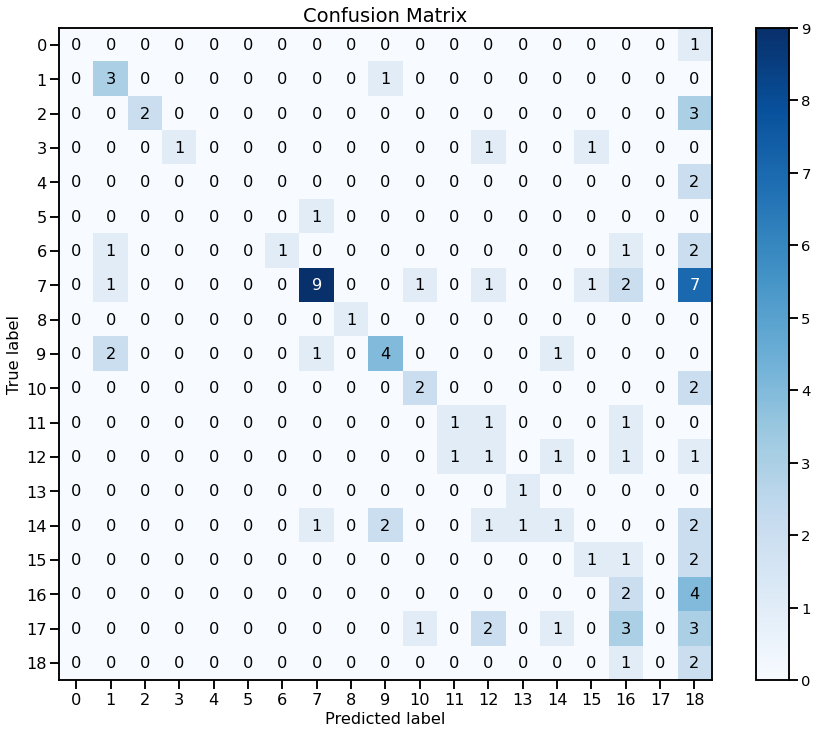

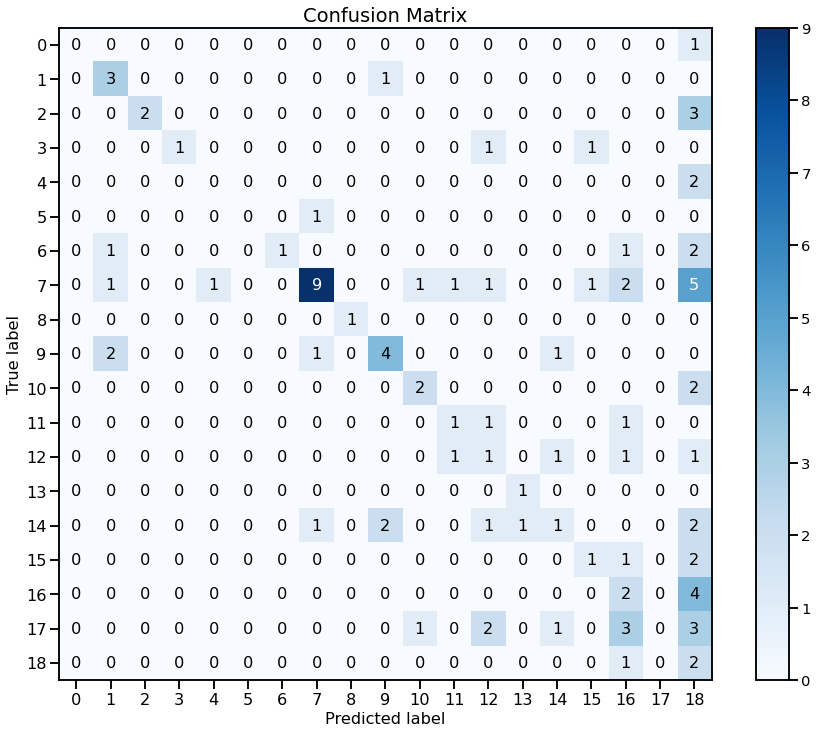

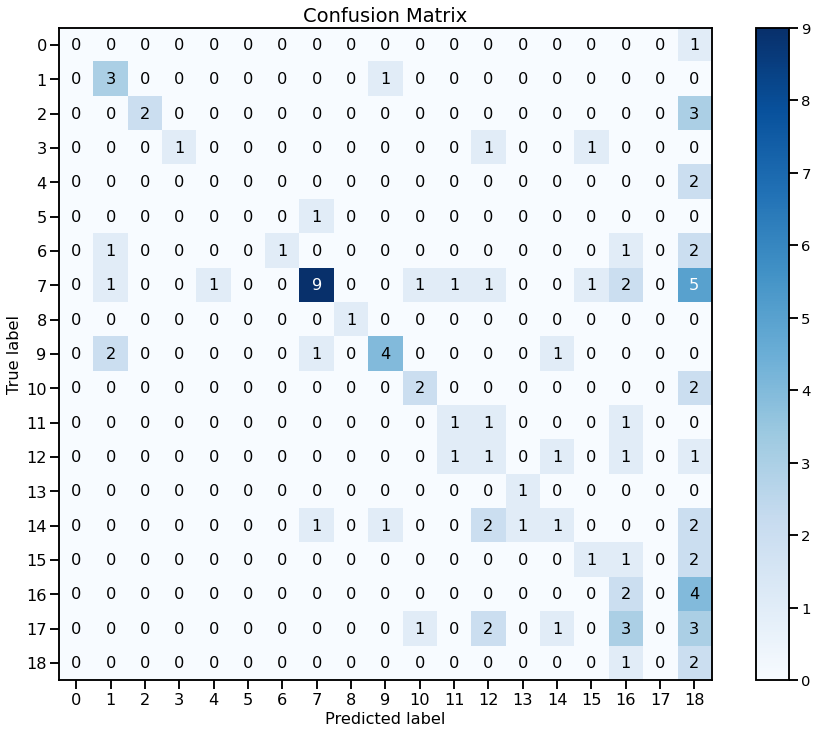

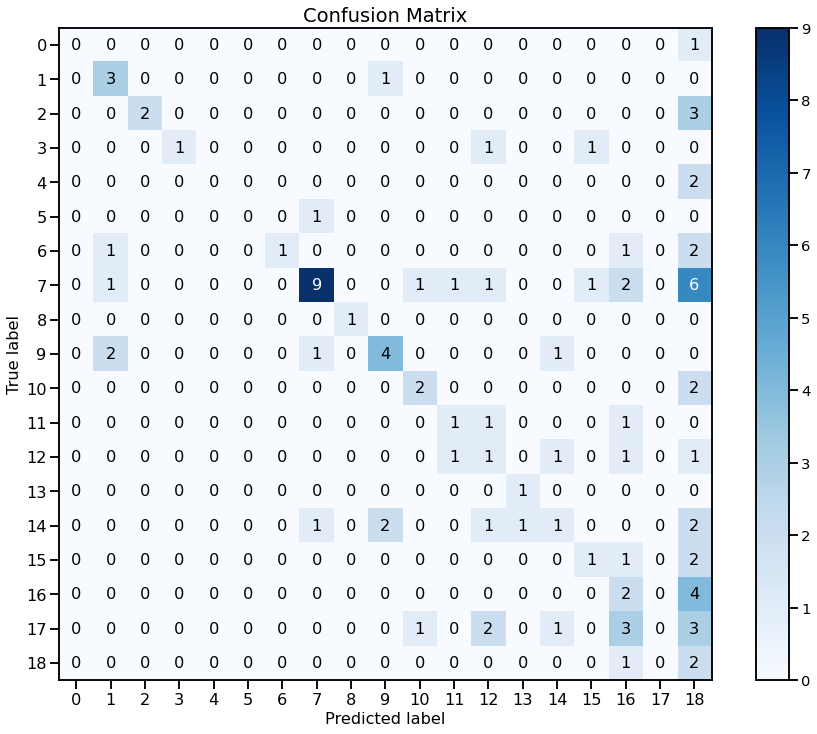

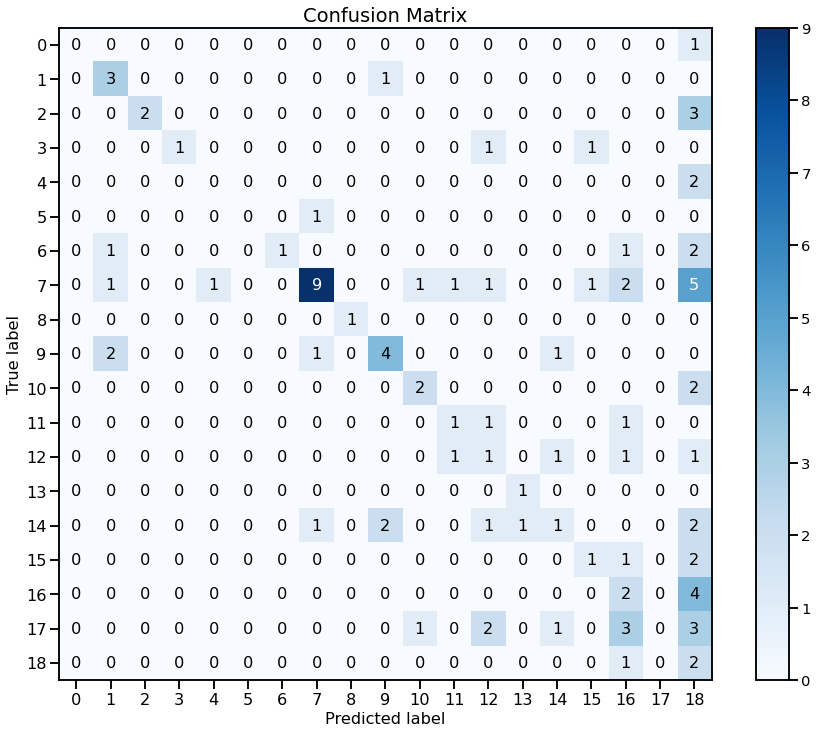

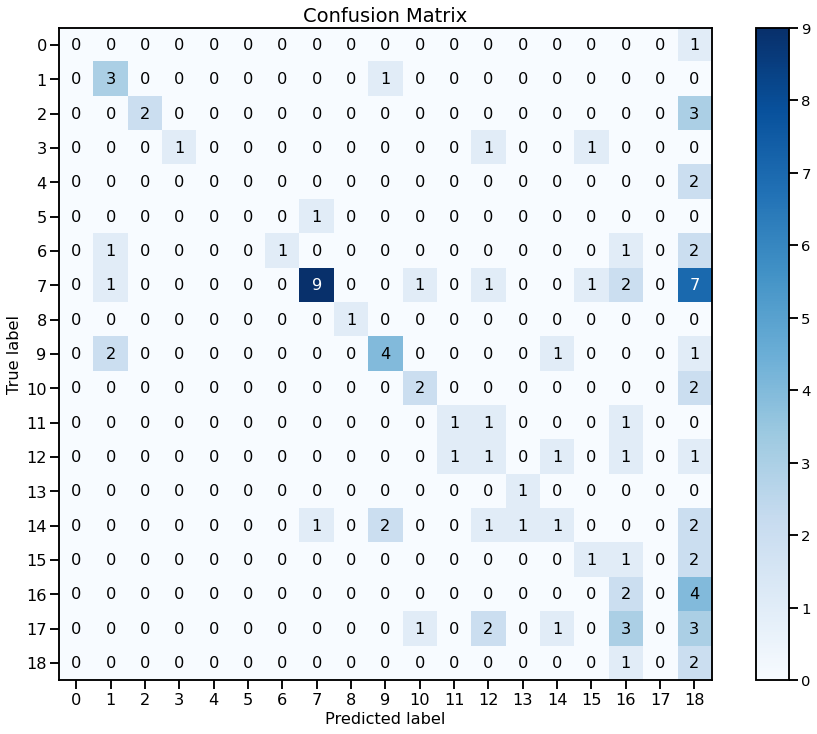

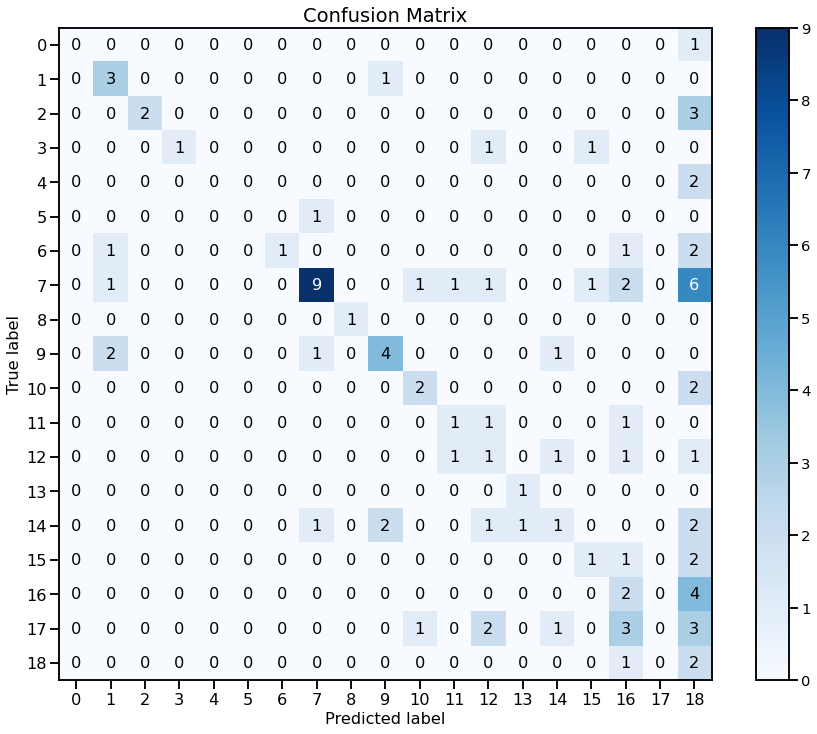

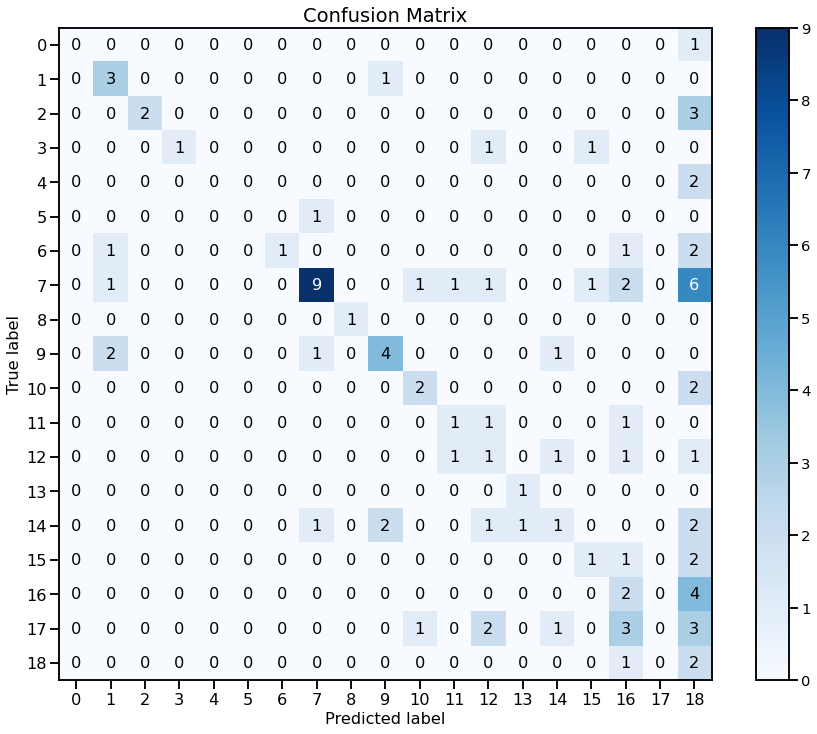

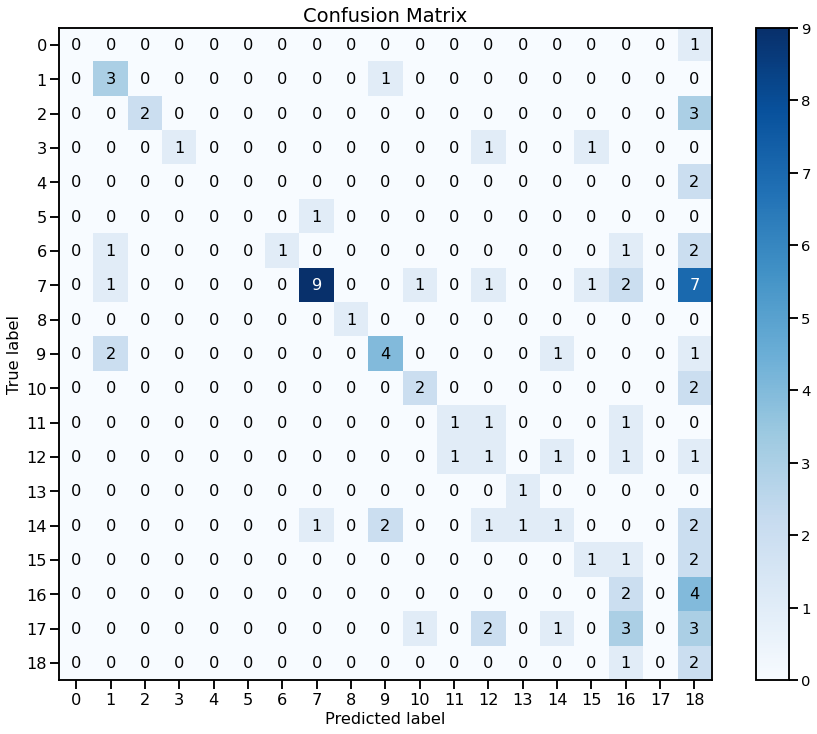

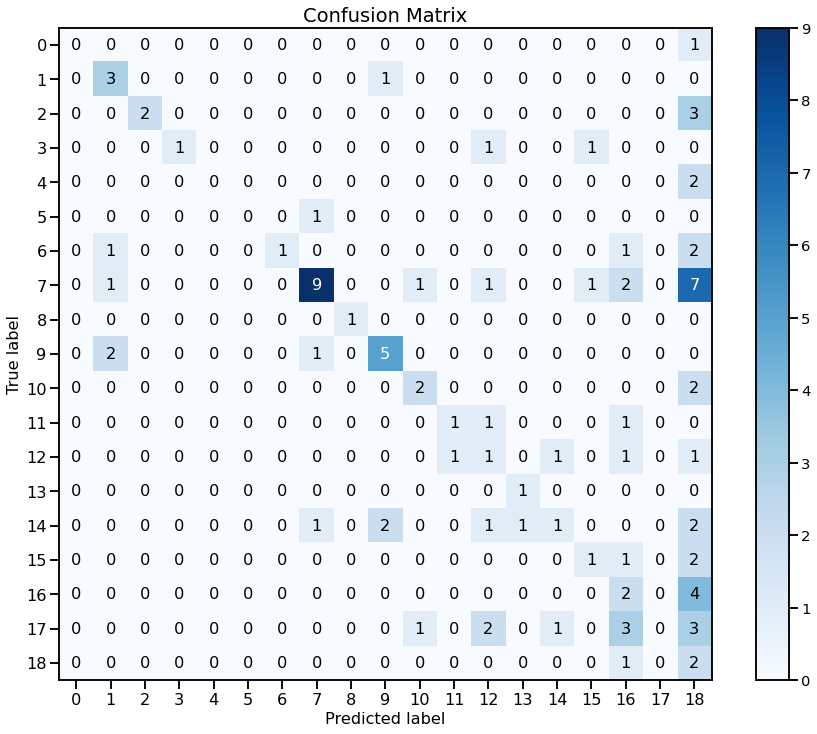

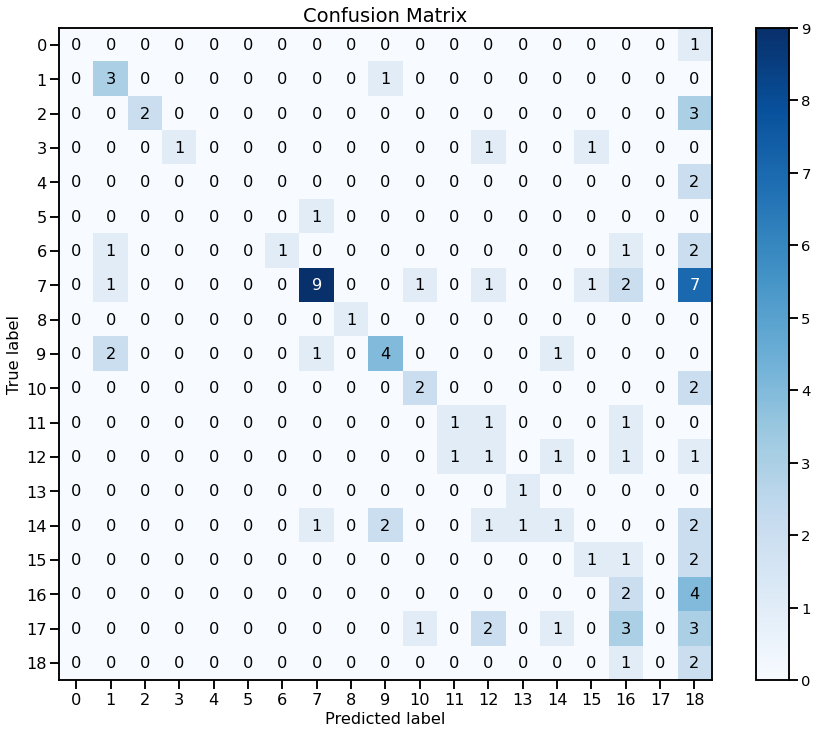

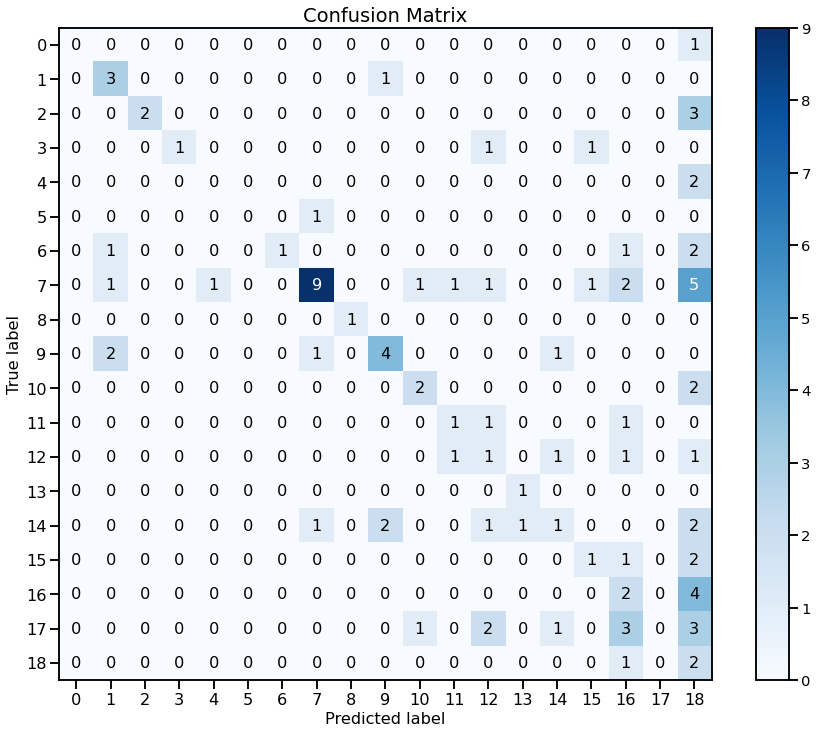

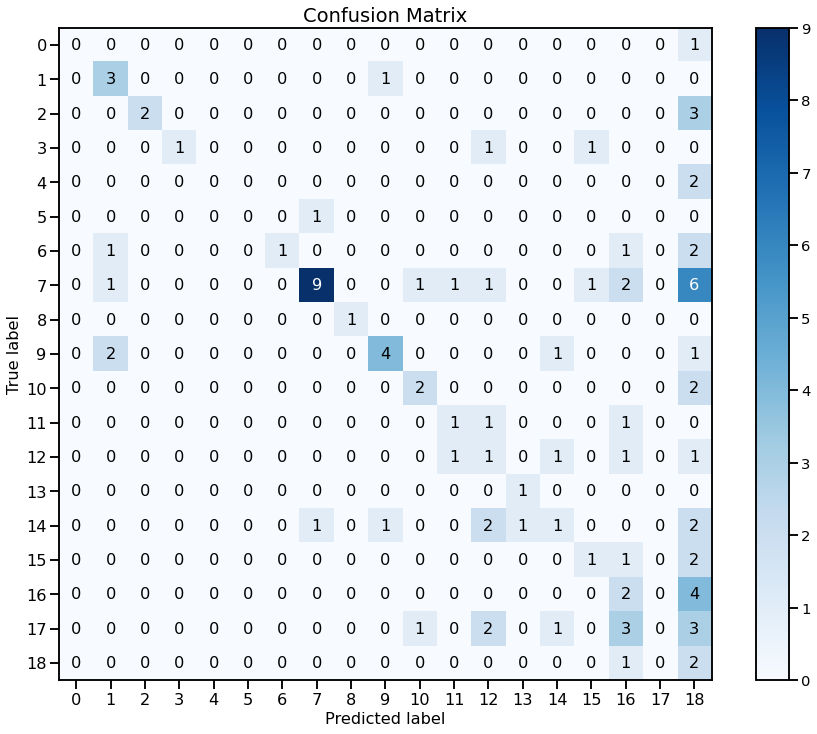

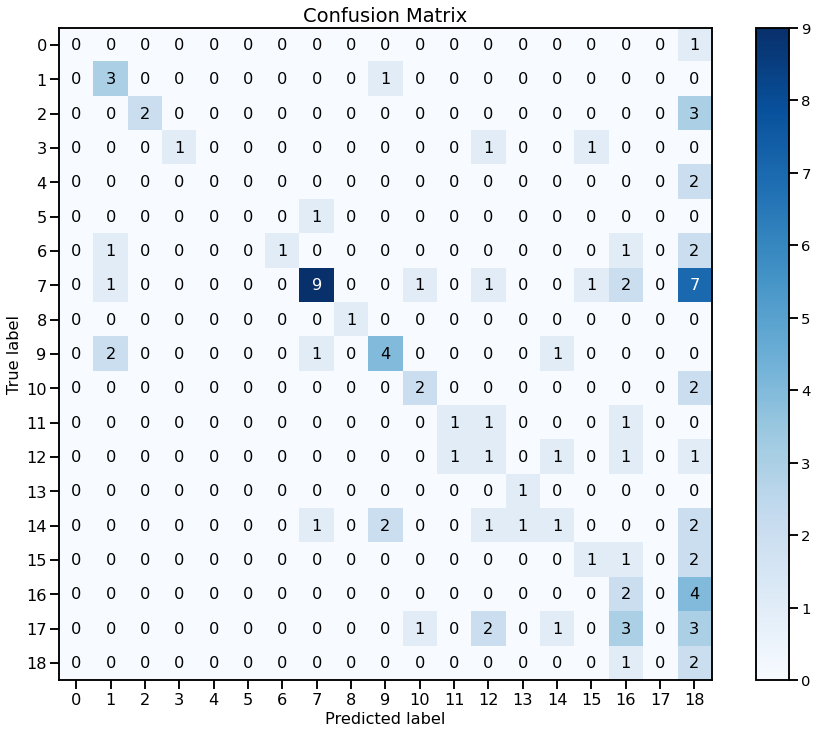

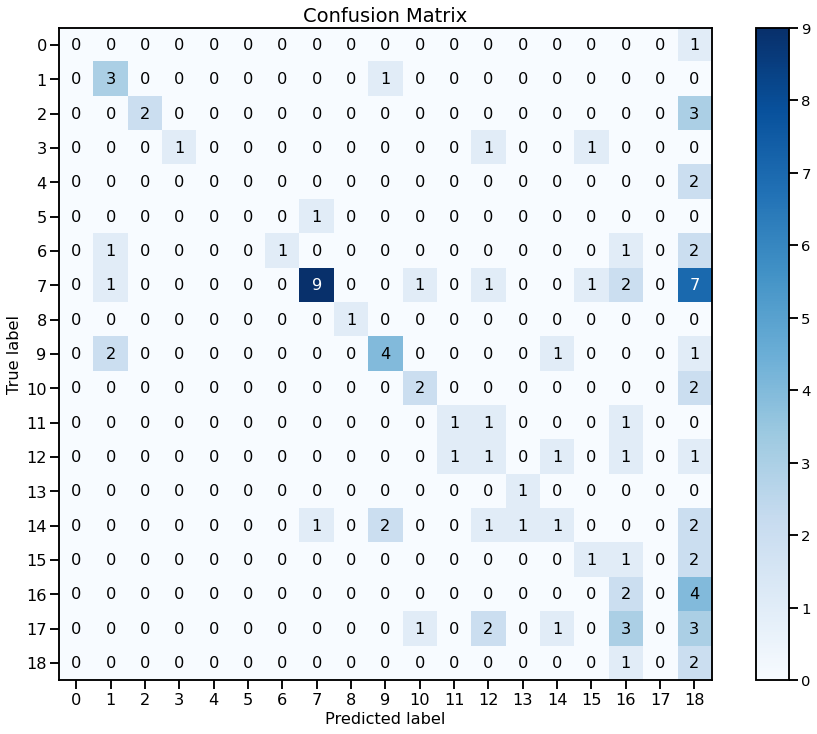

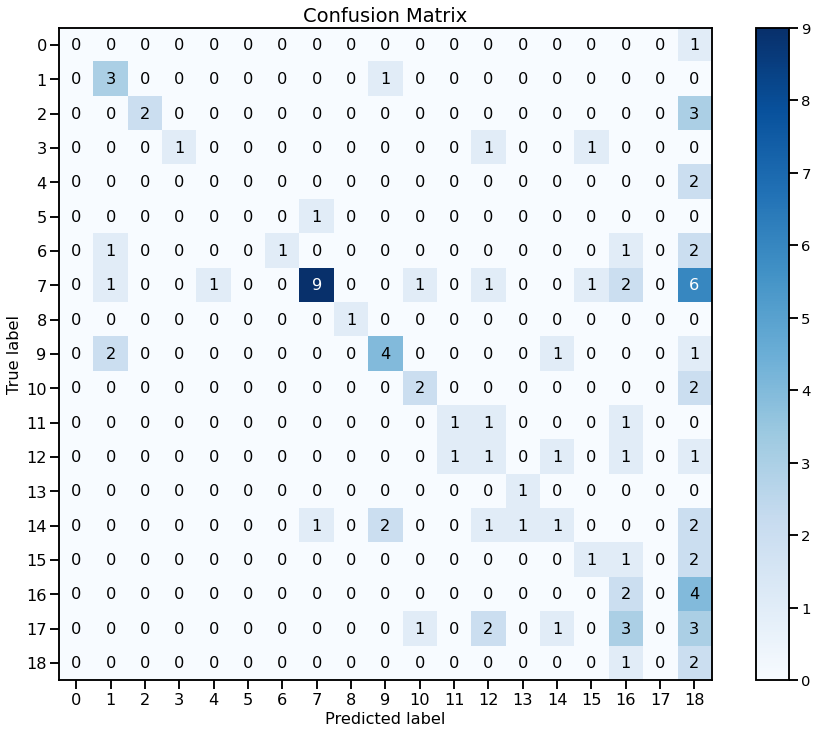

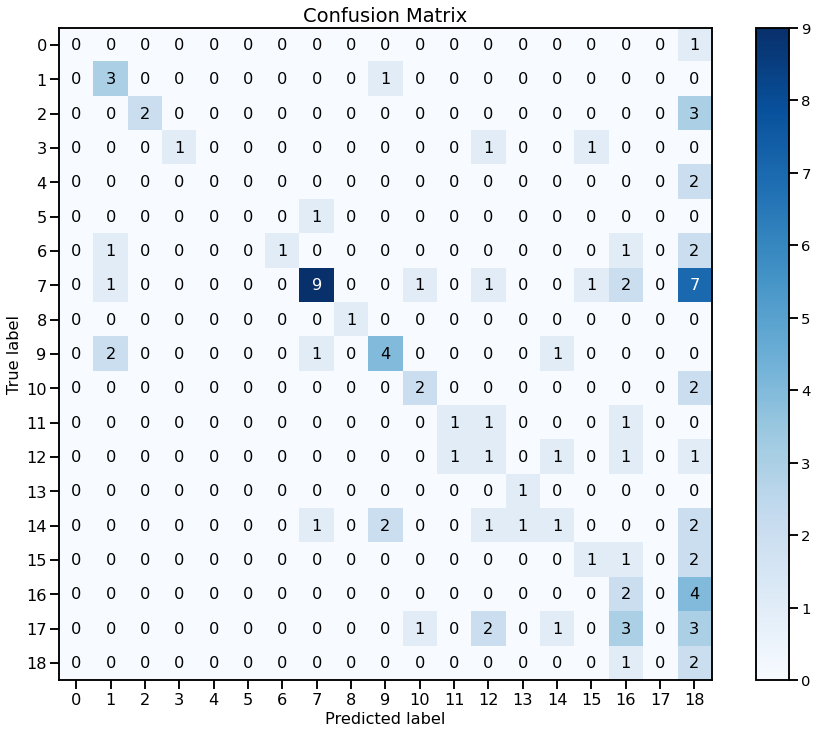

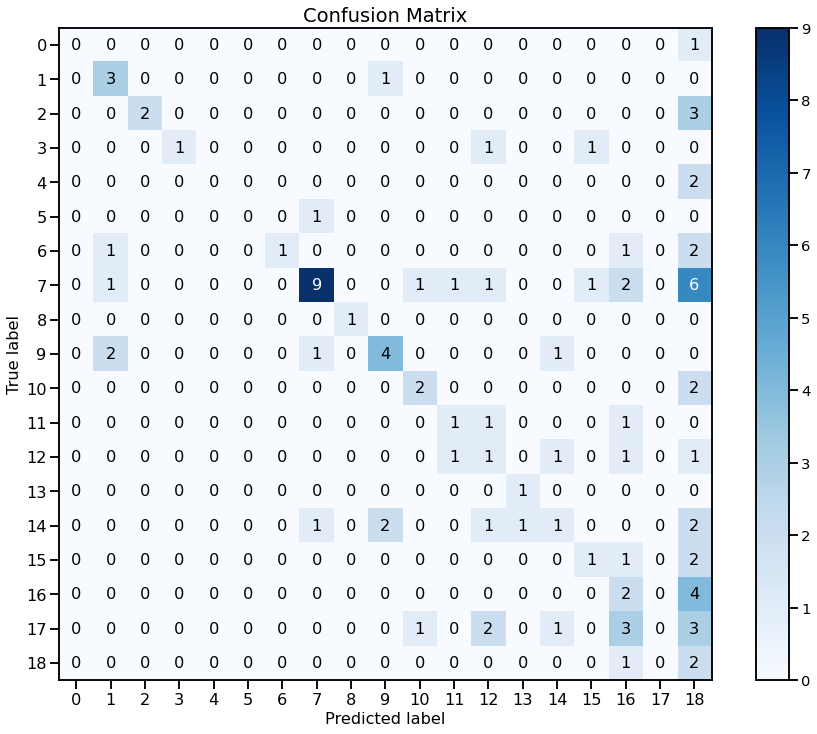

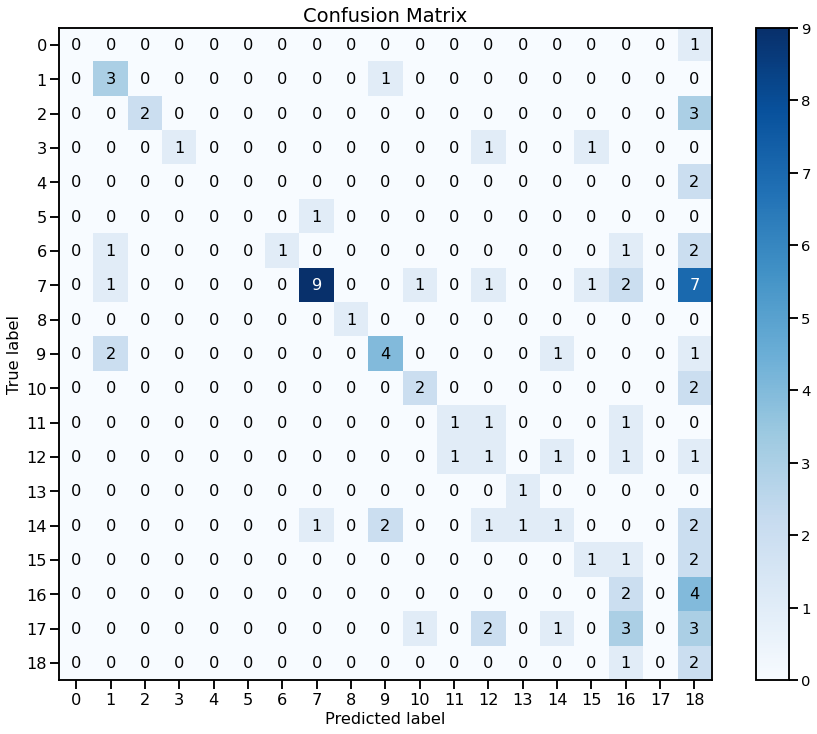

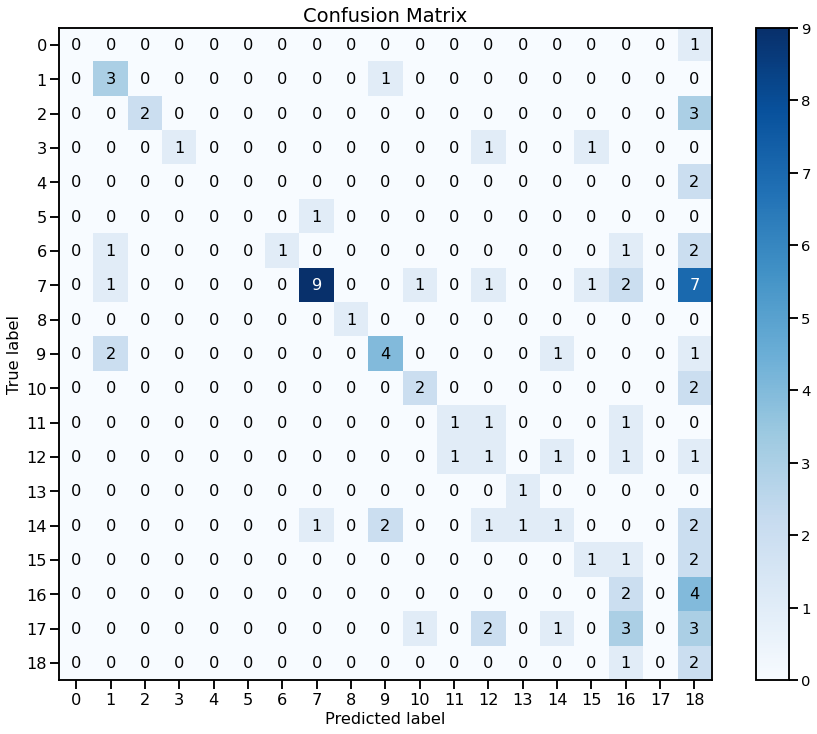

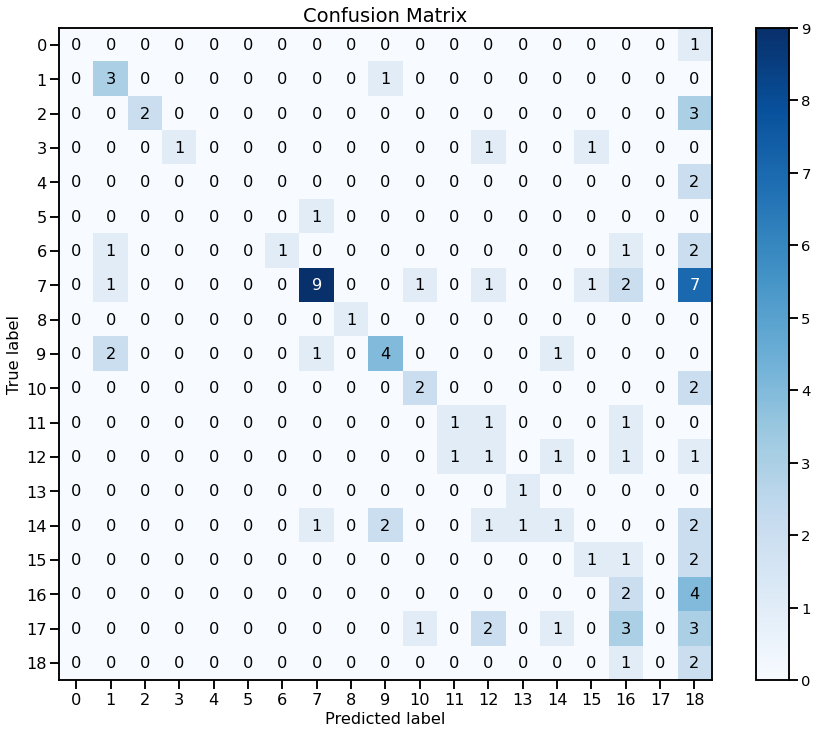

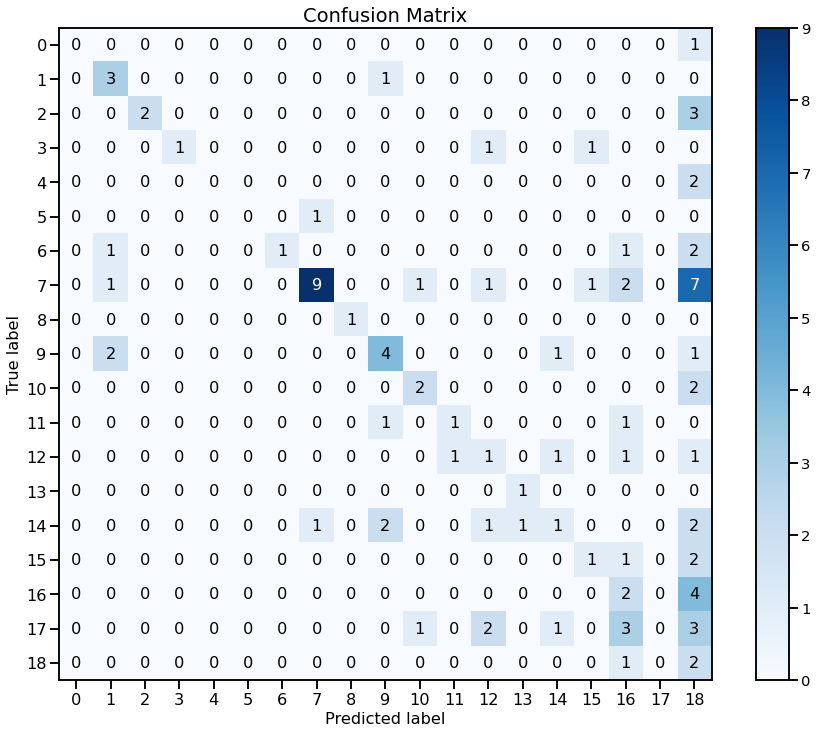

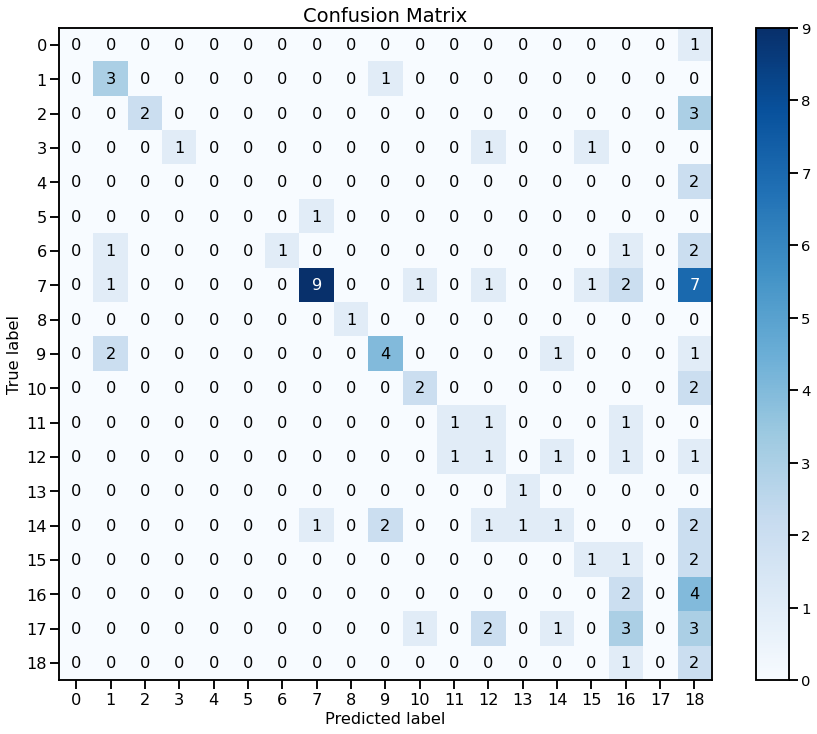

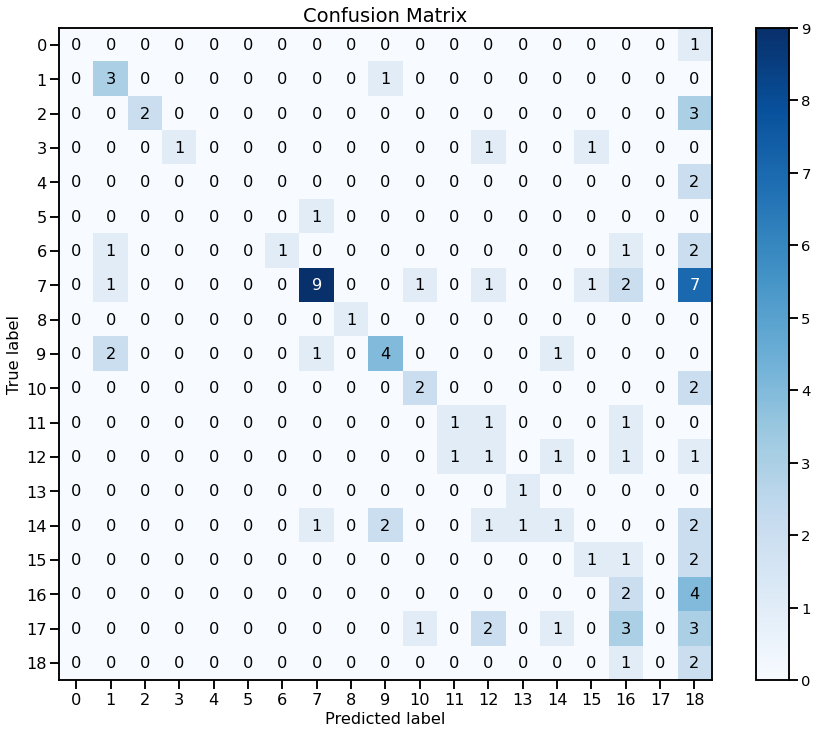

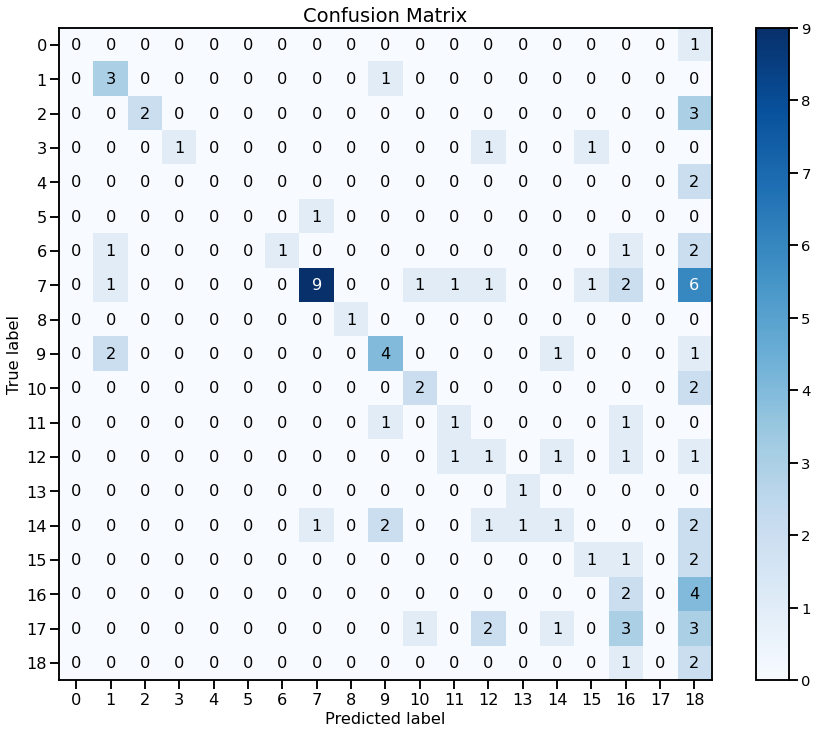

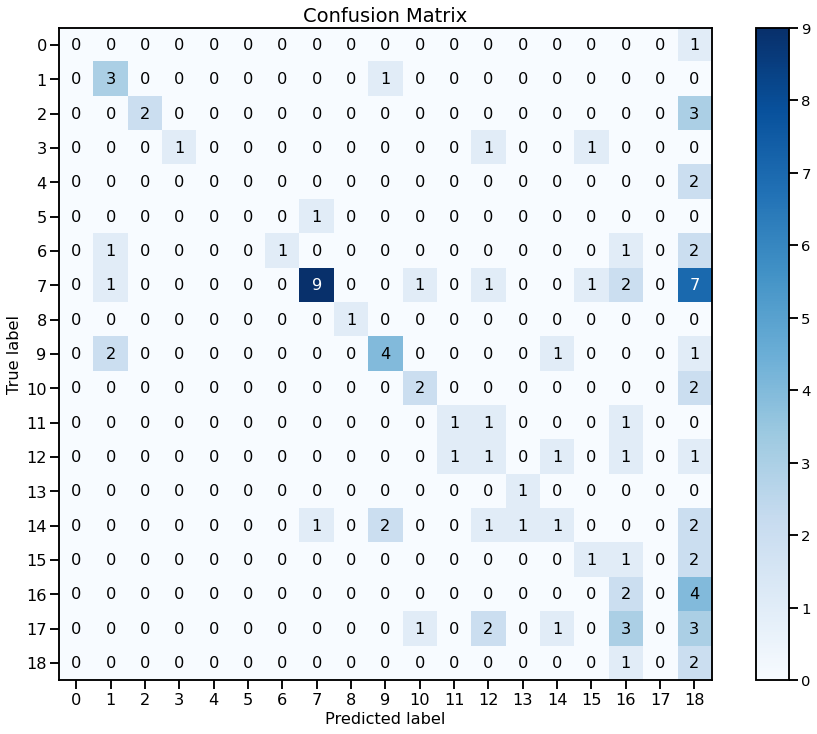

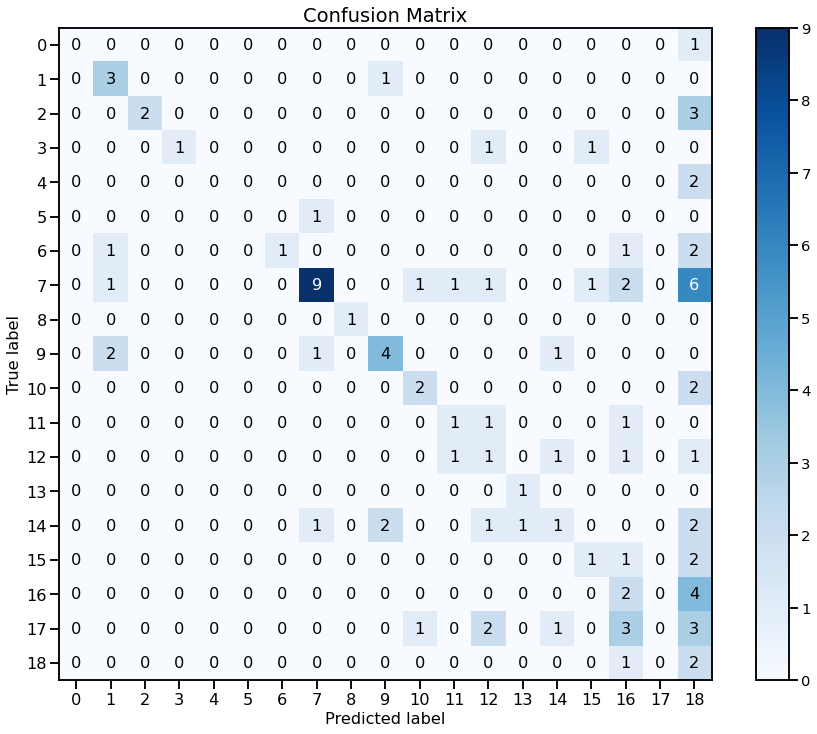

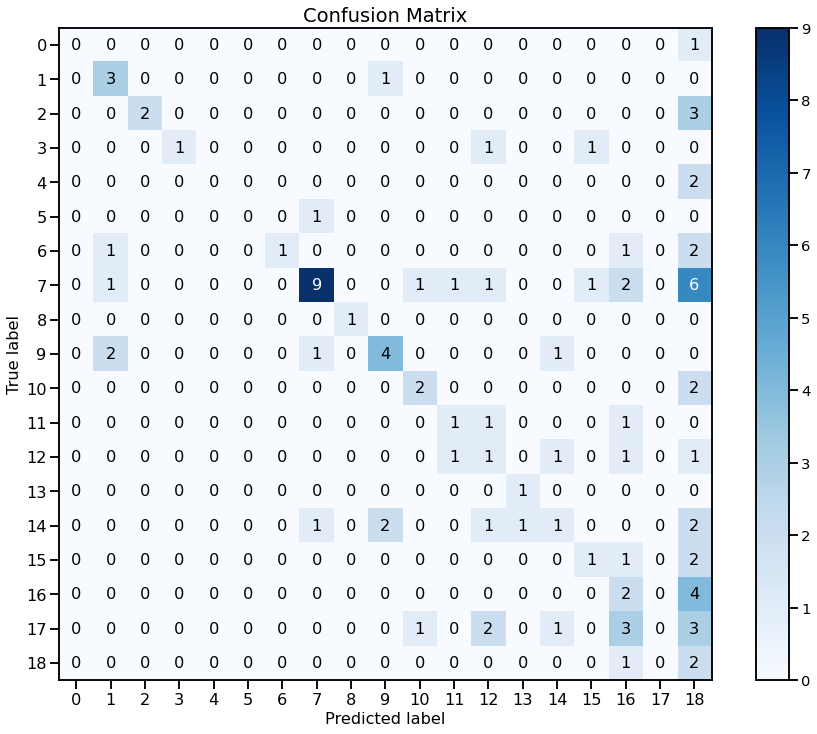

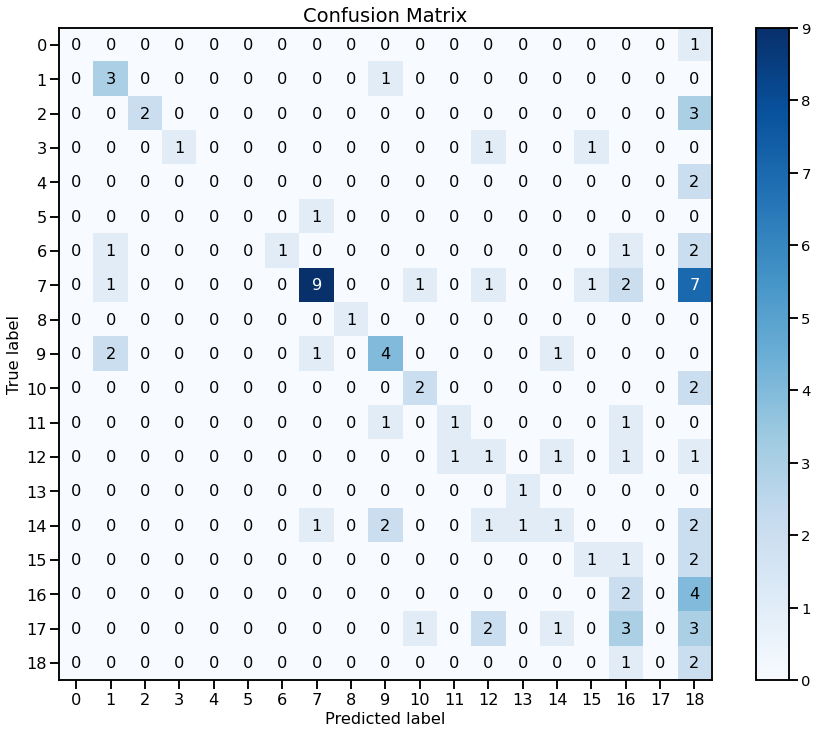

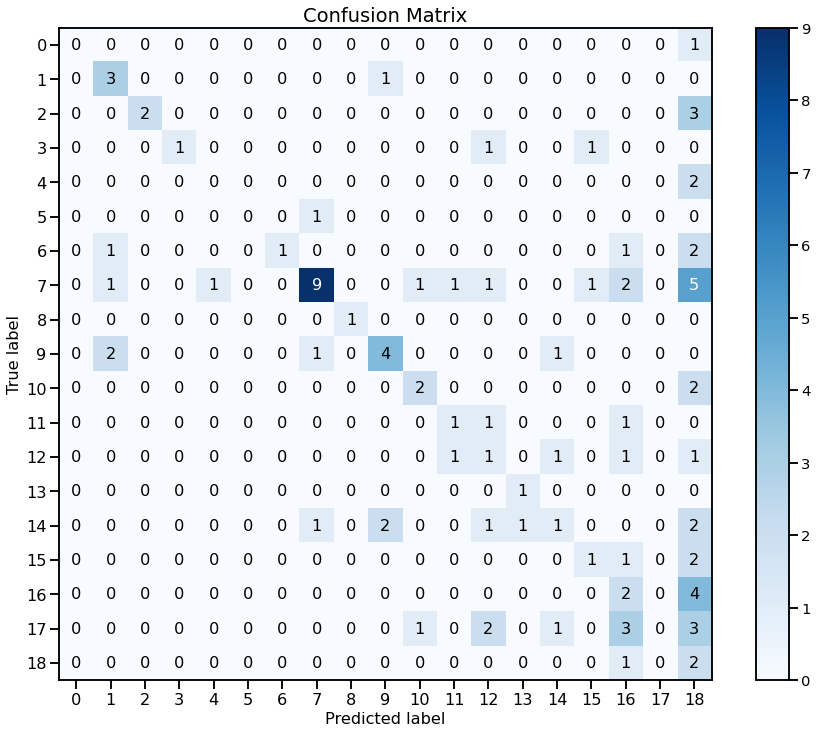

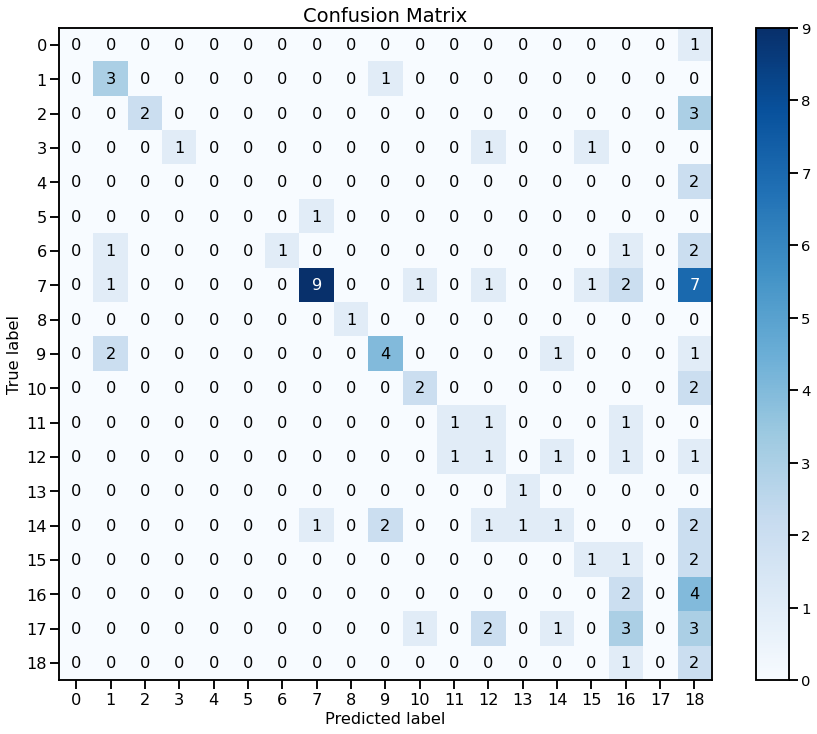

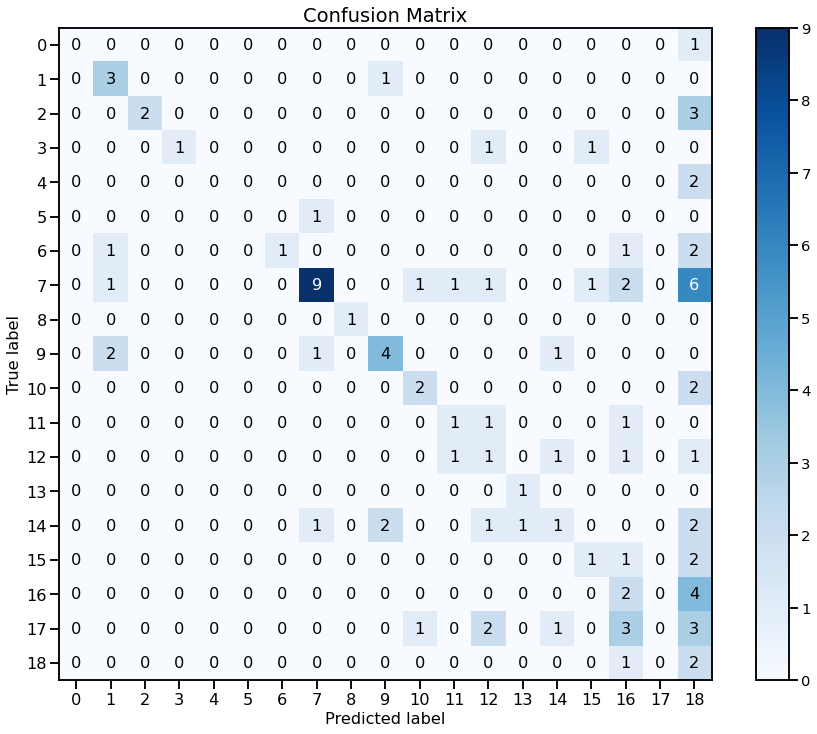

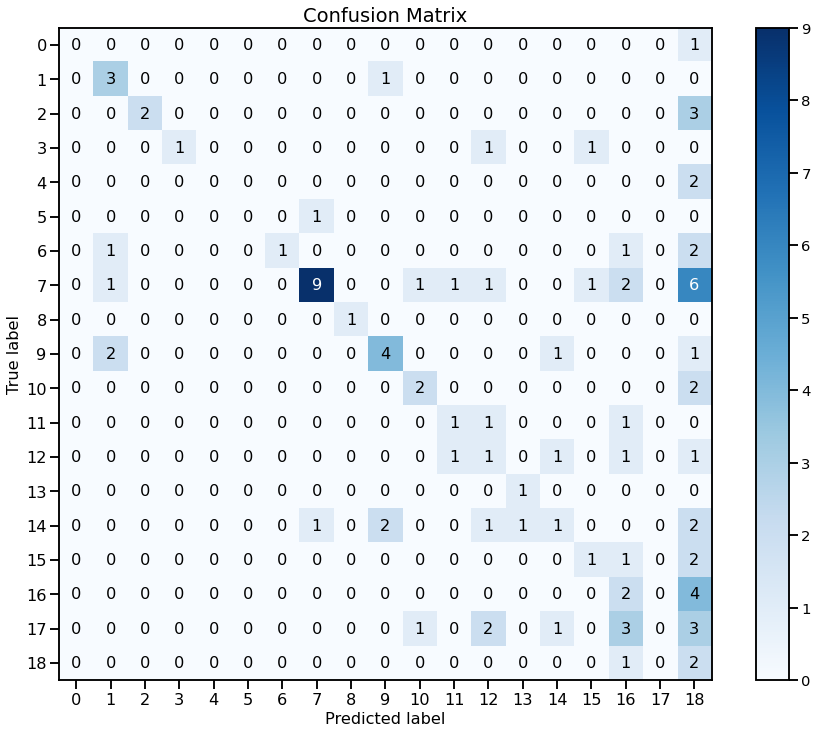

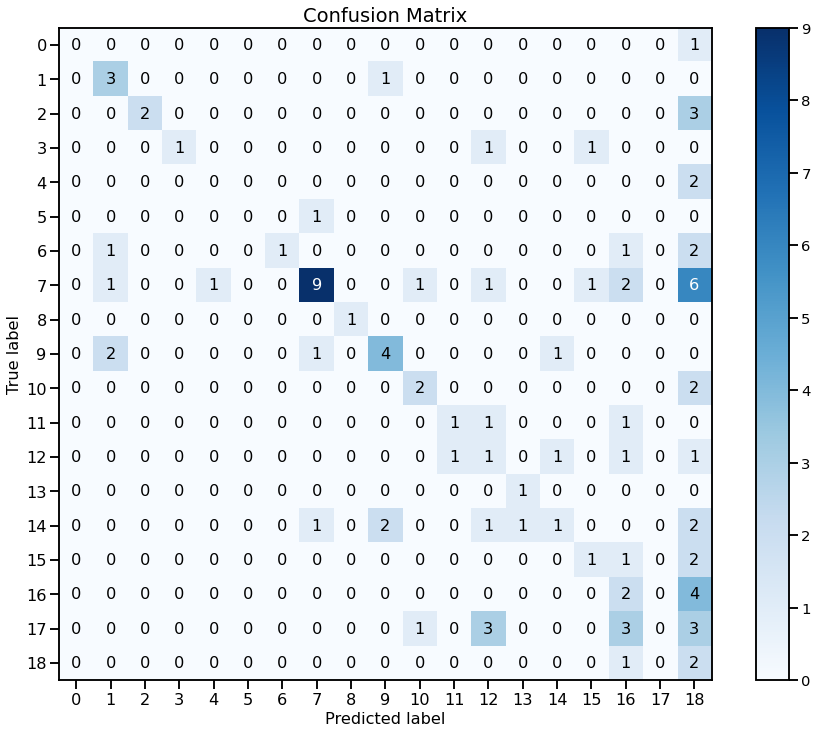

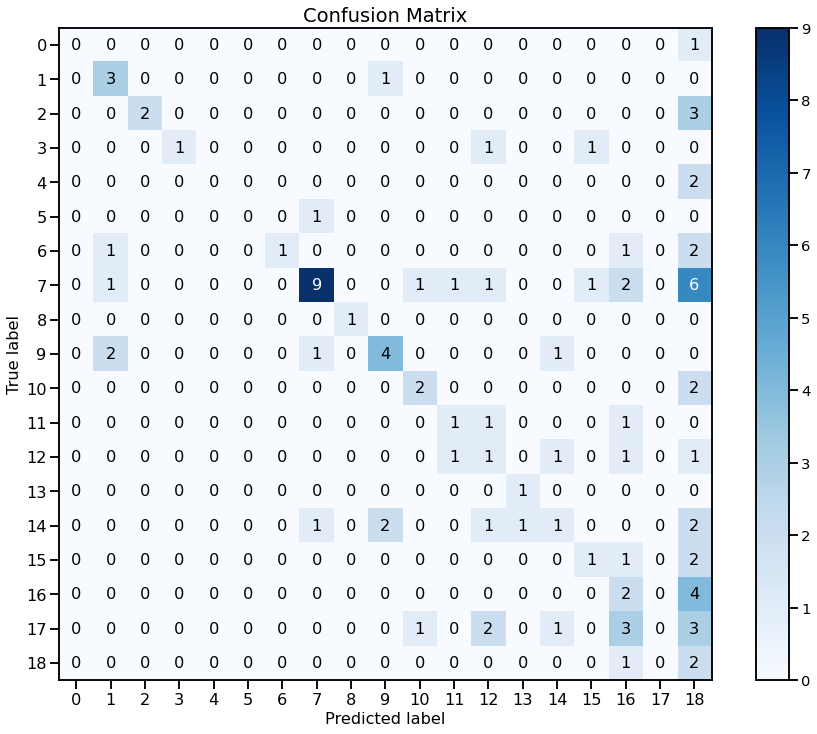

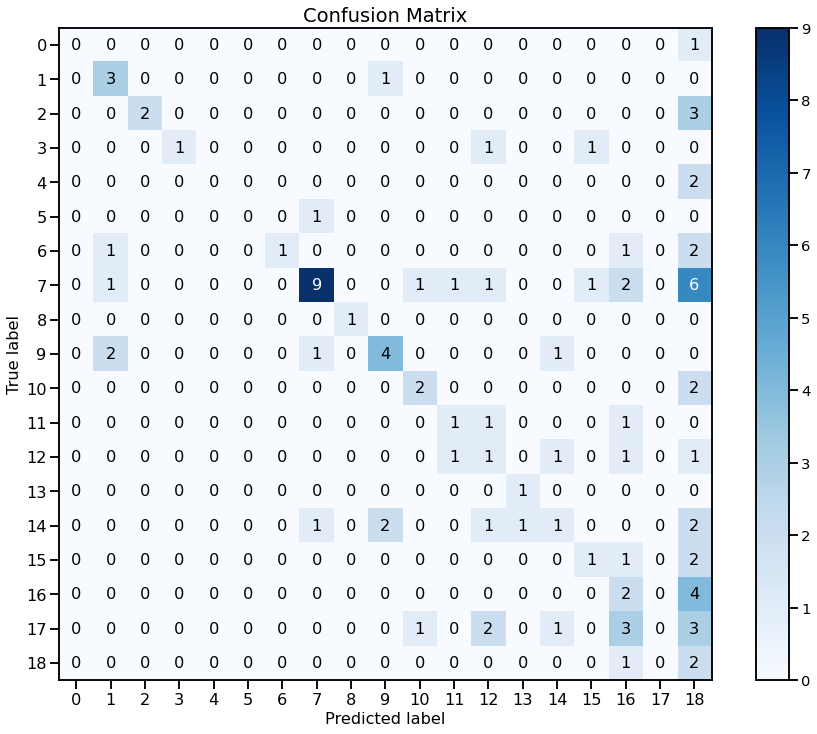

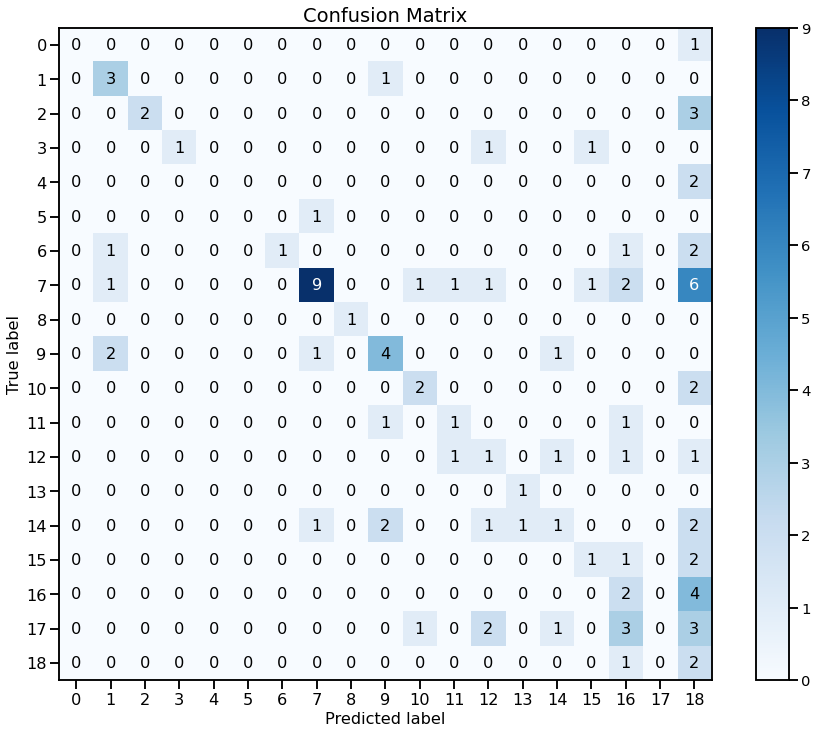

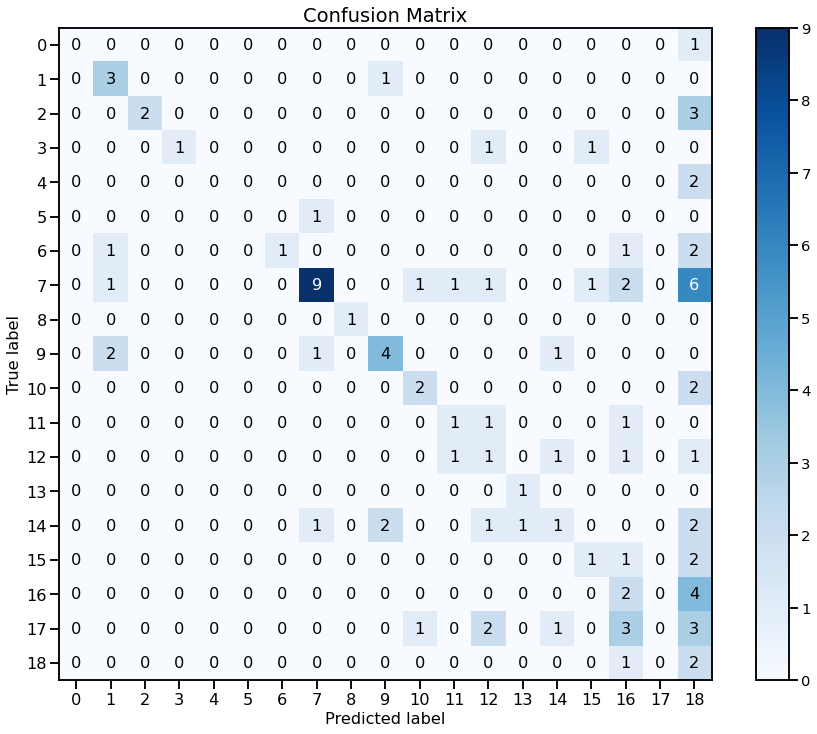

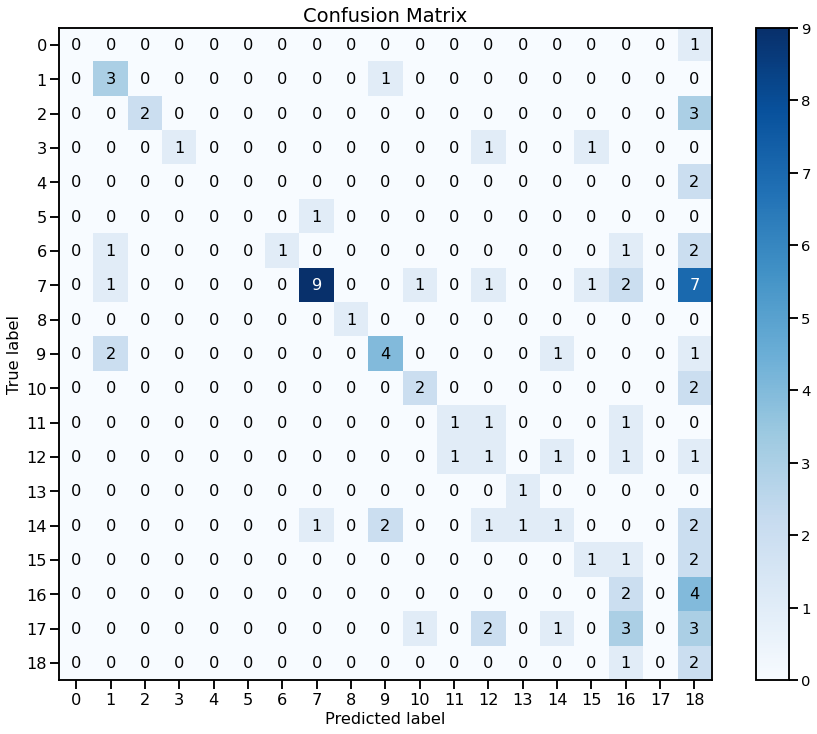

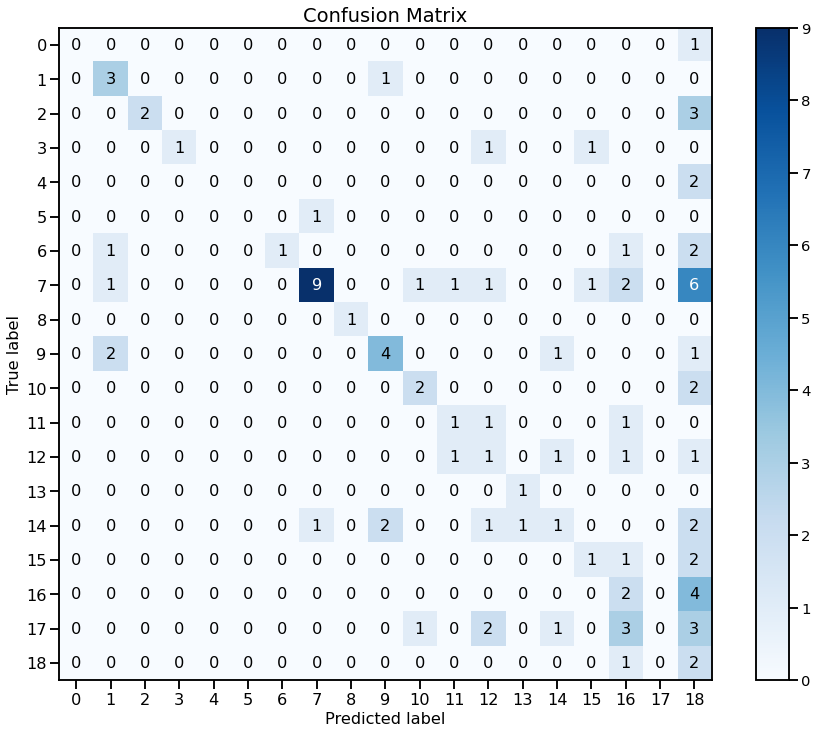

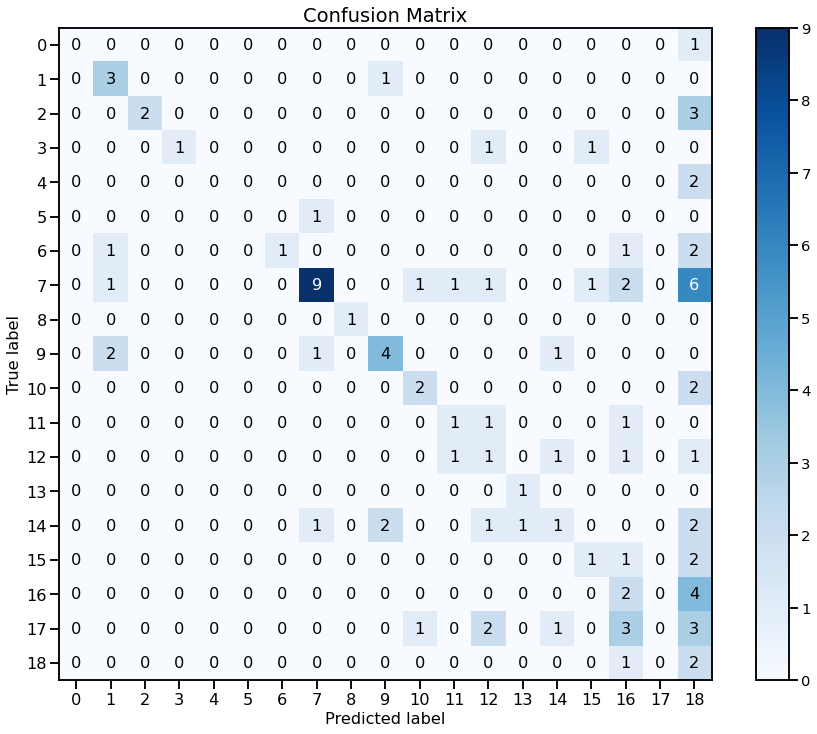

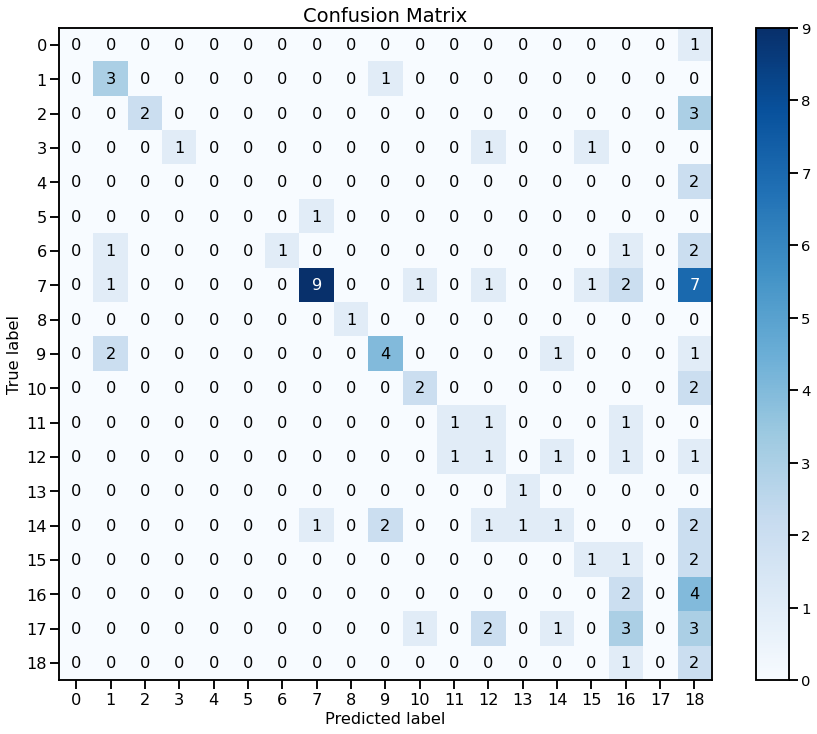

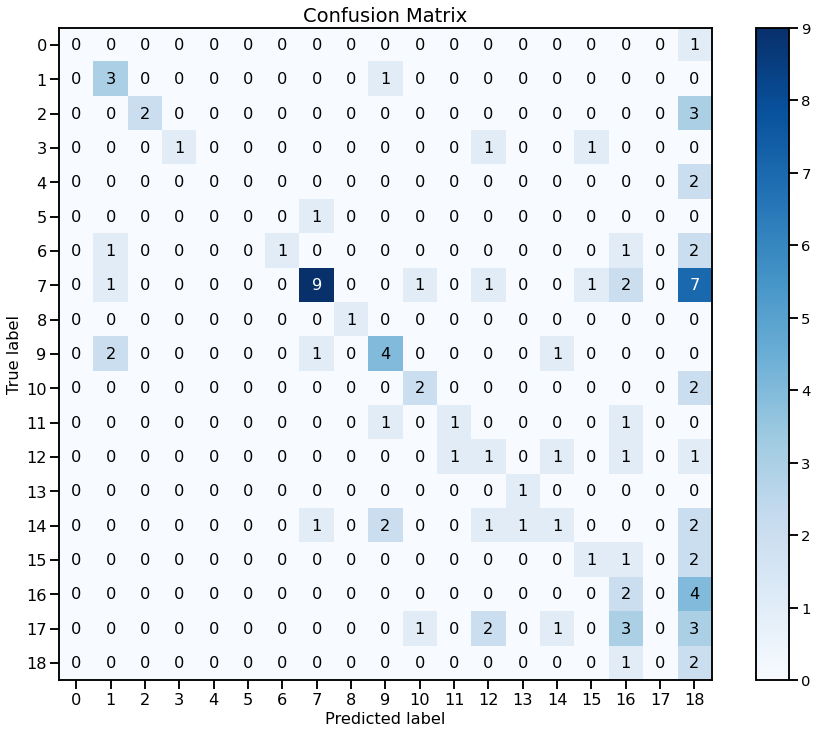

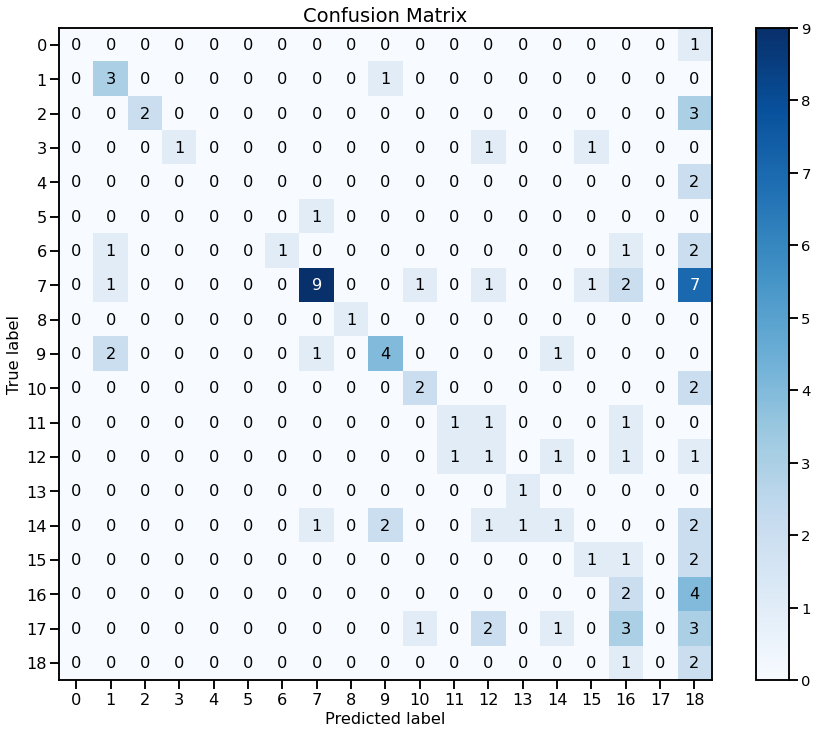

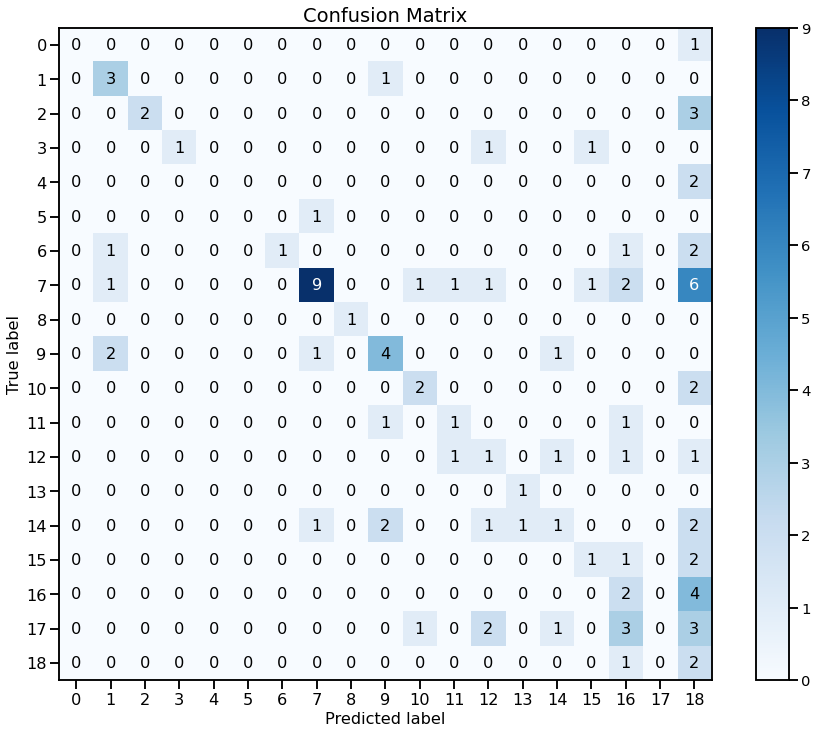

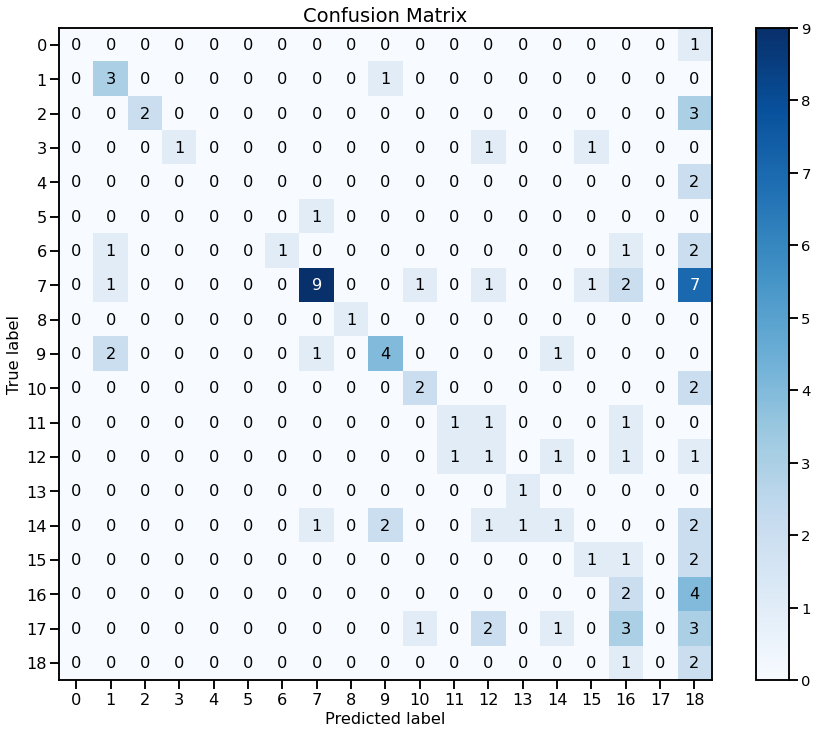

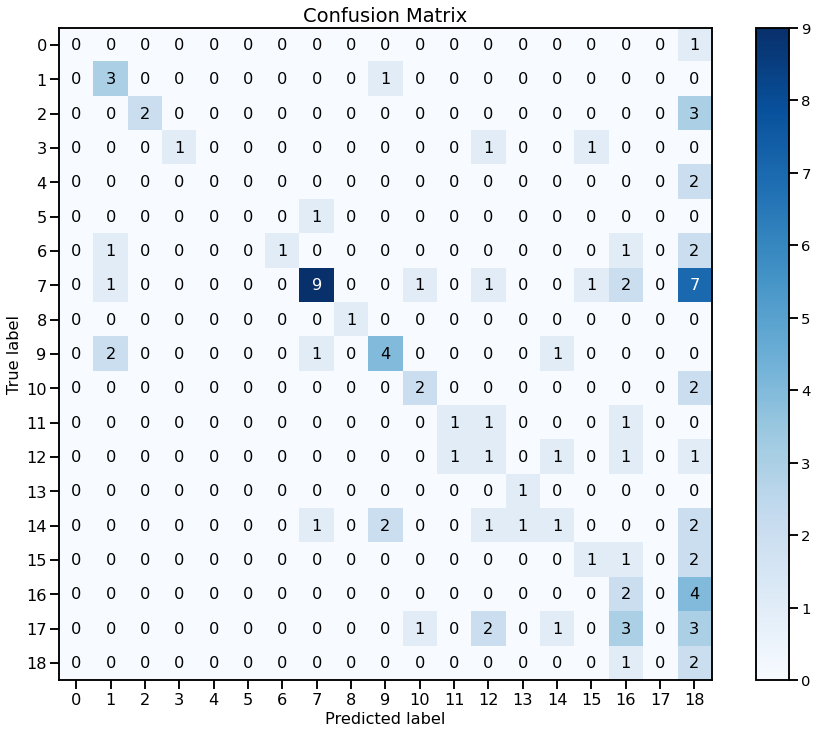

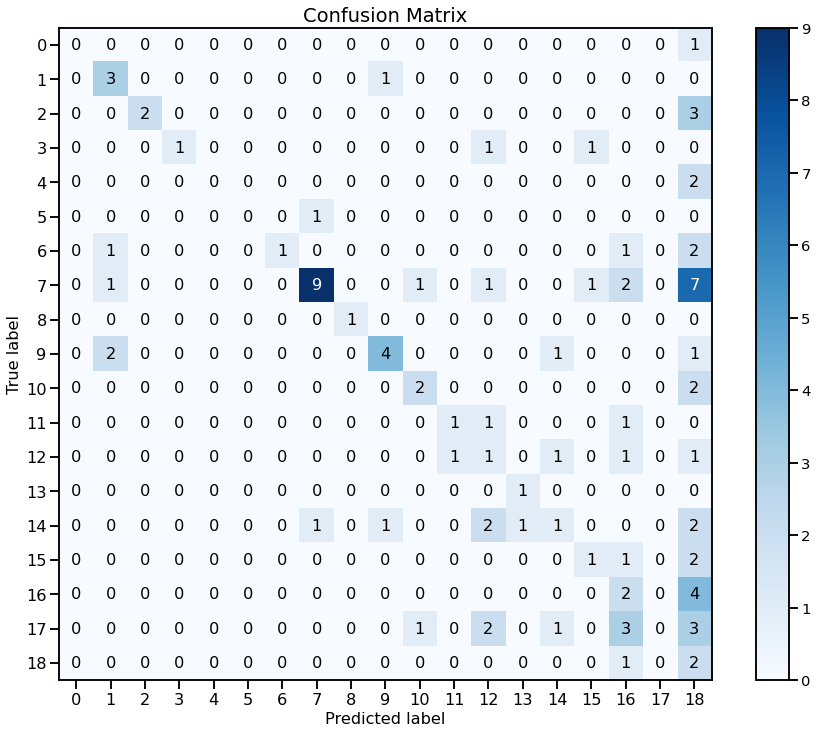

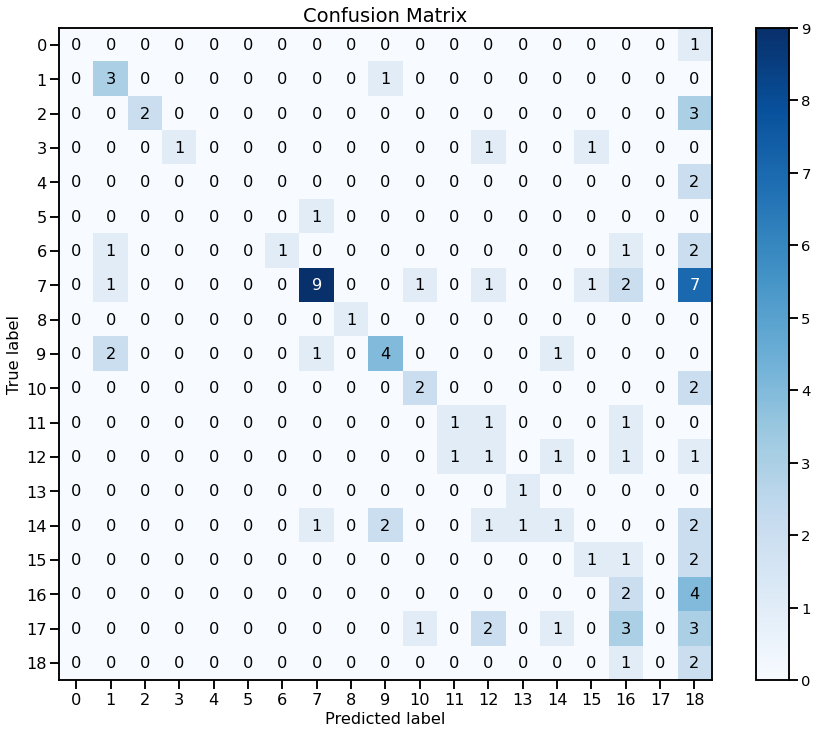

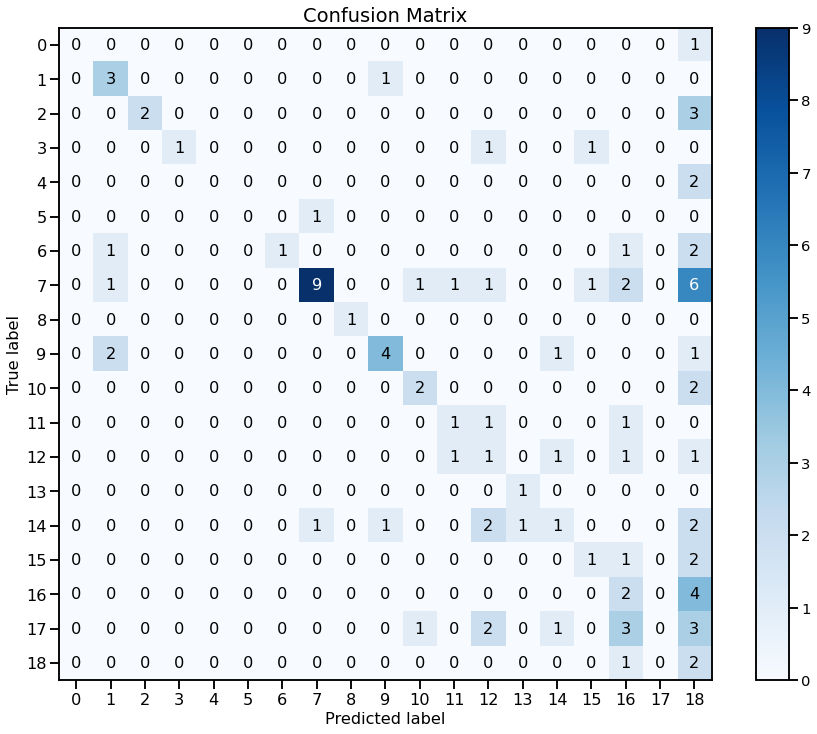

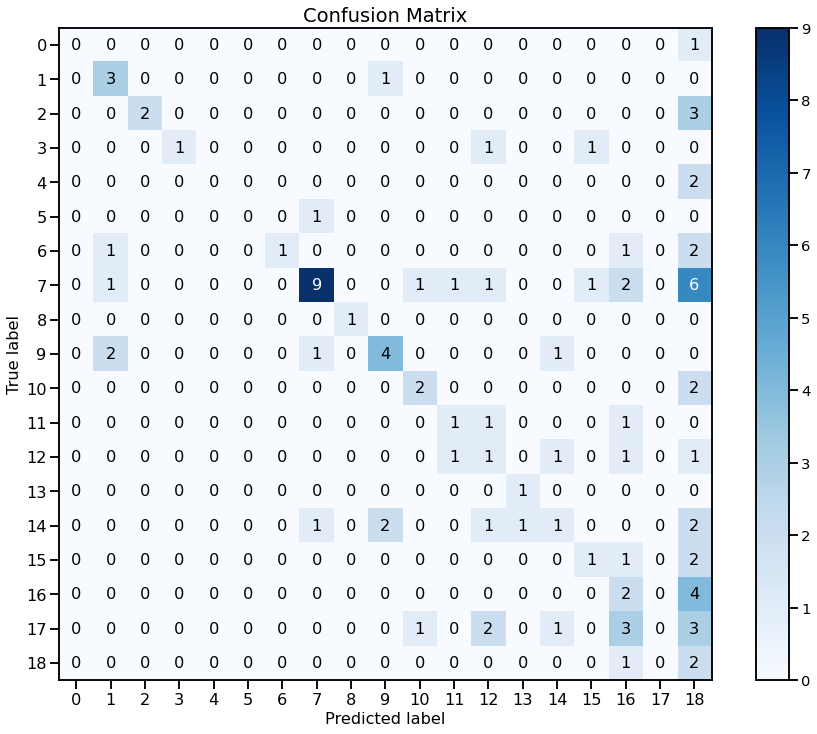

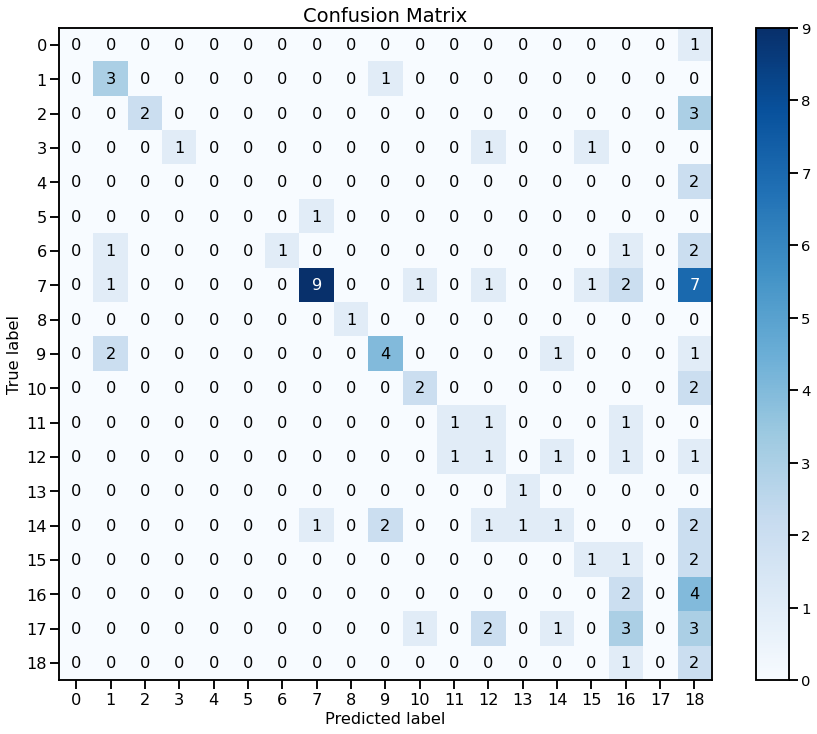

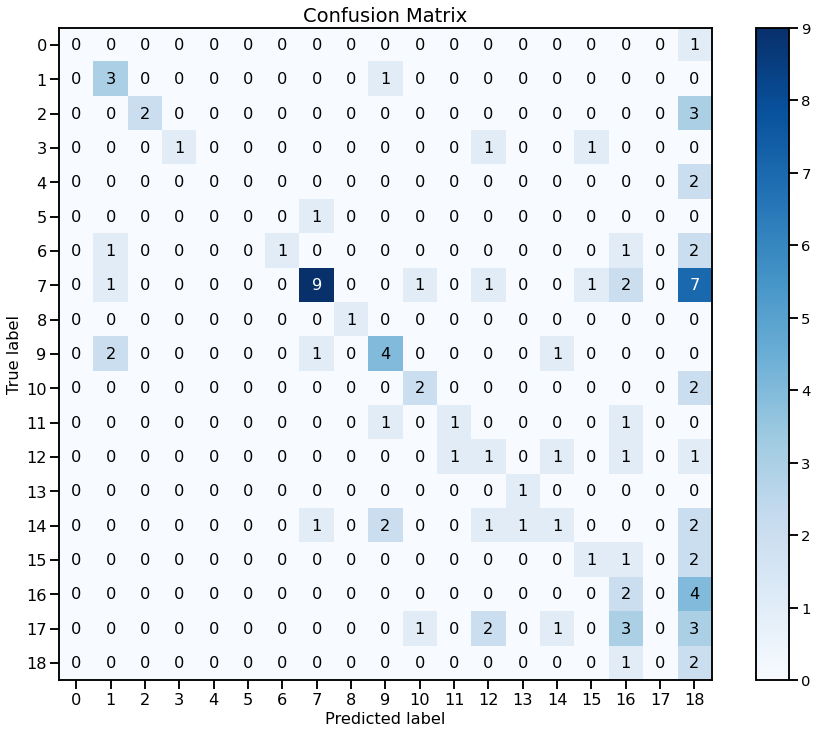

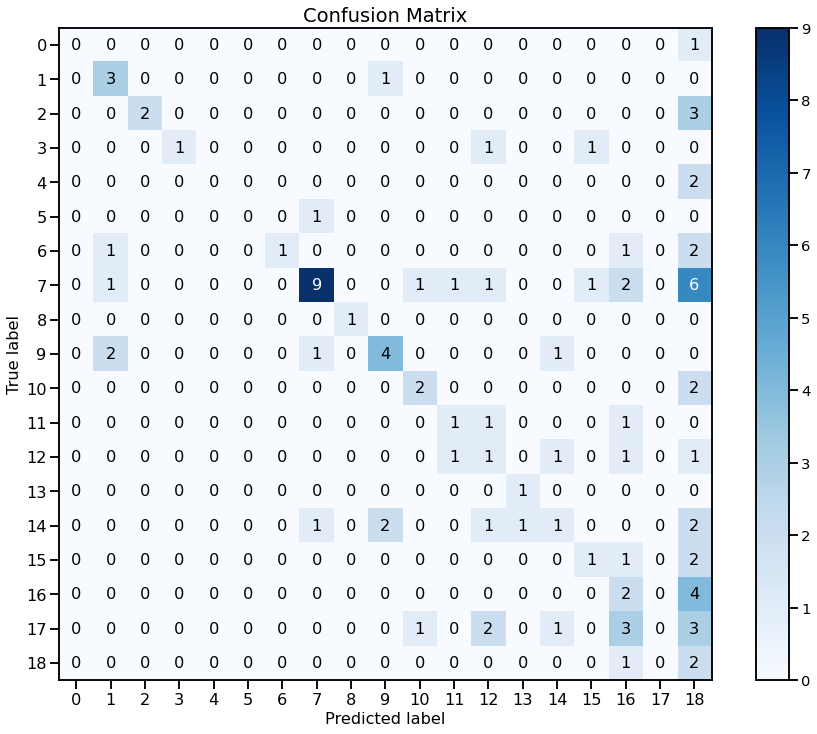

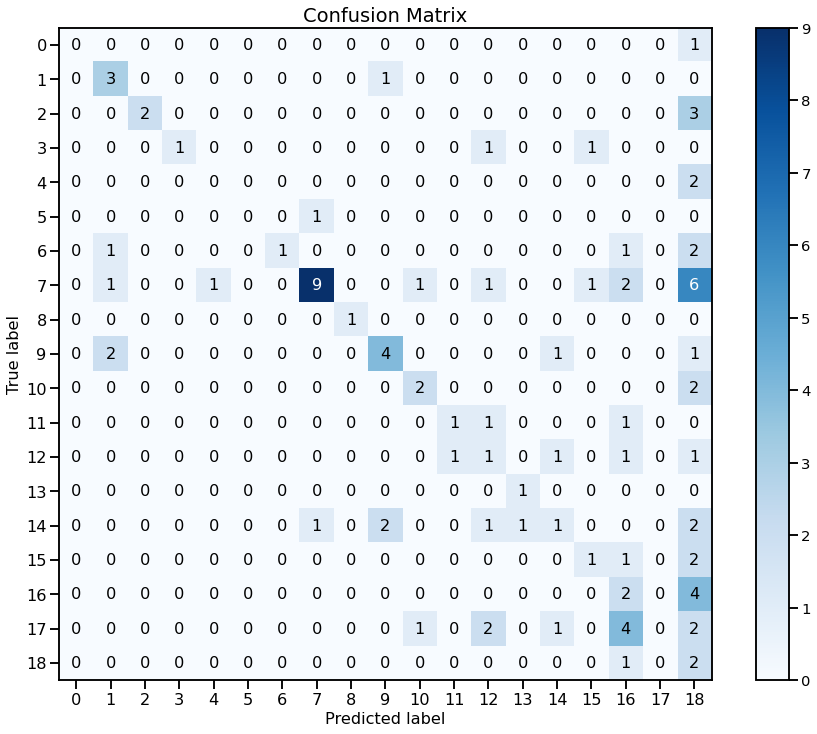

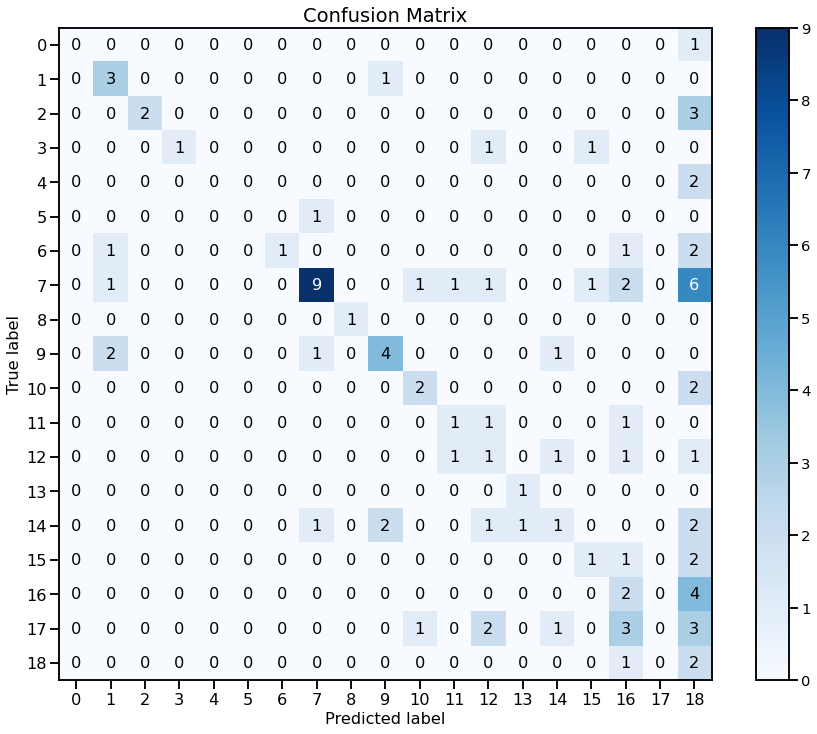

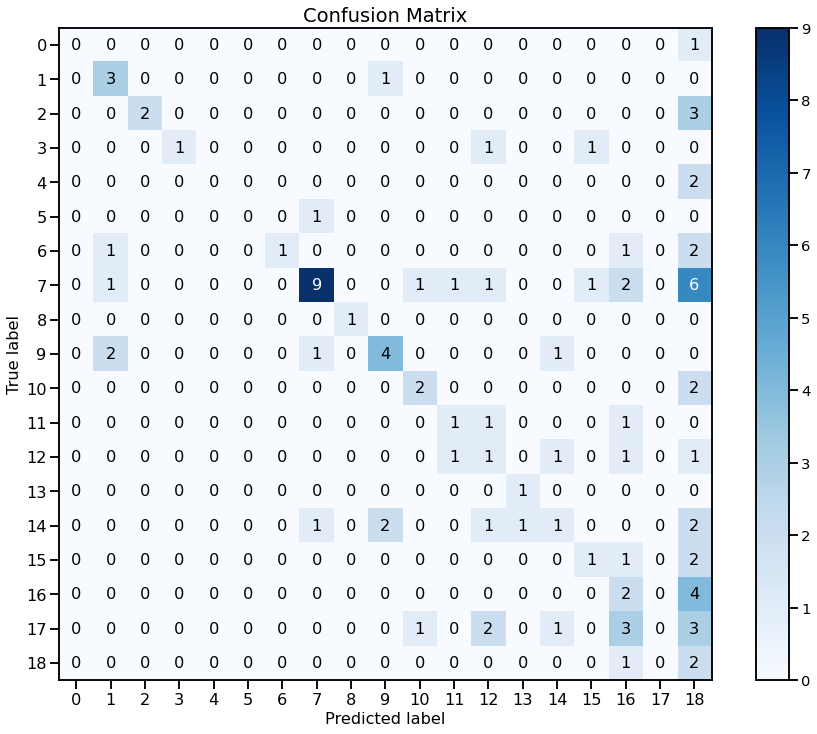

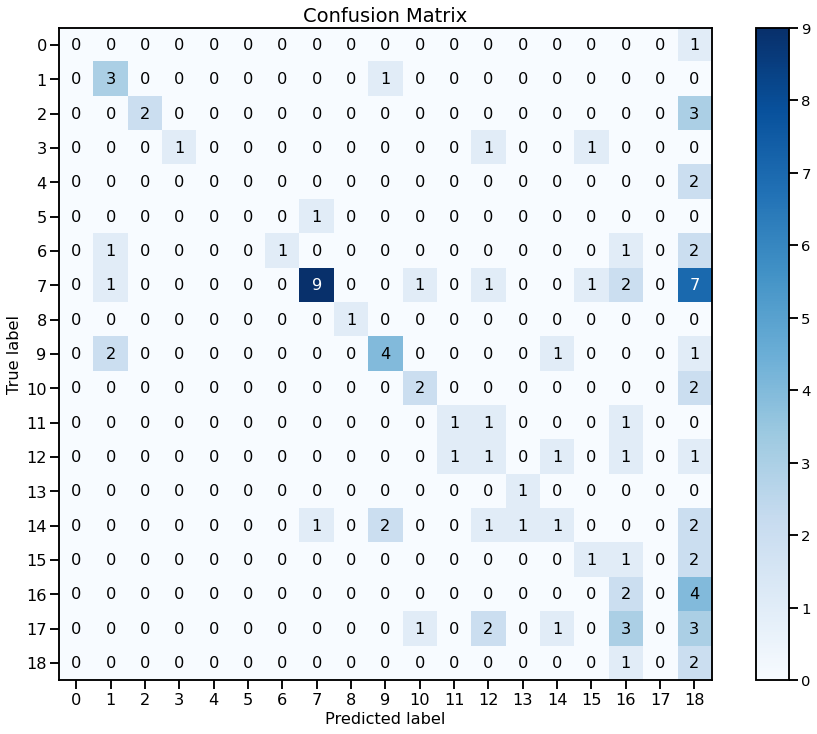

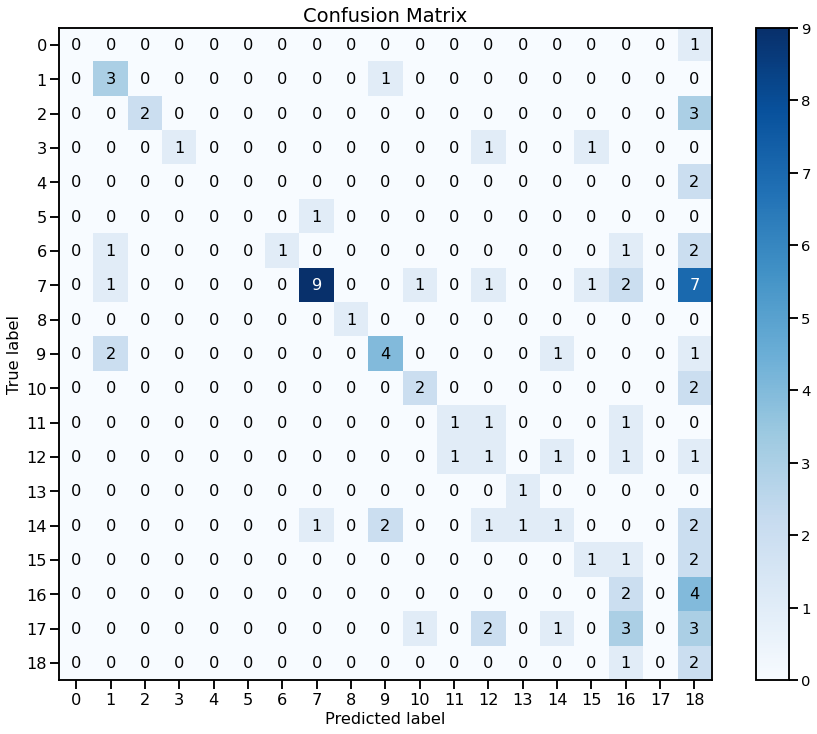

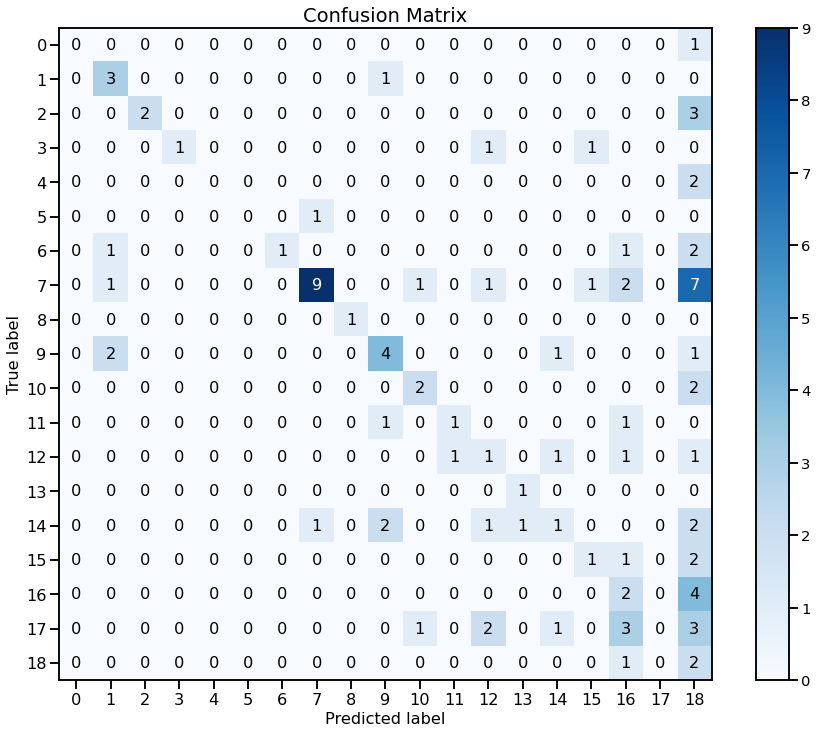

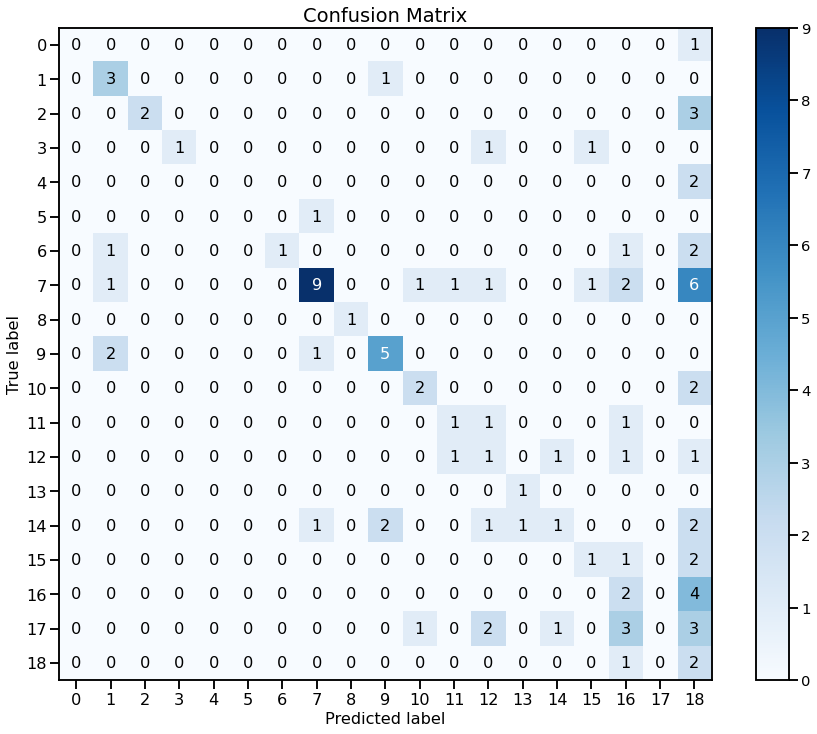

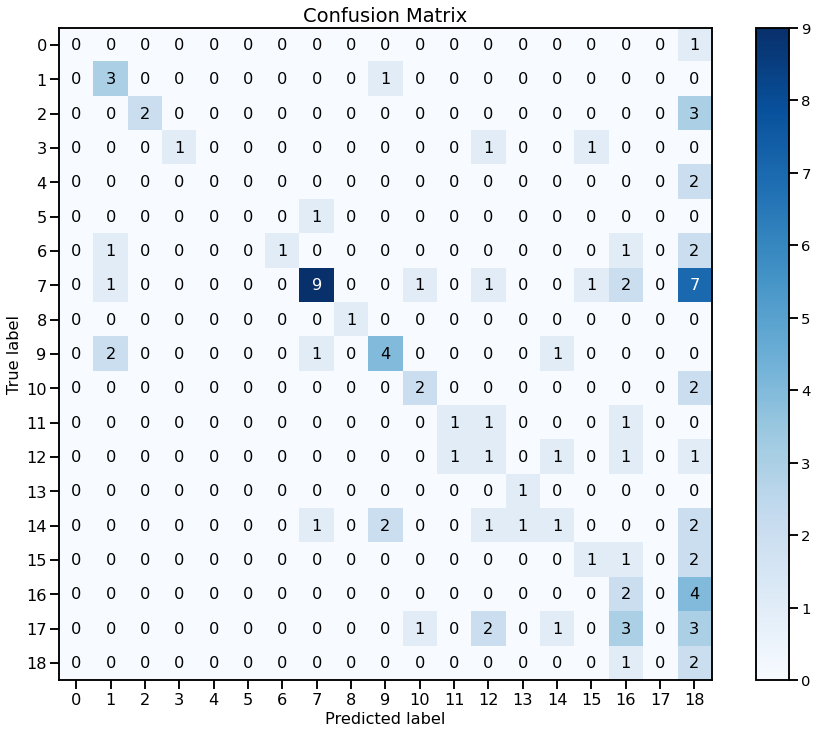

In [8]:
for hp in logs:
    overrides = copy(overrides_template)
    overrides[4] = overrides_template[4].format(hp.l2)
    overrides[5] = overrides_template[5].format(hp.lr)
    
    log_path = os.path.join(log_dir, f'hparam_sweep_{hparam_keys}_num_trials={num_trials}_{experiment_start_time}', 'hparam_conf.csv')
    logs.to_csv(log_path)

    
    
    print(f'BEGINNING TRIAL {hp.trial} with hparams:\n',hp.to_yaml())
    
    main(overrides, hp)

In [ ]:
python /home/jacob/projects/pyleaves/pyleaves/pipelines/pipeline_simple.py dataset@dataset=Leaves_in_PNAS_family_100 restore_last=False dataset.val_split=0.1 run_description="''" model.regularization.l2=4e-3,8e-3 model.lr=1e-4,1e-3 model.head_layers=[512,256] buffer_size=512 tags=['reference','Leaves_in_PNAS_family_100'] use_tfrecords=True --multirun

In [ ]:
#     print(overrides)    

#     overrides = ['dataset@dataset=PNAS_family_100',
#                  'restore_last=False',
#                  'dataset.val_split=0.1',
#                  '''run_description="'Initial PNAS_family_100'" ''',
#                  f'model.regularization.l2={hp.l2}',
#                  f'model.lr={hp.lr}',
#                  'model.head_layers=[512,256]',
#                  'buffer_size=512',
#                  "tags=['reference','PNAS_family_100']", 
#                  'use_tfrecords=False',
#                  'callbacks.early_stopping_patience=10']



In [ ]:

-rwxrwxr-- 1 cis-storage cis-storage  6251 Sep 14 22:34 pyleaves_tf2.1.yml


In [ ]:
python /home/jacob/projects/pyleaves/pyleaves/pipelines/pipeline_simple.py dataset@dataset=PNAS_100 restore_last=False dataset.val_split=0.1 run_description="'increased l2 reg from 4e-10 -> 4e-6 to reduce overfitting'" model.regularization.l2=4e-6 model.lr=1e-4 model.head_layers=[256,128] buffer_size=512 tags=['reference','PNAS_100'] use_tfrecords=False

In [ ]:
# subset = 'train'
# train_datasets = split_datasets[subset]
# train_datasets.metadata.plot_class_distribution()

In [ ]:
# (split_datasets['train'].data.family)
# subset='test'
subset='train'
test_iter = iter(data[subset])
x,y = next(test_iter)
x,y = x.numpy(), y.numpy()
np.argmax(y, axis=-1)

import cv2
import matplotlib.pyplot as plt
# path = fold.train_data.path.to_list()[0]
img = cv2.imread(path)
plt.imshow(img)
print(cfg.pretty())

In [128]:
cfg = flatten_dict(cfg, exceptions=['debugging'])

data_config = create_dataset_config(**cfg)

cfg = data_config

from pyleaves.train.paleoai_train import load_data, prep_dataset

split_data, split_datasets, encoder = load_data(data_fold=fold,
                                                exclude_classes=cfg.exclude_classes,
                                                include_classes=cfg.include_classes,
                                                use_tfrecords=cfg.use_tfrecords,
                                                tfrecord_dir=cfg.tfrecord_dir,
                                                val_split=cfg.val_split,
                                                samples_per_shard=cfg.samples_per_shard,
                                                seed=cfg.seed)

split_data#, split_datasets, encoder 

data

In [118]:

subset='train'
x,y = next(iter(split_data[subset]))

x,y = x.numpy(), y.numpy()

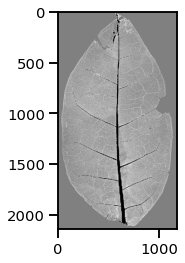

In [116]:
plt.imshow(x)

In [115]:
x.shape

(2144, 1173, 3)

In [112]:
import numpy as np

print(np.min(x), np.max(x), np.mean(x), np.std(x))

0 255 149.51960028820093 36.53274714061559


In [27]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [36]:
q = np.ones((512,512,3))*131.0#255.0

q_proc = preprocess_input(q)

print(np.min(q), np.max(q), np.mean(q), np.std(q))

for i in range(3):
    print(q[0,0,i])

q = np.ones((512,512,3))*255.0

q_proc = preprocess_input(q)

print(np.min(q), np.max(q), np.mean(q), np.std(q))

for i in range(3):
    print(q[0,0,i])

-131.32+7.32

(255-x)/y - 131.32 = (131-x)/y - 7.32 

(255-x)/y - (131-x)/y - 124.0 = 0

(255-x)-(131-x) - 124.0*y = 0

124 - 124*y = 0

y=1

131/()

In [87]:
mean = [103.939, 116.779, 123.68]
std = None

In [102]:
subset='train'
x,y = next(iter(data[subset]))
x,y = x.numpy(), y.numpy()
x = x[0,...]
x.shape

(512, 512, 3)

In [104]:
mean = np.mean(mean)

In [105]:
mean

114.79933333333334

In [106]:
# x = x[..., ::-1]
# x[..., 0] += mean[0]
# x[..., 1] += mean[1]
# x[..., 2] += mean[2]
print(mean)
print(np.min(x), np.max(x), np.mean(x), np.std(x))
x[..., 0] += mean#[1]
print(np.min(x), np.max(x), np.mean(x), np.std(x))
x[..., 1] += mean#[1]
print(np.min(x), np.max(x), np.mean(x), np.std(x))
x[..., 2] += mean#[1]

print(np.min(x), np.max(x), np.mean(x), np.std(x))

114.79933333333334
5.480339 258.03735 174.61493 38.281456
5.480339 372.83667 212.88142 66.28809
5.480339 372.83667 251.14781 66.288086
120.27967 372.83667 289.41428 38.281456


In [94]:
for c in range(3):
    print(c)
    print(np.min(x[...,c]), np.max(x[...,c]), np.mean(x[...,c]), np.std(x[...,c]))

0
-113.716156 141.24373 49.73386 33.855526
1
-113.716156 141.24373 49.73386 33.855526
2
-113.716156 141.24373 49.73386 33.855526


In [43]:
x =1 + (x-np.max(x))/(np.max(x)-np.min(x))

In [53]:
def plot_image_grid(imgs, labels = np.array([]), x_plots = 4, y_plots = 4, figsize=(15,15)):
	fig, axes = plt.subplots(y_plots, x_plots, figsize=figsize)
	axes = axes.flatten()

	num_imgs = len(imgs)

	if len(axes) > num_imgs:
		axes = axes[:num_imgs]
	for i, ax in enumerate(axes):
		ax.axes.get_xaxis().set_visible(False)
		ax.axes.get_yaxis().set_visible(False)

		ax.imshow(imgs[i,...])
	plt.tight_layout()

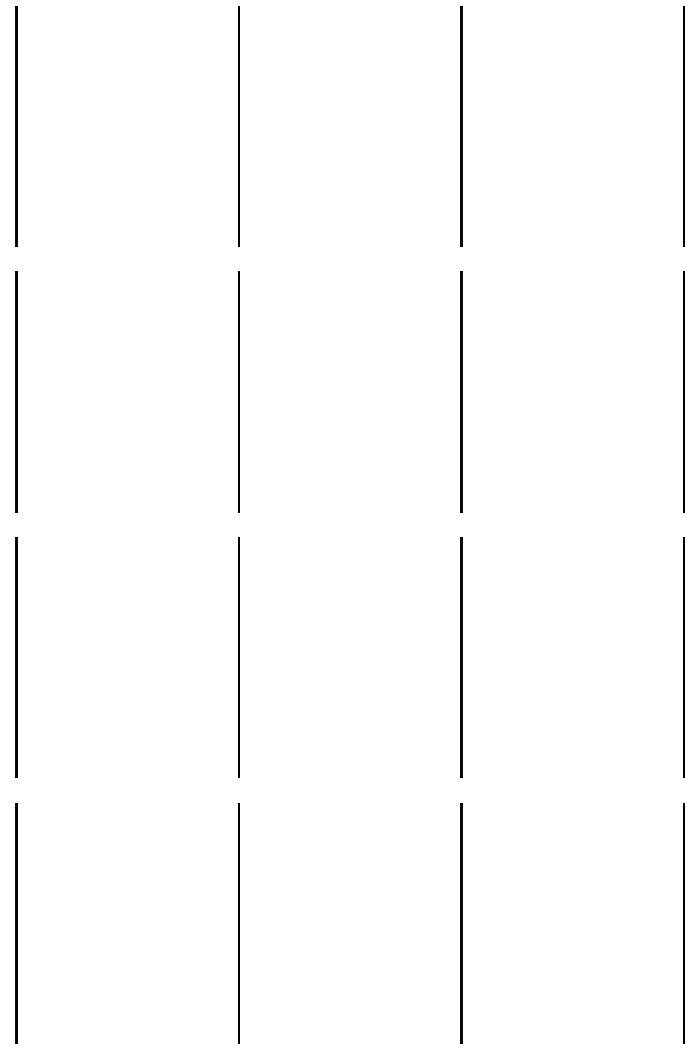

In [113]:
plot_image_grid(x, labels=[], x_plots = 4, y_plots = 4, figsize=(15,15))

In [9]:
%debug

> /media/data/conda/jacob/envs/pyleaves2/lib/python3.7/posixpath.py(80)join()
     78     will be discarded.  An empty last part will result in a path that
     79     ends with a separator."""
---> 80     a = os.fspath(a)
     81     sep = _get_sep(a)
     82     path = a



ipdb>  u


> /home/jacob/projects/tfrecord_utils/tfrecord_utils/encoders.py(298)__init__()
    296 
    297         self.output_dir = output_dir
--> 298         self.cache_dir = os.path.join(output_dir, 'cachedb')
    299         self.columns = OneToOne(columns)
    300 



ipdb>  ll


    288     def __init__(self,
    289                  data: pd.DataFrame,
    290                  output_dir: str=None,
    291                  columns: Dict[str,str]={'source_path':'source_path','target_path':'target_path', 'label':'label'}):
    292         '''
    293         Class for managing different conversion functions depending on source and target image formats.
    294         '''
    295         self.output_ext = 'jpg'
    296 
    297         self.output_dir = output_dir
--> 298         self.cache_dir = os.path.join(output_dir, 'cachedb')
    299         self.columns = OneToOne(columns)
    300 
    301         data = data.rename(columns=self.columns.inv)
    302 
    303         self.labels = data[self.columns['label']].unique().tolist()
    304         self.num_classes = len(self.labels)
    305         # [ensure_dir_exists(join(output_dir,label)) for label in self.labels]
    306 
    307         self.num_samples = data.shape[0]
    308         self.indices = np.ar

ipdb>  u


> /home/jacob/projects/tfrecord_utils/tfrecord_utils/encoders.py(507)__init__()
    505                 List of strings representing each level of subdirectory beneath root_dir to search before expecting train/val/test dirs.
    506         '''
--> 507         super().__init__(data, output_dir, columns)
    508 
    509         self.output_ext='tfrecord'



ipdb>  ll


    482     def __init__(self,
    483                  data,
    484                  output_dir=None,
    485                  columns={'source_path':'source_path','target_path':'target_path', 'label':'label'},
    486                  subset='train',
    487                  target_shape=(768,768,3),
    488                  num_shards=10,
    489                  samples_per_shard=None,
    490                  num_classes=None):#
    491                 #  TFRecordItem_factory=None,
    492                 #  tfrecords_table=TFRecordsTable(db_path=EXPERIMENTS_DB)):
    493         '''
    494         Example usage:
    495 
    496             coder = TFRecordCoder(data, output_dir, subset='train', target_size=(224,224), num_shards=10)
    497             coder.execute_convert()
    498 
    499         Arguments:
    500             data, dict:
    501                 dict with keys ['path', 'label']
    502             root_dir:
    503                 Root of experiment, contai

ipdb>  u


> /home/jacob/projects/pyleaves/pyleaves/train/paleoai_train.py(385)load_data_from_tfrecords()
    383                                            target_shape=target_shape,
    384                                            samples_per_shard=samples_per_shard,
--> 385                                            num_classes=num_classes)
    386 
    387             coders[subset].execute_convert()



ipdb>  l


    380             coders[subset] = TFRecordCoder(data = data[subset],
    381                                            output_dir = tfrecord_dir,
    382                                            subset=subset,
    383                                            target_shape=target_shape,
    384                                            samples_per_shard=samples_per_shard,
--> 385                                            num_classes=num_classes)
    386 
    387             coders[subset].execute_convert()
    388             files[subset] = [os.path.join(tfrecord_dir,f) for f in os.listdir(tfrecord_dir) if subset in f]
    389 
    390     split_data = {}



ipdb>  ll


    367 def load_data_from_tfrecords(tfrecord_dir,
    368                              data=None,
    369                              target_shape=(768,768,3),
    370                              samples_per_shard=800,
    371                              subset_keys=['train','validation'],
    372                              num_classes=None):
    373 
    374     if data:
    375         for k,v in data.items():
    376             if v is not None and k in subset_keys:
    377                 data[k] = pd.DataFrame({'source_path':v[0],'label':v[1]})
    378         coders = {}; files = {}
    379         for subset in subset_keys:
    380             coders[subset] = TFRecordCoder(data = data[subset],
    381                                            output_dir = tfrecord_dir,
    382                                            subset=subset,
    383                                            target_shape=target_shape,
    384                                            samples_p

ipdb>  u


> /home/jacob/projects/pyleaves/pyleaves/train/paleoai_train.py(518)load_data()
    516                                                   samples_per_shard=samples_per_shard,
    517                                                   subset_keys=subset_keys, #['train','test'],
--> 518                                                   num_classes=len(encoder.classes))
    519     else:
    520         split_data = load_data_from_tensor_slices(split_data, shuffle_train=shuffle_train, seed=seed)



ipdb>  ll


    494 def load_data(data_fold: DataFold,
    495               exclude_classes=[],
    496               include_classes=[],
    497               use_tfrecords=False,
    498               tfrecord_dir=None,
    499               val_split=0.0,
    500               samples_per_shard=800,
    501               shuffle_train=True,
    502               seed=None):
    503 
    504     split_data, split_datasets, encoder = initialize_data_from_paleoai(fold=data_fold,
    505                                                                        exclude_classes=exclude_classes,
    506                                                                        include_classes=include_classes,
    507                                                                        val_split=val_split,
    508                                                                        seed=seed)
    509                                                                        # subset_keys=['train','test'],
  

ipdb>  use_tfrecords


True


ipdb>  u


> /home/jacob/projects/pyleaves/pyleaves/pipelines/pipeline_1.py(265)create_dataset()
    263                                                     val_split=cfg.val_split,
    264                                                     samples_per_shard=cfg.samples_per_shard,
--> 265                                                     seed=cfg.seed)
    266     cfg.num_classes = split_datasets['train'].num_classes
    267 



ipdb>  ll


    254 def create_dataset(data_fold: DataFold,
    255                    cfg: DictConfig):
    256     from pyleaves.train.paleoai_train import load_data, prep_dataset
    257 
    258     split_data, split_datasets, encoder = load_data(data_fold=data_fold,
    259                                                     exclude_classes=cfg.exclude_classes,
    260                                                     include_classes=cfg.include_classes,
    261                                                     use_tfrecords=cfg.use_tfrecords,
    262                                                     tfrecord_dir=cfg.tfrecord_dir,
    263                                                     val_split=cfg.val_split,
    264                                                     samples_per_shard=cfg.samples_per_shard,
--> 265                                                     seed=cfg.seed)
    266     cfg.num_classes = split_datasets['train'].num_classes
    267 
    268     train_data = p

ipdb>  cfg.use_tfrecords


True


ipdb>  print(cfg.pretty())


dataset_name:
  fold_id: 0
  batch_size: 16
  buffer_size: 200
  num_epochs: 150
  frozen_layers: null
  augmentations:
  - flip: 1.0
  steps_per_epoch: null
  validation_steps: null
  log_images: false
  log_epochs:
  - 5
  - 10
  train_confusion_matrix: true
  eval_confusion_matrix: true
  seed: 45
  use_tfrecords: false
  samples_per_shard: 300
  neptune_project_name: jacobarose/sandbox
  neptune_experiment_dir: /media/data/jacob/sandbox_logs
  experiment_name: PNAS_resnet_50_v2_[512, 512]
  experiment_dir: /media/data/jacob/sandbox_logs/PNAS_resnet_50_v2_[512, 512]/2020-09-11_17-01-27
  experiment_start_time: 2020-09-11_17-01-27
  restore_last: true
  log_dir: /media/data/jacob/sandbox_logs/PNAS_resnet_50_v2_[512, 512]/2020-09-11_17-01-27/log_dir
  model_dir: /media/data/jacob/sandbox_logs/PNAS_resnet_50_v2_[512, 512]/2020-09-11_17-01-27/model
  tfrecord_dir: /media/data/jacob/experimental_data/tfrecords/PNAS
  results_dir: /media/data/jacob/sandbox_logs/PNAS_resnet_50_v2_[512, 512

ipdb>  q


In [6]:
print(data_config.pretty())

NameError: name 'data_config' is not defined

In [ ]:
self.model_config = create_model_config(**OmegaConf.merge(self.config,self.data_config))
self.initialize_model(self.model_config)

def initialize_dataset(self, data_config: DictConfig):
# self.data_config = create_dataset_config(**self.config)
self.data, self.split_datasets, self.encoder = create_dataset(data_fold=self.fold,
                                                              cfg=data_config)

if self.config['steps_per_epoch'] is None:
    self.config['steps_per_epoch'] = self.split_datasets['train'].num_samples//data_config['batch_size']

if (self.config['validation_steps'] is None) and (self.split_datasets['val'] is not None):
    self.config['validation_steps'] = self.split_datasets['val'].num_samples//data_config['batch_size']

self.train_data, self.val_data, self.test_data = self.data['train'], self.data['val'], self.data['test']

In [ ]:
neptune.init(project_qualified_name=cfg.neptune_project_name)
params=OmegaConf.to_container(cfg)
with neptune.create_experiment(name=cfg.experiment_name+'-'+str(cfg.dataset.dataset_name), params=params):

    trainer = Trainer(fold,
                      cfg,
                      neptune=neptune,
                      verbose=True)

    date_format = '%Y-%m-%d_%H-%M-%S'
    train_start_time = datetime.now().strftime(date_format)

    print(f'Trainer constructed. Beginning training at {train_start_time}')

    history = trainer.train()

    test_results = trainer.evaluate(steps=20, confusion_matrix=cfg.eval_confusion_matrix)